# **XGBoost**

# **전처리**

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/기계/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [ ]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [ ]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [ ]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [ ]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [ ]:
df

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory      Race  Diabetic  \
0               30.0            0    0           55     White         2   
1                0.0            0    0           80     White         0   
2               30.0            0    1           65     White         2   
3                0.0            0    0           75     White         0   
4                0.0            1    0           40     White         0   
...              ...          ...  ...          ...       ...       ...   
319790           0.0            1    1           60  Hispanic         2   
319791           0.0            0    1           35  Hispanic         0   
319792           0.0            0    0           45  Hispanic         0   
319793           0.0            0    0           25  Hispanic         0   
319794           0.0            0    0           80  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3        5.0       1              0   
1                      1          3        7.0       0              0   
2                      1          1        8.0       1              0   
3                      0          2        6.0       0              0   
4                      1          3        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1        6.0       1              0   
319791                 1          3        5.0       1              0   
319792                 1          2        6.0       0              0   
319793                 0          2       12.0       0              0   
319794                 1          2        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[301653 rows x 18 columns]

In [ ]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [ ]:

df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [ ]:
#Race 인코딩 - target encoding
categories = df['Race'].unique()
targets = df['HeartDisease'].unique()
cat_list = []

for cat in categories:
    aux_dict = {}
    aux_dict['category'] = cat
    aux_df = df[df['Race'] == cat]
    counts = aux_df['HeartDisease'].value_counts()
    aux_dict['count'] = sum(counts)
    for t in targets:
        aux_dict['Race_' + str(t)] = counts[t]
    cat_list.append(aux_dict)

cat_list = pd.DataFrame(cat_list)
cat_list['genre_encoded_dumb'] = cat_list['Race_1'] / cat_list['count']

target_dict = {'White' : cat_list['genre_encoded_dumb'][0], 'Black' : cat_list['genre_encoded_dumb'][1], 'Asian' : cat_list['genre_encoded_dumb'][2], 'American Indian/Alaskan Native' : cat_list['genre_encoded_dumb'][3],
               'Other' : cat_list['genre_encoded_dumb'][4], 'Hispanic' : cat_list['genre_encoded_dumb'][5]}
df['Race_encoder'] = df['Race'].map(target_dict)

df.drop(['Race'], axis = 1, inplace = True)

In [ ]:
for i in range(0,6):
  print(cat_list['genre_encoded_dumb'][i])
print("White, Black, Asian, Other, Hispanic")

0.0983399209486166
0.07572168114416074
0.03303716681266425
0.10445172480246676
0.08132696195552289
0.053253127652507656
White, Black, Asian, Other, Hispanic


In [ ]:
df

HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  \
0                  0  1.403407        1                0       0   
1                  0  1.442302        0                0       1   
2                  0  1.487128        1                0       0   
3                  0  1.472250        0                0       0   
4                  0  1.468816        0                0       0   
...              ...       ...      ...              ...     ...   
319790             1  1.491857        1                0       0   
319791             0  1.504497        1                0       0   
319792             0  1.472452        0                0       0   
319793             0  1.517915        0                0       0   
319794             0  1.561599        0                0       0   

        PhysicalHealth  MentalHealth  DiffWalking  Sex  AgeCategory  Diabetic  \
0             0.669364      1.089487            0    0           55         2   
1             0.000000      0.000000            0    0           80         0   
2             0.801003      1.089487            0    1           65         2   
3             0.000000      0.000000            0    0           75         0   
4             0.807551      0.000000            1    0           40         0   
...                ...           ...          ...  ...          ...       ...   
319790        0.755892      0.000000            1    1           60         2   
319791        0.000000      0.000000            0    1           35         0   
319792        0.000000      0.000000            0    0           45         0   
319793        0.000000      0.000000            0    0           25         0   
319794        0.000000      0.000000            0    0           80         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3   3.488639       1              0   
1                      1          3   5.054525       0              0   
2                      1          1   5.813435       1              0   
3                      0          2   4.280563       0              0   
4                      1          3   5.813435       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1   4.280563       1              0   
319791                 1          3   3.488639       1              0   
319792                 1          2   4.280563       0              0   
319793                 0          2   8.734516       0              0   
319794                 1          2   5.813435       0              0   

        SkinCancer  Race_encoder  
0                1      0.098340  
1                0      0.098340  
2                0      0.098340  
3                1      0.098340  
4                0      0.098340  
...            ...           ...  
319790           0      0.053253  
319791           0      0.053253  
319792           0      0.053253  
319793           0      0.053253  
319794           0      0.053253  

[301653 rows x 18 columns]

In [ ]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']
print(x.shape, y.shape)

(301653, 17) (301653,)


In [ ]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [ ]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


## **샘플링**

In [ ]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train)
#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) 

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) 

In [ ]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek <- 얘는 사용한다는 말이 없었어서 일단 주석처리 하겠습니다.
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) 

# **ROC**

Accuracy 0.9107424044023802
Precision 0.5677852348993289
Recall 0.07710535909588043
F1 0.13577274915743862
AUC 0.8402650451590831
[[54523   322]
 [ 5063   423]]


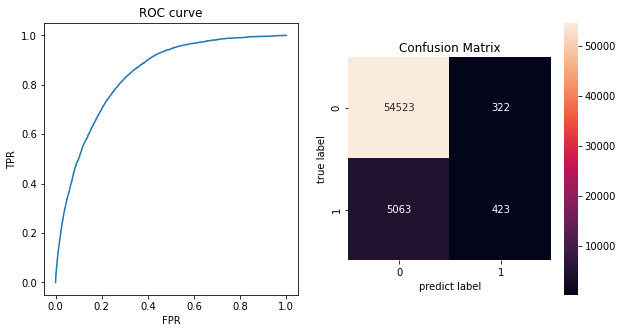

In [ ]:
import xgboost as xgb
from sklearn import metrics

#불균형 처리 x
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7927930914455256
Precision 0.25030255570584464
Recall 0.6409041195771054
F1 0.3600061434495469
AUC 0.8159177205292734
[[44314 10531]
 [ 1970  3516]]


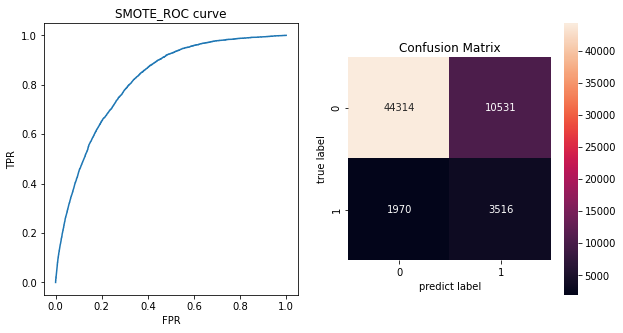

In [ ]:
#SMOTE
model = xgb.XGBClassifier()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7901079047255971
Precision 0.2501566525099213
Recall 0.6549398468829748
F1 0.3620333518061363
AUC 0.8212659565865649
[[44075 10770]
 [ 1893  3593]]


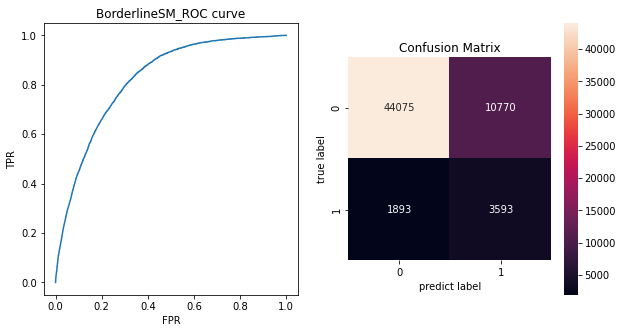

In [ ]:
#BorderlineSMote
model = xgb.XGBClassifier()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.821087003364771
Precision 0.27835309837982297
Recall 0.6075464819540649
F1 0.38178694158075605
AUC 0.8311469432281682
[[46204  8641]
 [ 2153  3333]]


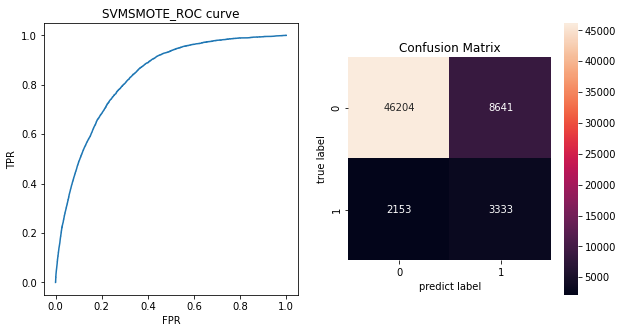

In [ ]:
#SVMSMote
model = xgb.XGBClassifier()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.782052344565812
Precision 0.2399022469621886
Recall 0.6441851986875684
F1 0.34960676658257905
AUC 0.8104509570221211
[[43648 11197]
 [ 1952  3534]]


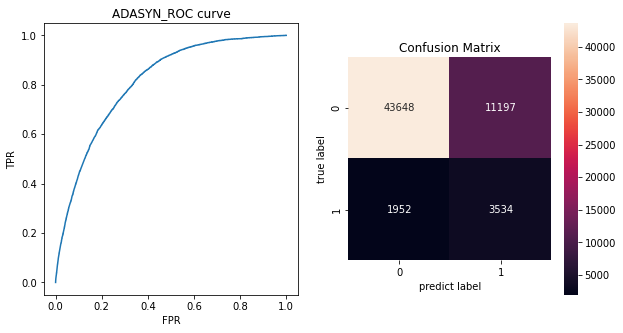

In [ ]:
#ADASYN
model = xgb.XGBClassifier()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7650627372329316
Precision 0.23944337811900193
Recall 0.7276704338315713
F1 0.36032132863976896
AUC 0.8301225885417916
[[42165 12680]
 [ 1494  3992]]


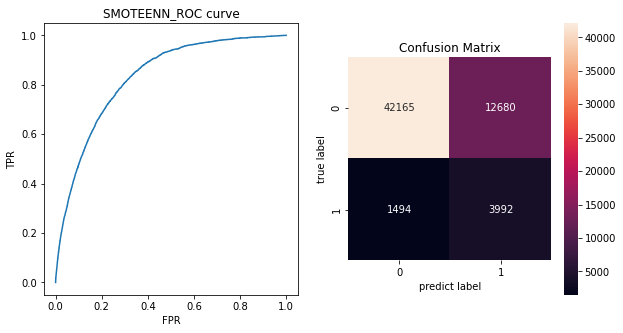

In [ ]:
#SMOTEENN
model = xgb.XGBClassifier()
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7332714524871128
Precision 0.22611300485487038
Recall 0.7980313525337221
F1 0.3523824855119125
AUC 0.8404714150344554
[[39861 14984]
 [ 1108  4378]]


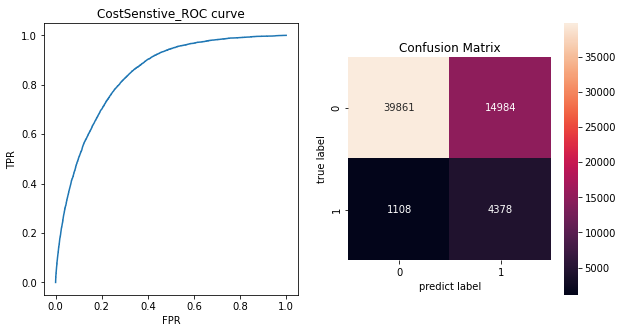

In [ ]:
import xgboost as xgb
from sklearn import metrics

#Costsensitive
model = xgb.XGBClassifier(scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

## **하이퍼파라미터 튜닝**

In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#불균형 처리 x
model = xgb.XGBClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.785981	validation_1-auc:0.789397
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.803914	validation_1-auc:0.806411
[2]	validation_0-auc:0.805727	validation_1-auc:0.808005
[3]	validation_0-auc:0.811252	validation_1-auc:0.813691
[4]	validation_0-auc:0.812321	validation_1-auc:0.814947
[5]	validation_0-auc:0.814754	validation_1-auc:0.817756
[6]	validation_0-auc:0.825582	validation_1-auc:0.827851
[7]	validation_0-auc:0.824896	validation_1-auc:0.826974
[8]	validation_0-auc:0.823198	validation_1-auc:0.825345
[9]	validation_0-auc:0.828096	validation_1-auc:0.829852
[10]	validation_0-auc:0.827452	validation_1-auc:0.829222
[11]	validation_0-auc:0.829134	validation_1-auc:0.830396
[12]	validation_0-auc:0.830435	validation_1-auc:0.831413
[13]	validation_0-auc:0.832512	validation_1-auc:0.833377
[14]	validation_0-auc:0.832668	validation_1-auc:0.83345

Accuracy 0.9108915814423763
Precision 0.5672371638141809
Recall 0.08457892818082391
F1 0.14720812182741116
AUC 0.8408243335284168
[[54491   354]
 [ 5022   464]]


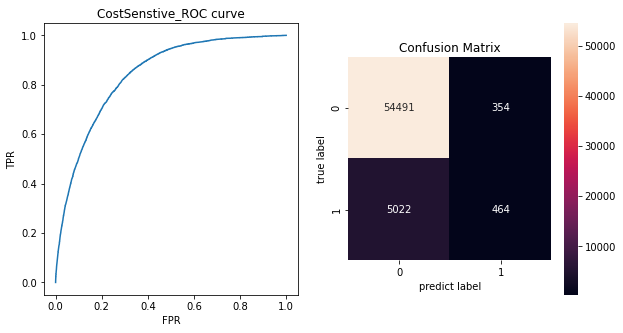

In [ ]:
#파라미터 튜닝
#불균형 적용x
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=4, 
                          min_child_weight=3,
                          colsample_bytree=0.5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#SMOTE
model = xgb.XGBClassifier(n_estimators=100)
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_SMOTE, y_train_SMOTE, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_SMOTE, y_train_SMOTE), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.778521	validation_1-auc:0.763344
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.813298	validation_1-auc:0.776171
[2]	validation_0-auc:0.812545	validation_1-auc:0.779414
[3]	validation_0-auc:0.815498	validation_1-auc:0.791099
[4]	validation_0-auc:0.823369	validation_1-auc:0.791286
[5]	validation_0-auc:0.836871	validation_1-auc:0.79485
[6]	validation_0-auc:0.856284	validation_1-auc:0.807169
[7]	validation_0-auc:0.853786	validation_1-auc:0.807131
[8]	validation_0-auc:0.858986	validation_1-auc:0.80443
[9]	validation_0-auc:0.866165	validation_1-auc:0.811763
[10]	validation_0-auc:0.870835	validation_1-auc:0.808823
[11]	validation_0-auc:0.871728	validation_1-auc:0.811974
[12]	validation_0-auc:0.870953	validation_1-auc:0.814761
[13]	validation_0-auc:0.874521	validation_1-auc:0.813682
[14]	validation_0-auc:0.876484	validation_1-auc:0.811932


Accuracy 0.8448724536308034
Precision 0.28126058963063366
Recall 0.4538826102807145
F1 0.3473045540135295
AUC 0.8063356557124647
[[48482  6363]
 [ 2996  2490]]


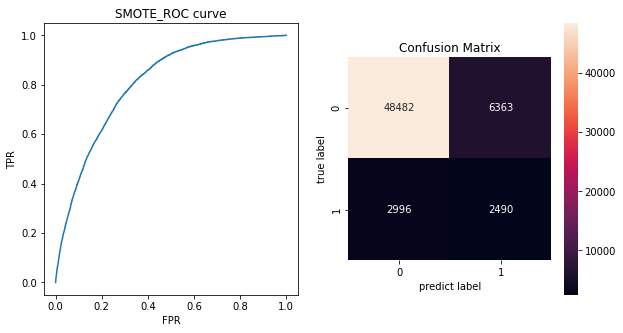

In [ ]:
#SMOTE
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          min_child_weight=2,
                          colsample_bytree=0.5)
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#BorderlineSMote
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_BorderlineSM, y_train_BorderlineSM, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_BorderlineSM, y_train_BorderlineSM), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.808178	validation_1-auc:0.778804
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.836881	validation_1-auc:0.783844
[2]	validation_0-auc:0.833745	validation_1-auc:0.786152
[3]	validation_0-auc:0.840173	validation_1-auc:0.794259
[4]	validation_0-auc:0.844424	validation_1-auc:0.79533
[5]	validation_0-auc:0.854999	validation_1-auc:0.799337
[6]	validation_0-auc:0.873428	validation_1-auc:0.810807
[7]	validation_0-auc:0.873383	validation_1-auc:0.81076
[8]	validation_0-auc:0.871588	validation_1-auc:0.808909
[9]	validation_0-auc:0.878993	validation_1-auc:0.815799
[10]	validation_0-auc:0.882786	validation_1-auc:0.814082
[11]	validation_0-auc:0.88484	validation_1-auc:0.81723
[12]	validation_0-auc:0.885856	validation_1-auc:0.819274
[13]	validation_0-auc:0.88728	validation_1-auc:0.819607
[14]	validation_0-auc:0.890885	validation_1-auc:0.820422
[15

Accuracy 0.8407783726442459
Precision 0.278494623655914
Recall 0.47211082756106454
F1 0.3503313945624239
AUC 0.8130652745664072
[[48135  6710]
 [ 2896  2590]]


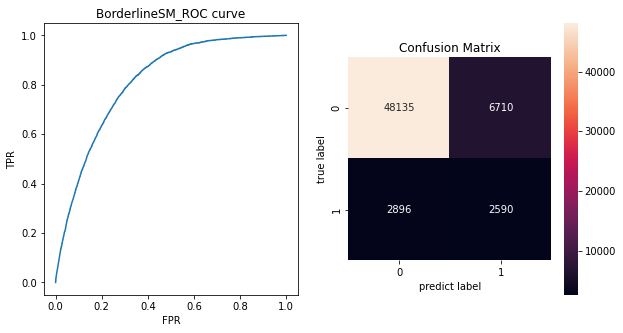

In [ ]:
#BorderlineSMote
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          min_child_weight=3,
                          colsample_bytree=0.5)
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#SVMSMote
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_SVMSMOTE, y_train_SVMSMOTE, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_SVMSMOTE, y_train_SVMSMOTE), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

Streaming output truncated to the last 5000 lines.

[0]	validation_0-auc:0.863604	validation_1-auc:0.786675
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.896847	validation_1-auc:0.812563
[2]	validation_0-auc:0.901155	validation_1-auc:0.81489
[3]	validation_0-auc:0.906064	validation_1-auc:0.820656
[4]	validation_0-auc:0.906542	validation_1-auc:0.822401
[5]	validation_0-auc:0.905922	validation_1-auc:0.821211
[6]	validation_0-auc:0.910155	validation_1-auc:0.826216
[7]	validation_0-auc:0.910702	validation_1-auc:0.82638
[8]	validation_0-auc:0.910523	validation_1-auc:0.826935
[9]	validation_0-auc:0.910902	validation_1-auc:0.827218
[10]	validation_0-auc:0.912237	validation_1-auc:0.826494
[11]	validation_0-auc:0.912185	validation_1-auc:0.826317
[12]	validation_0-auc:0.912569	validation_1-auc:0.827024
[13]	validation_0-auc:0.913142	validation_1-auc:0.827772
[14]	

In [ ]:
#SVMSMote
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          min_child_weight=2,
                          colsample_bytree=0.5)
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#ADASYN
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_ADASYN, y_train_ADASYN, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_ADASYN, y_train_ADASYN), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

In [ ]:
#ADASYN
model = xgb.XGBClassifier()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
#SMOTEENN
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_SMOTEENN, y_train_SMOTEENN, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_SMOTEENN, y_train_SMOTEENN), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

In [ ]:
#costsensitive
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


model = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.783845	validation_1-auc:0.787283
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.80111	validation_1-auc:0.803733
[2]	validation_0-auc:0.798861	validation_1-auc:0.801549
[3]	validation_0-auc:0.805004	validation_1-auc:0.807904
[4]	validation_0-auc:0.807518	validation_1-auc:0.810372
[5]	validation_0-auc:0.811187	validation_1-auc:0.813989
[6]	validation_0-auc:0.823924	validation_1-auc:0.825653
[7]	validation_0-auc:0.824873	validation_1-auc:0.826826
[8]	validation_0-auc:0.823882	validation_1-auc:0.825893
[9]	validation_0-auc:0.829025	validation_1-auc:0.830713
[10]	validation_0-auc:0.828165	validation_1-auc:0.830073
[11]	validation_0-auc:0.830041	validation_1-auc:0.831585
[12]	validation_0-auc:0.831428	validation_1-auc:0.832968
[13]	validation_0-auc:0.832648	validation_1-auc:0.834215
[14]	validation_0-auc:0.832863	validation_1-auc:0.834389

Accuracy 0.7417579685402198
Precision 0.23002032737776826
Recall 0.7838133430550492
F1 0.35566583953680725
AUC 0.8396801651637016
[[40451 14394]
 [ 1186  4300]]


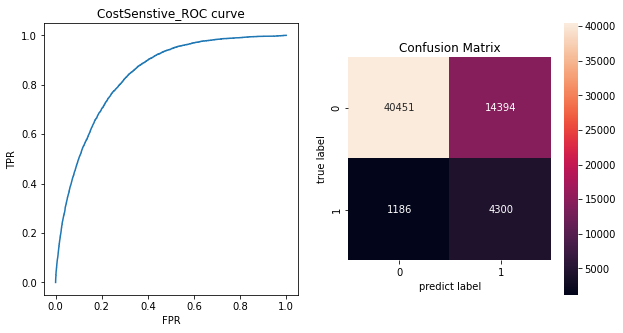

In [ ]:
import xgboost as xgb
from sklearn import metrics

#Costsensitive
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          min_child_weight=3,
                          colsample_bytree=0.5,
                          scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

# **PDP**

In [ ]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 123 kB/s 
     |████████████████████████████████| 13.1 MB 25.1 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=29e066c1730799142ad23858c7213a1067bada8dd8e6a3db23566af2d175bdd3
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 41.2 MB/s 


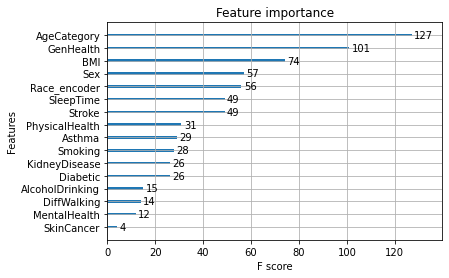

In [ ]:
#피처 중요도 - 모델의 에러를 얼마나 줄여주는지를 근거로 중요성을 측정하는 방법
##Costsensitive
from xgboost import plot_importance
import xgboost as xgb

model = xgb.XGBClassifier(scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)

plot_importance(model)

plt.yticks()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


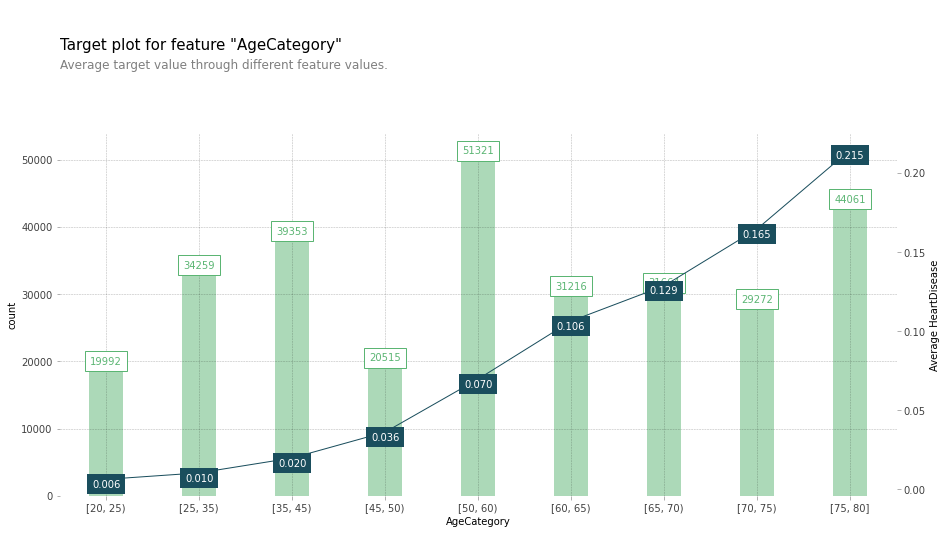

In [ ]:
#X축은 나이 카테고리, 왼쪽 Y축은 각 카테고리별 데이터 개수, 오른쪽 Y축은 당뇨병 진단 여부
#막대그래프는 왼쪽 Y축에 대응하고, 꺽은선 그래프는 오른쪽 Y축에 대응

##나이
#목표 플롯 -> 나이가 많을수록 심장병에 걸린 사람이 많다.
from pdpbox import info_plots


pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'AgeCategory',
            feature_name = 'AgeCategory',
            target = pima_target)

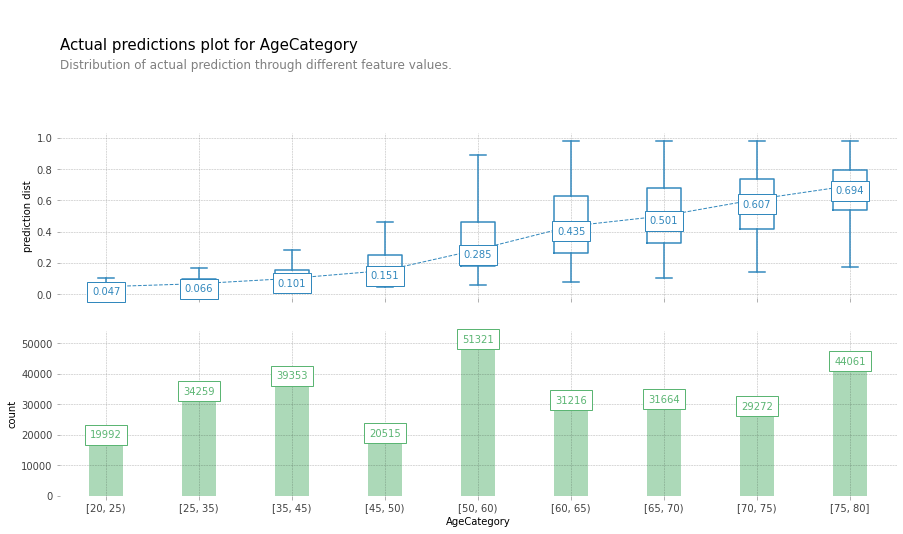

In [ ]:
#예측분포차트와 비교

fig, axes, summary_df = info_plots.actual_plot(
            model = model,
            X = pima_data[pima_features],
            feature = 'AgeCategory',
            feature_name = 'AgeCategory', 
            predict_kwds = {}
            )

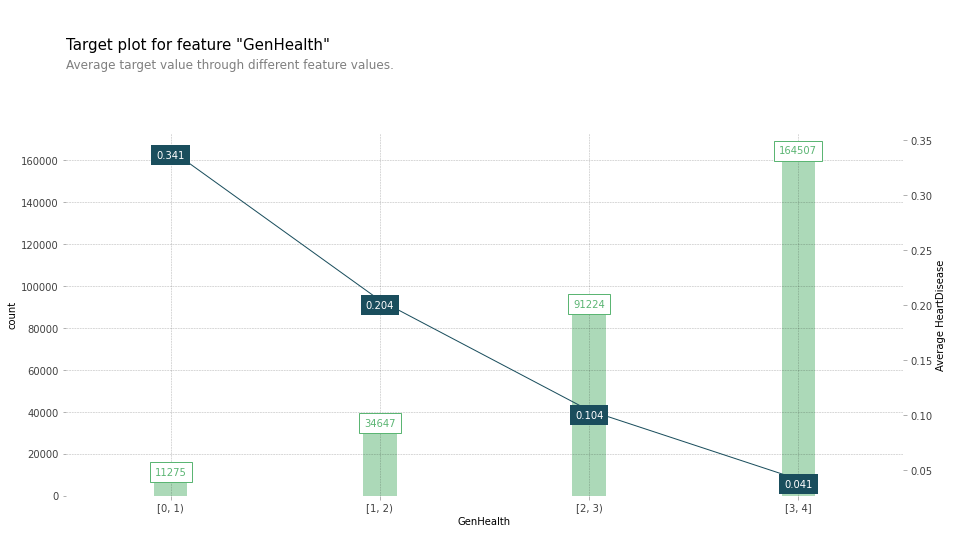

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#일반적으로 건강이 좋지 않을수록 심장병에 걸린 사람이 많다.
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'GenHealth',
            feature_name = 'GenHealth',
            target = pima_target)
#'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0

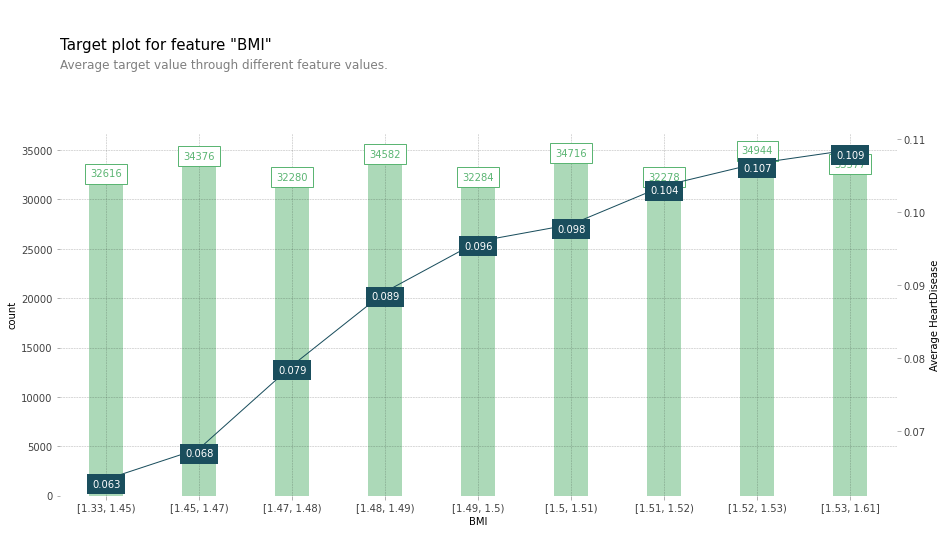

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#BMI지수가 높을수록 심장병에 걸린 사람이 많다.
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'BMI',
            feature_name = 'BMI',
            target = pima_target)

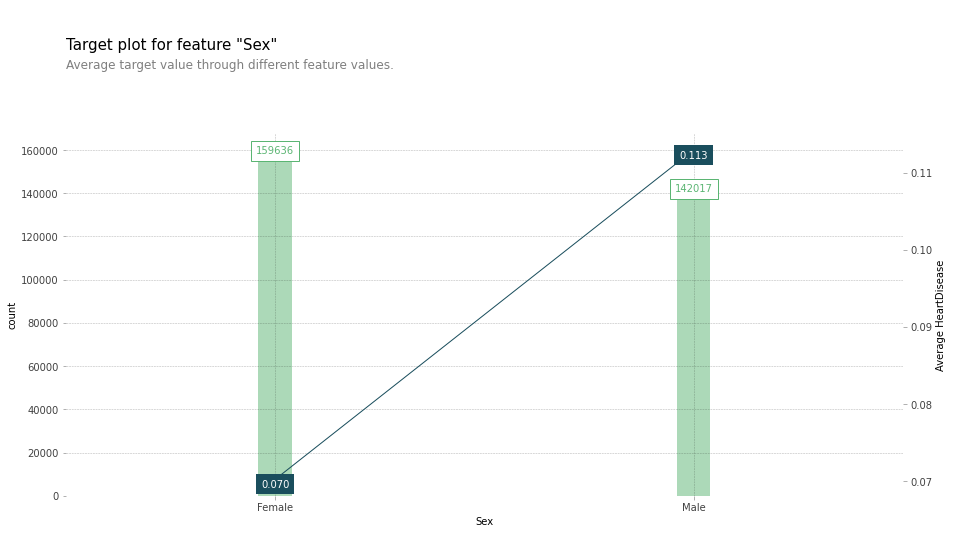

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#여성보다 남성이 심장병에 걸린 사람이 많다.
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'Sex',
            feature_name = 'Sex',
            target = pima_target)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

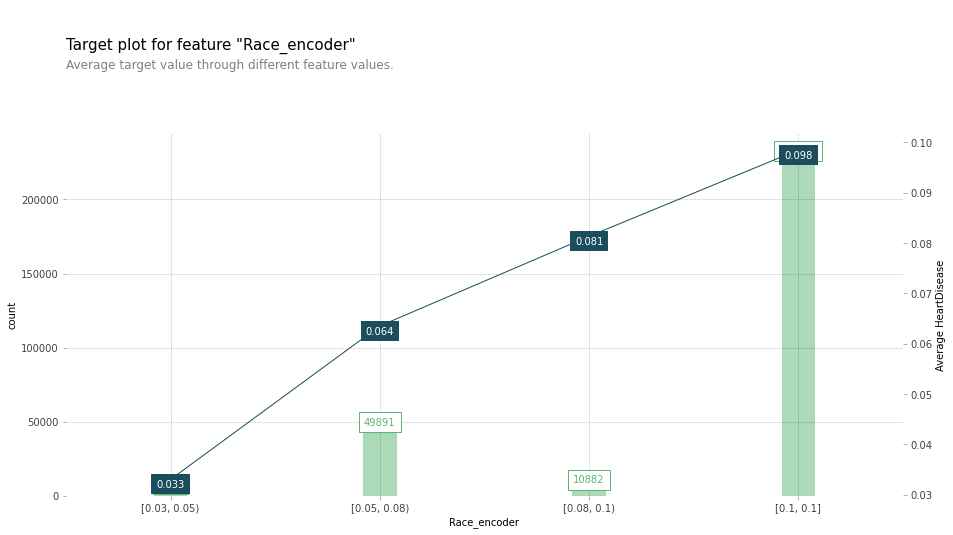

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'Race_encoder',
            feature_name = 'Race_encoder',
            target = pima_target)

#0.0983399209486166
#0.07572168114416074
#0.03303716681266425
#0.10445172480246676
#0.08132696195552289
#0.053253127652507656
#White, Black, Asian, Other, Hispanic

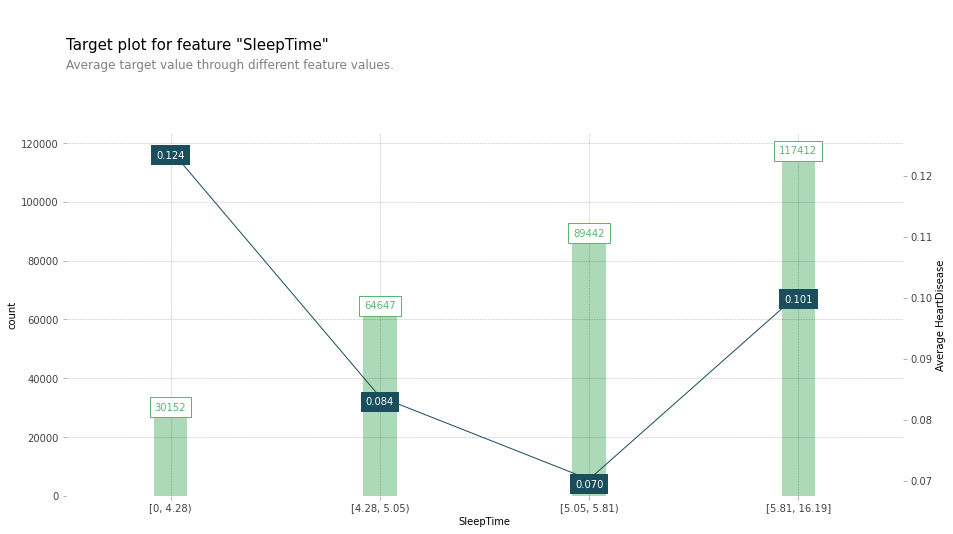

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#심하게 적게 자는 사람 중에 심장병 걸린 사람 많음. 그 다음이 심하게 많이 자는 사람
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'SleepTime',
            feature_name = 'SleepTime',
            target = pima_target)

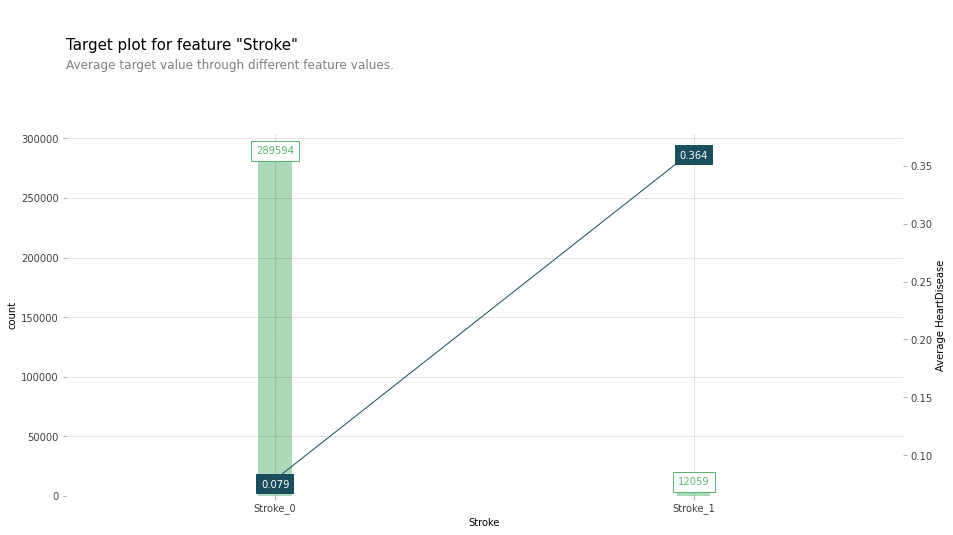

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#Stroke를 y로 두는 것도 나쁘지 않을지도..
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'Stroke',
            feature_name = 'Stroke',
            target = pima_target)

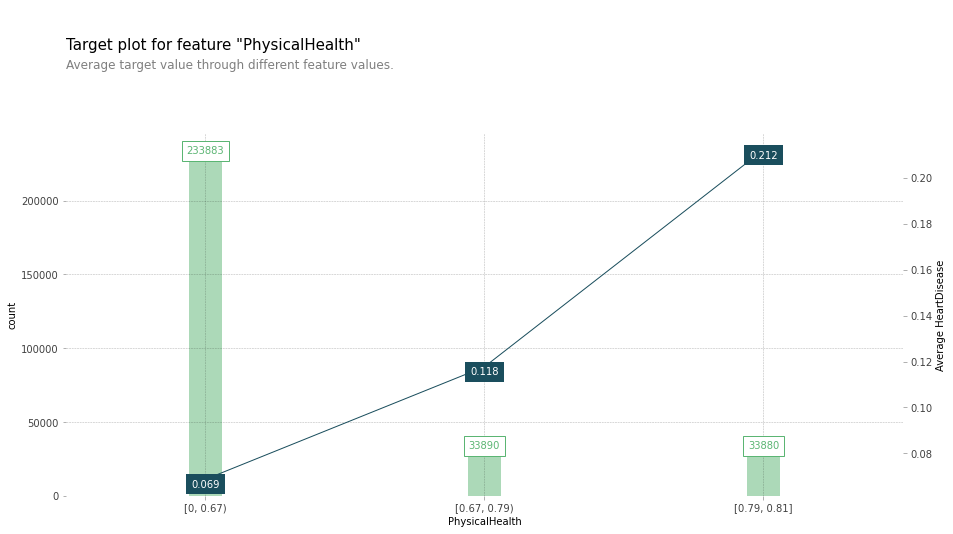

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'PhysicalHealth',
            feature_name = 'PhysicalHealth',
            target = pima_target)

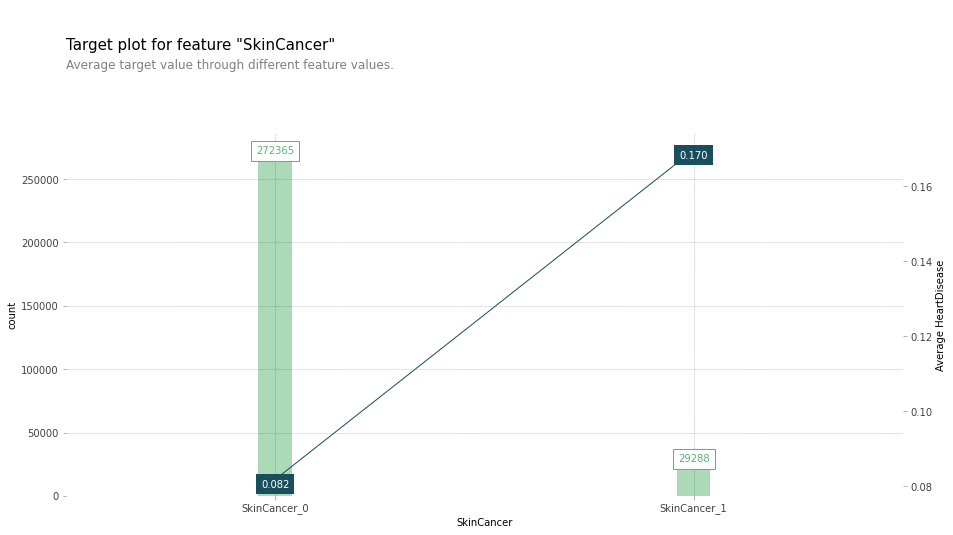

In [ ]:
pima_data = df.copy()
pima_features = x.columns
pima_target = y.name

#
fig, axes, summary_df = info_plots.target_plot(
            df = pima_data,
            feature = 'SkinCancer',
            feature_name = 'SkinCancer',
            target = pima_target)

## 피처분리








In [ ]:
from pdpbox import pdp
import shap

#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime', 'Race_encoder']
features = x_test.columns

print(x_test.columns)

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_encoder'],
      dtype='object')


## Costsensitive

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(scale_pos_weight=10)
model.fit(x_train, y_train)

XGBClassifier(scale_pos_weight=10)

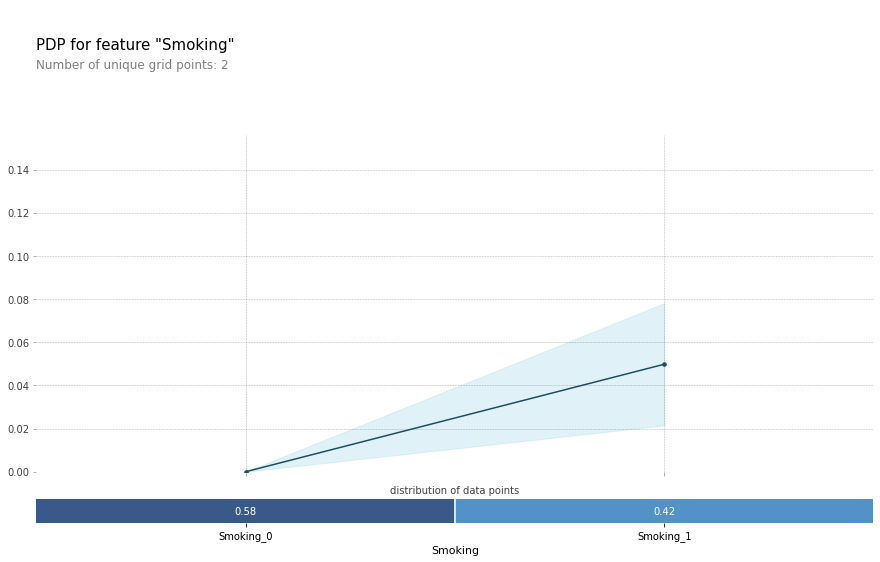

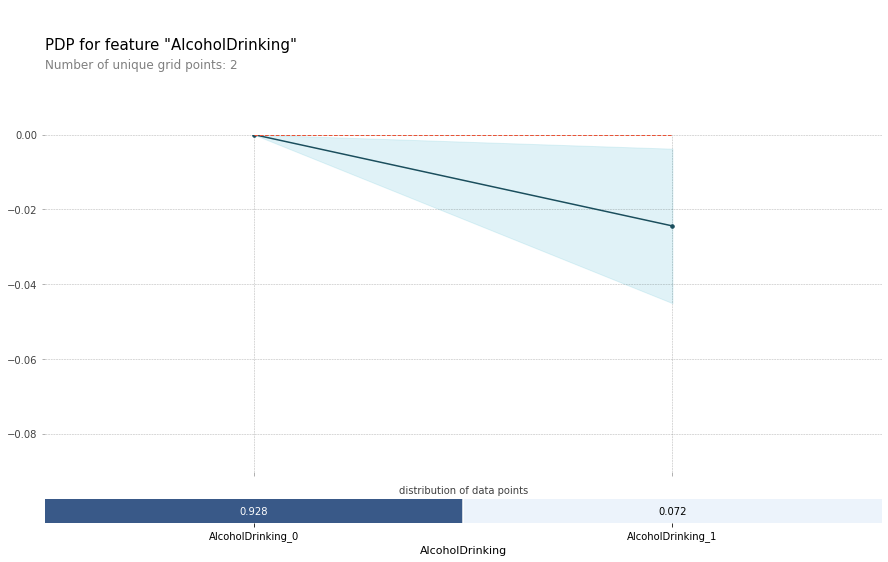

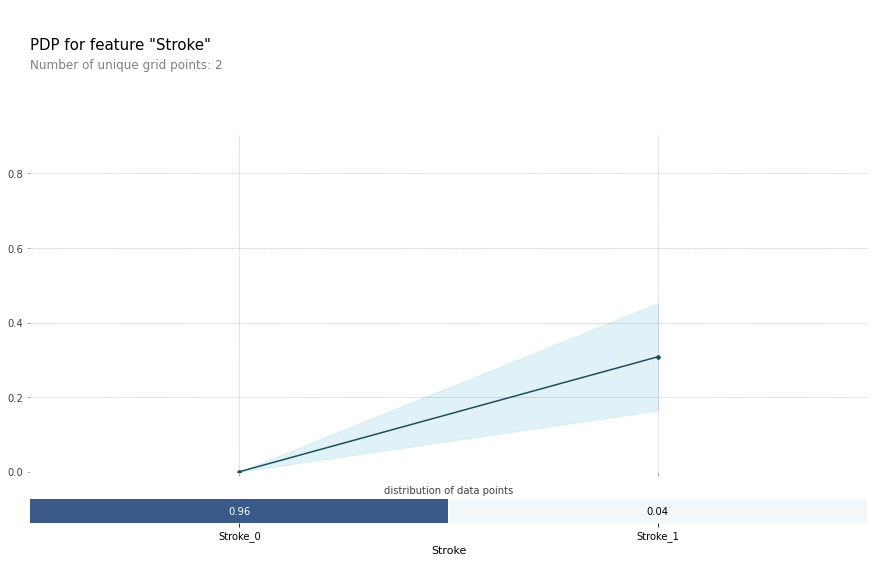

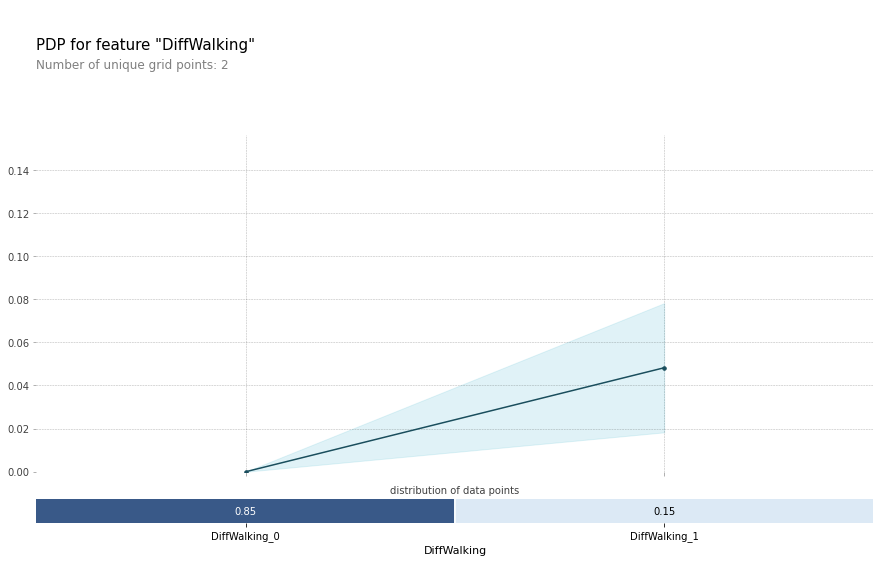

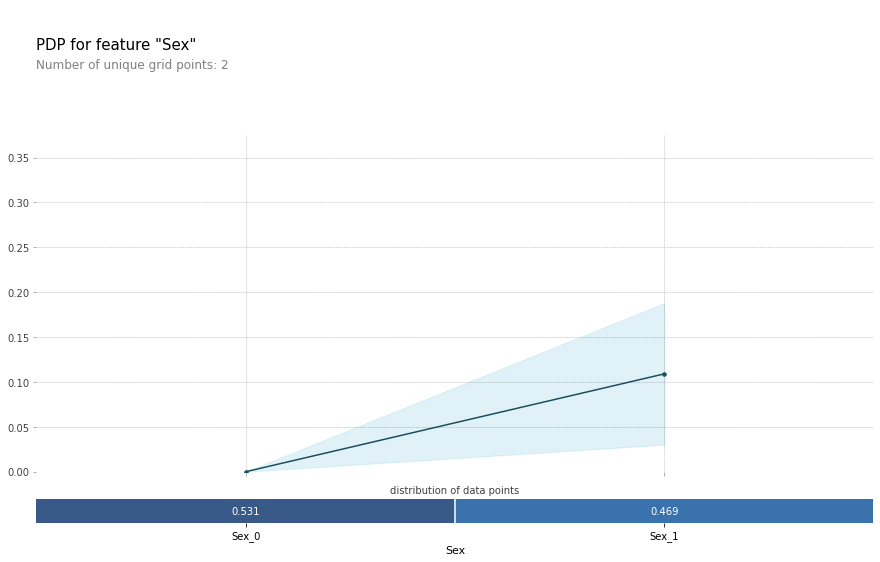

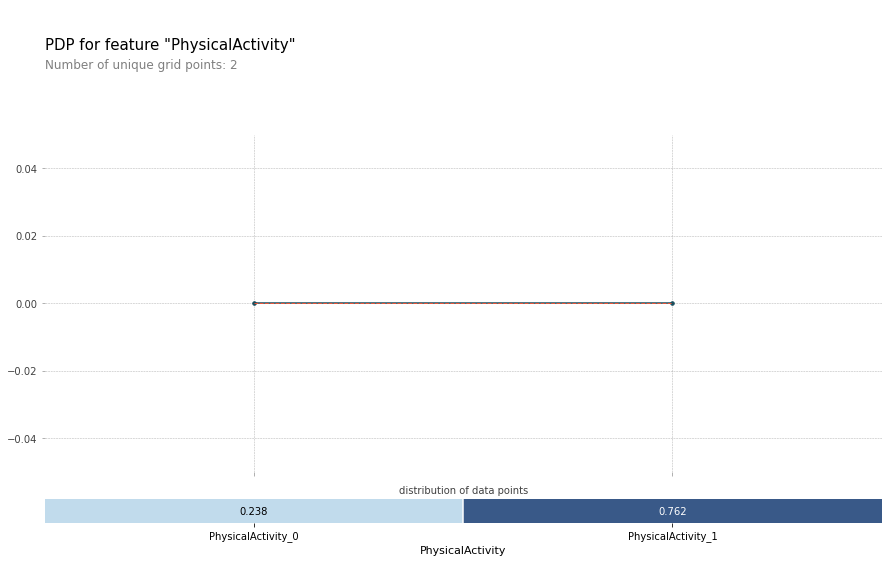

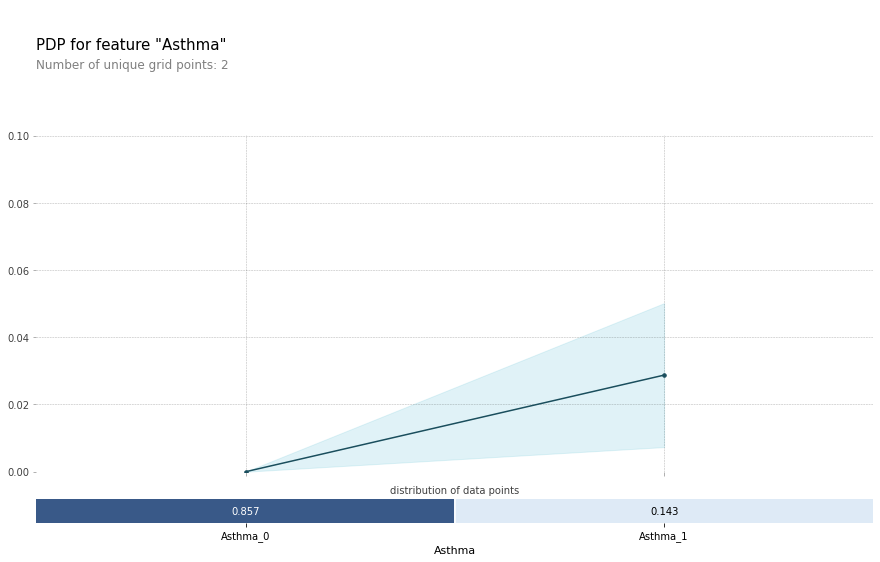

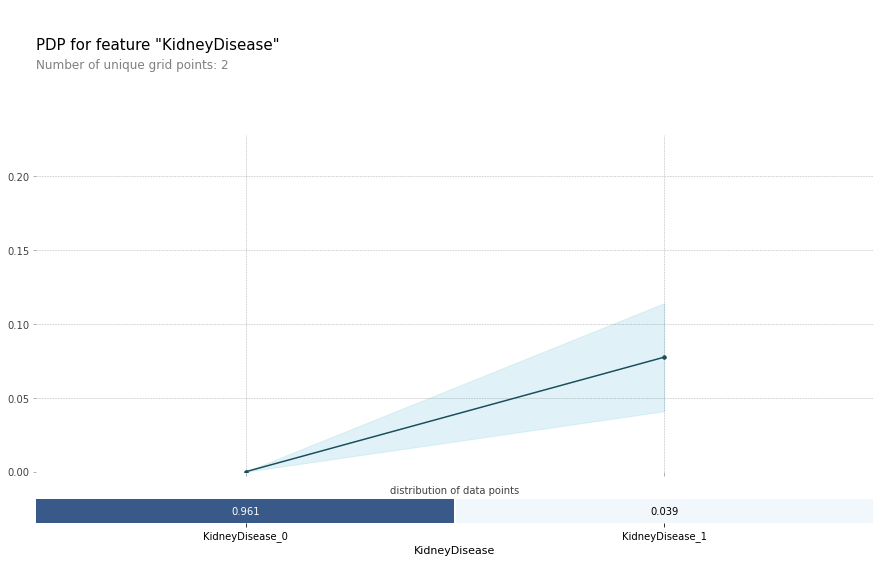

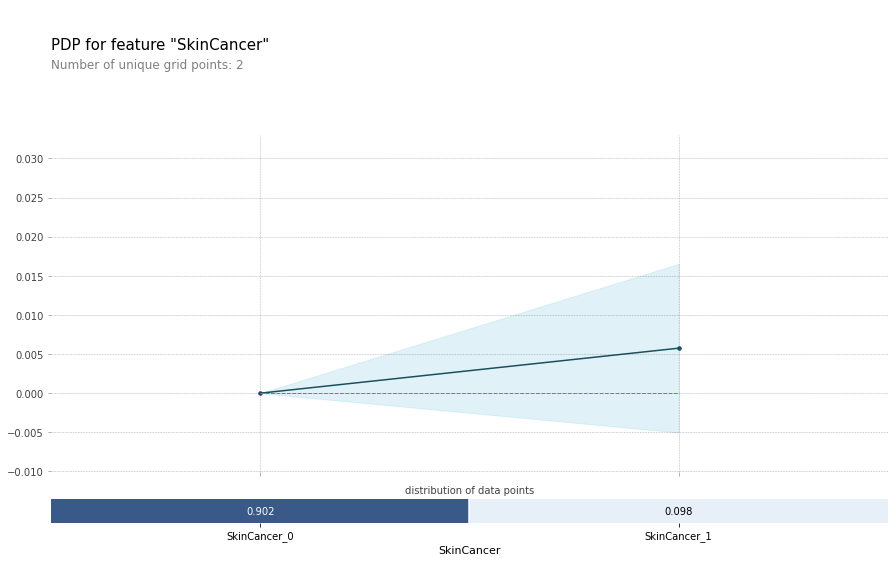

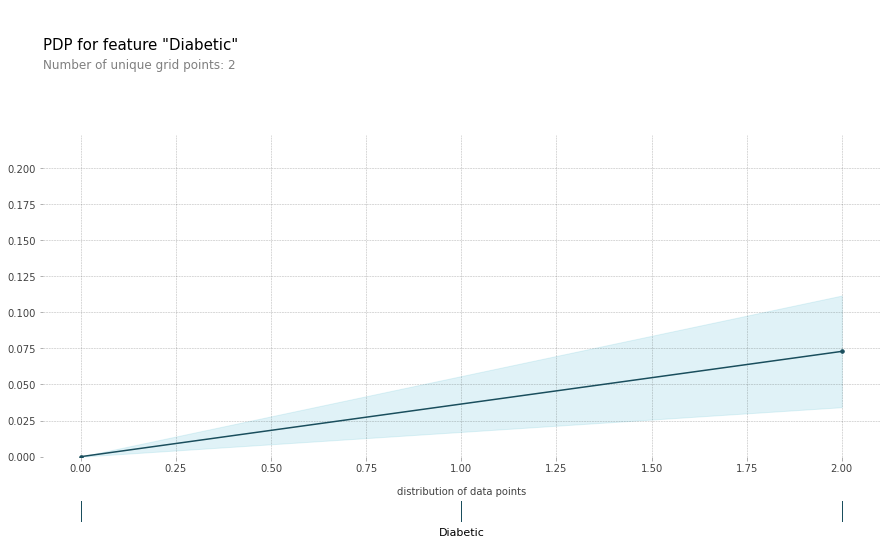

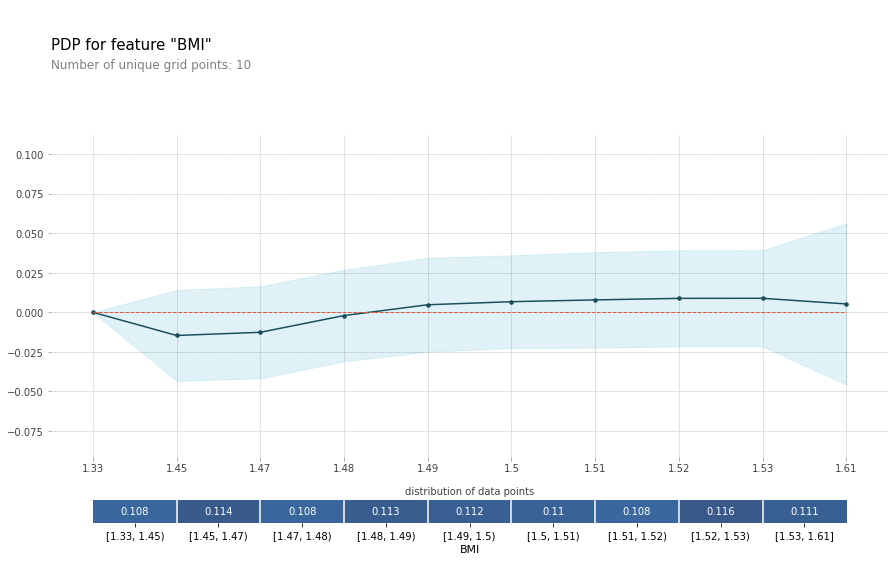

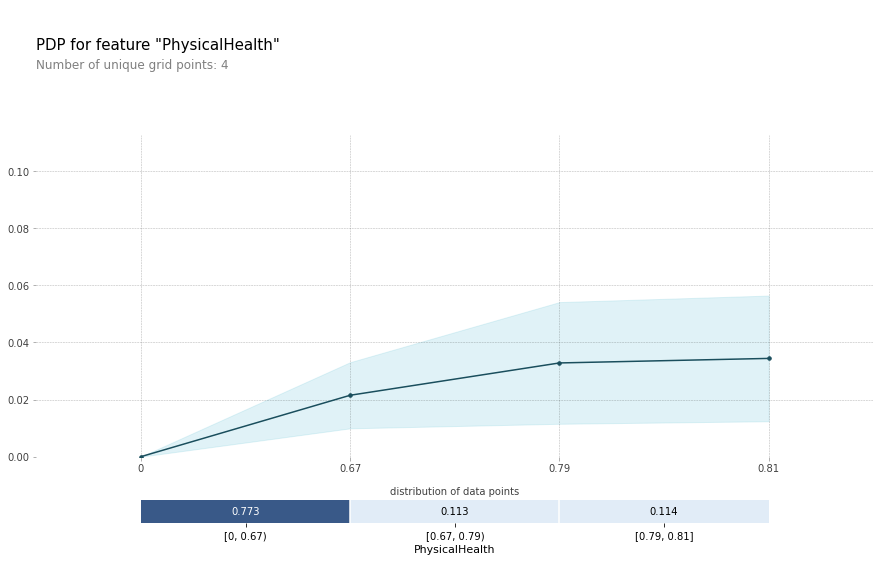

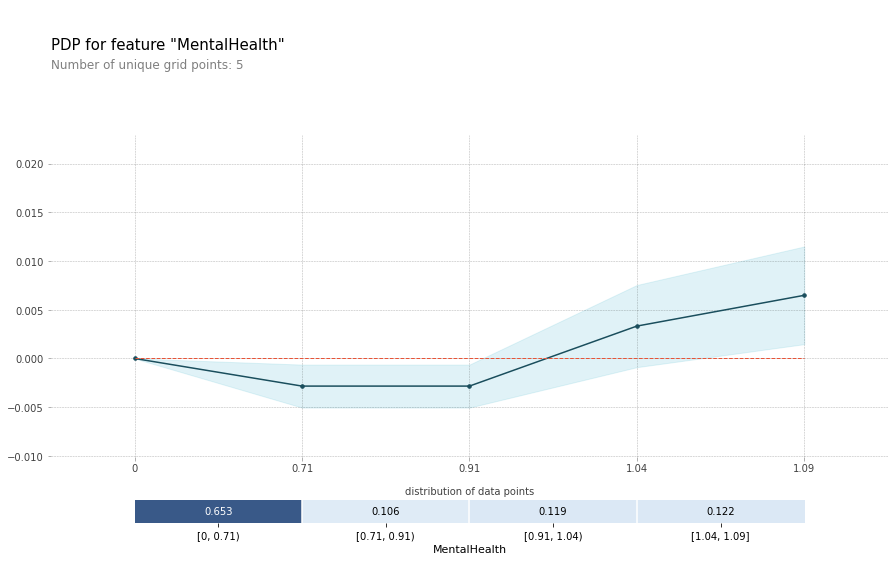

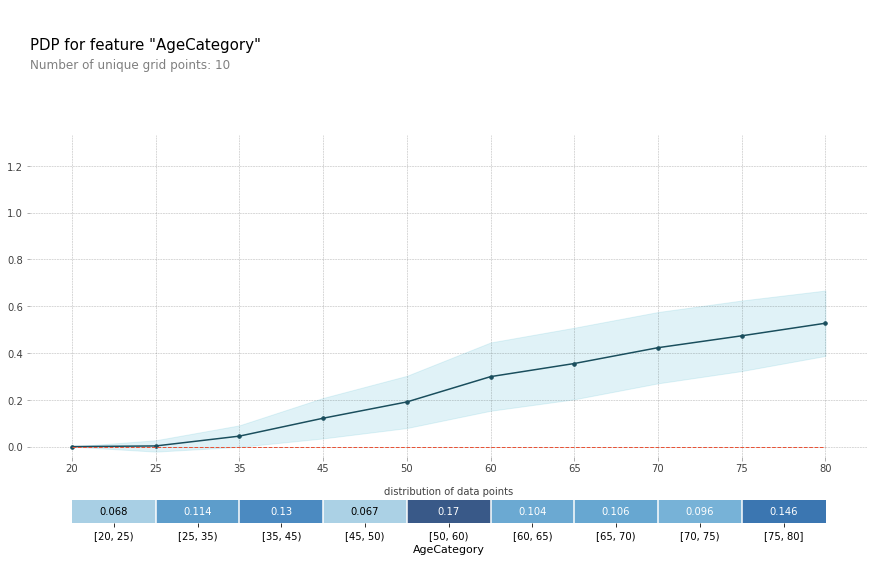

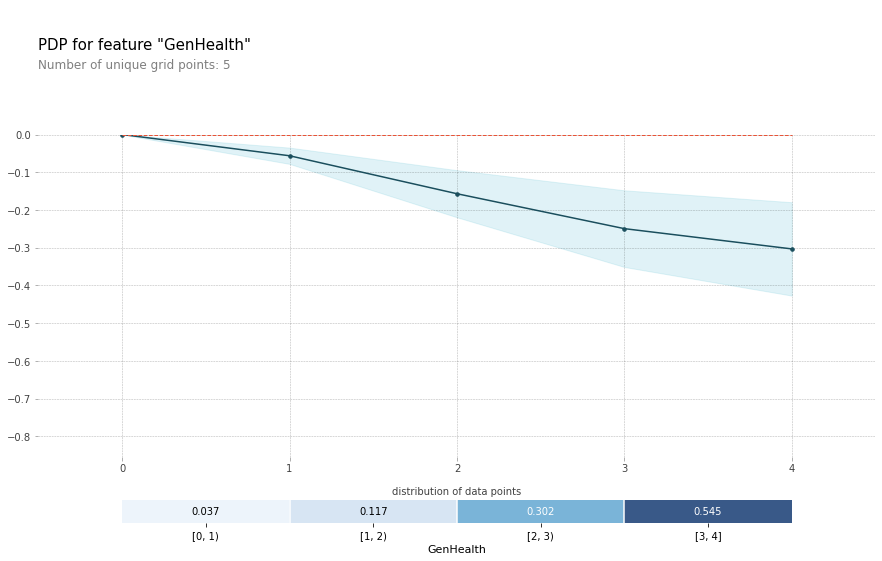

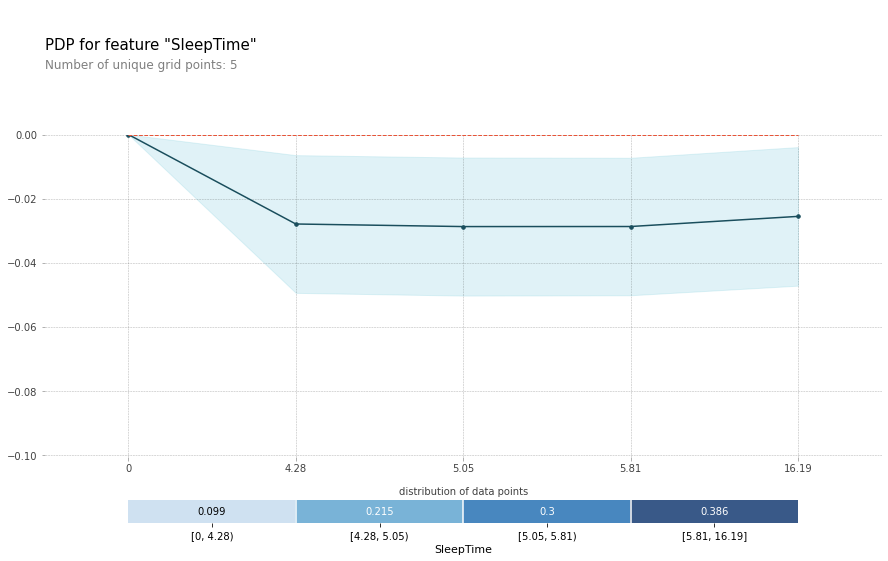

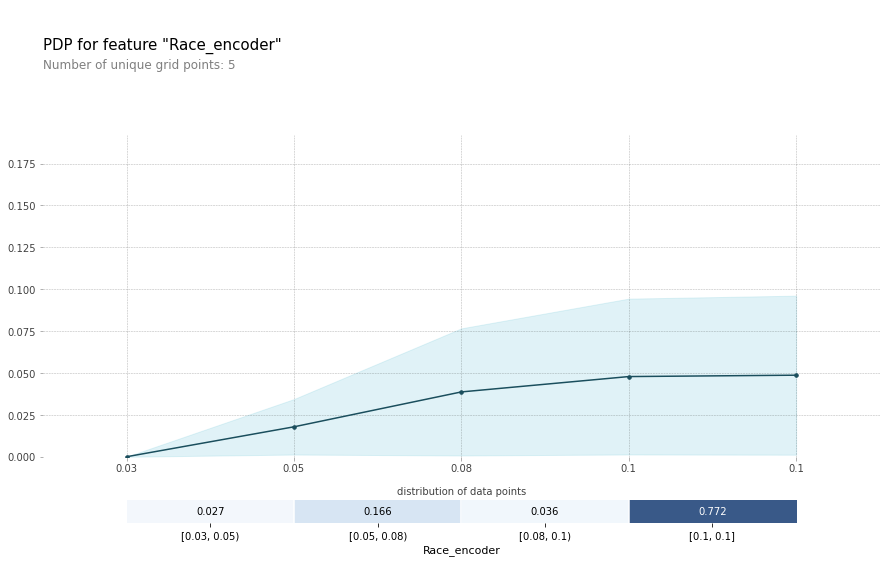

In [ ]:
#costsensitive pdp
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

#0.03303716681266425
#0.053253127652507656
#0.07572168114416074
#0.08132696195552289
#0.0983399209486166
#0.10445172480246676
#Asian, Hispanic, Other, Black, White

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(x_test.columns)):
  for j in range(i+1,len(x_test.columns)):
    in_features = [features[i], features[j]]

    interaction = pdp.pdp_interact(
        model=model, 
        dataset=x_test,
        model_features=features, 
        features=in_features
    )

    pdp.pdp_interact_plot(interaction, plot_type='grid', 
                      feature_names=in_features)
#예) BMI지수가 높고 나이가 80이상일 때 65%의 확률로 심장병이라고 진단한다.

Output hidden; open in https://colab.research.google.com to view.

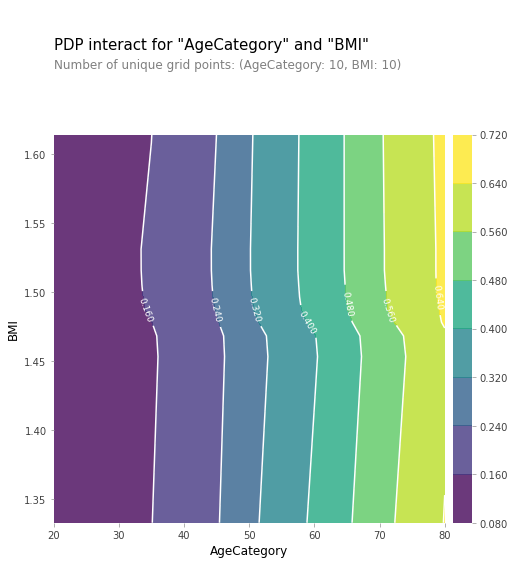

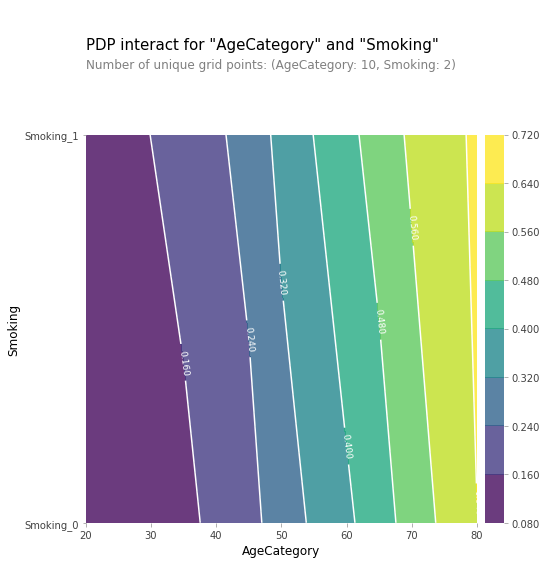

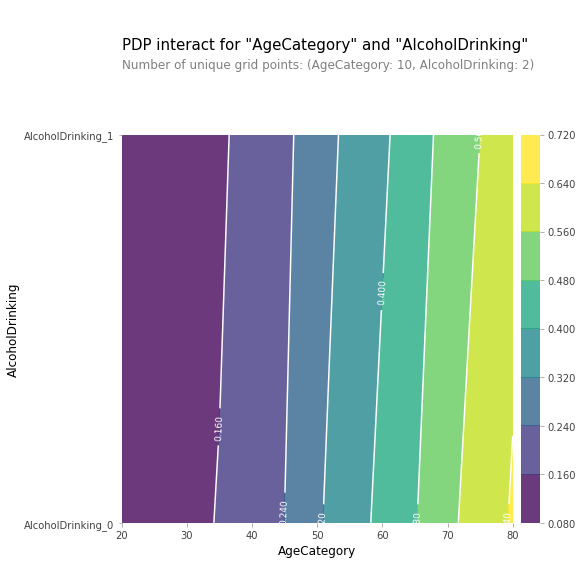

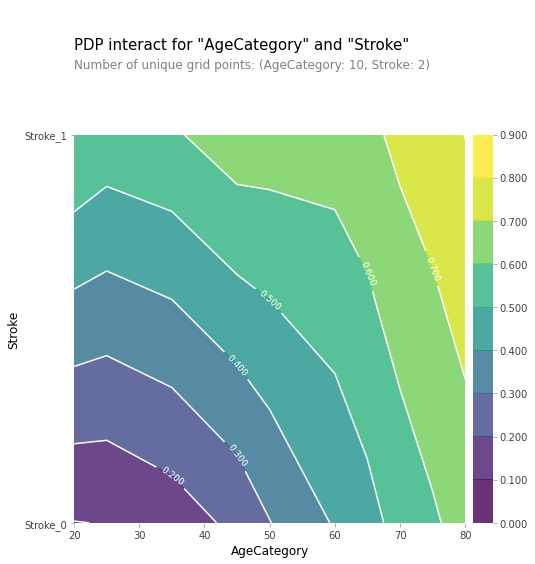

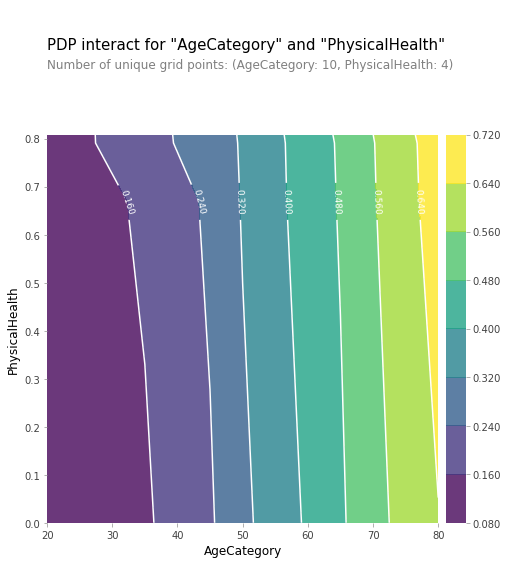

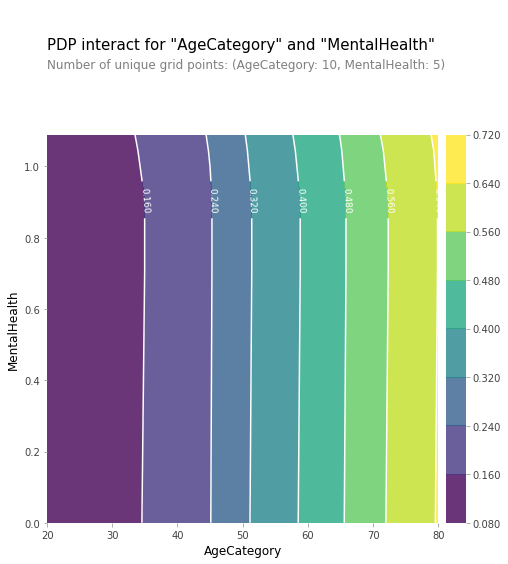

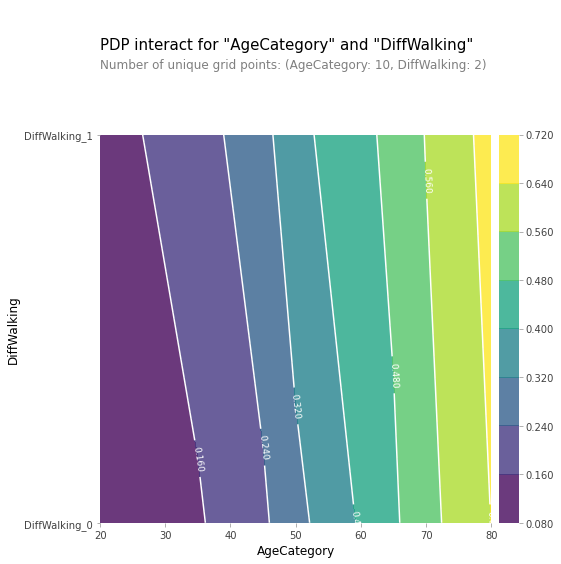

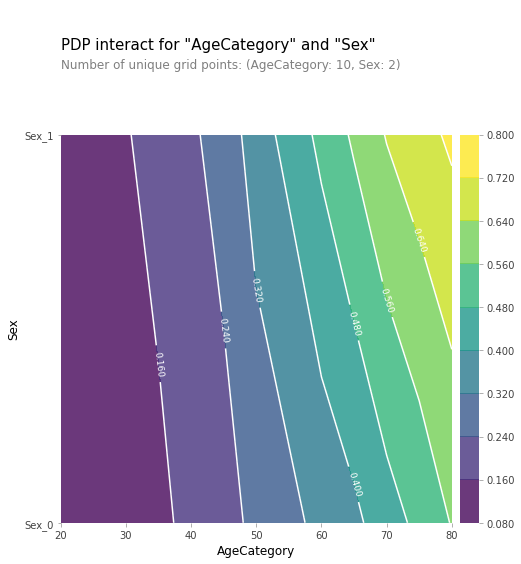

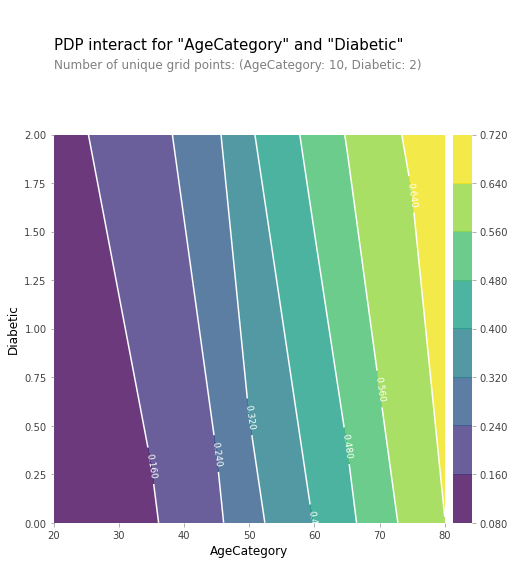

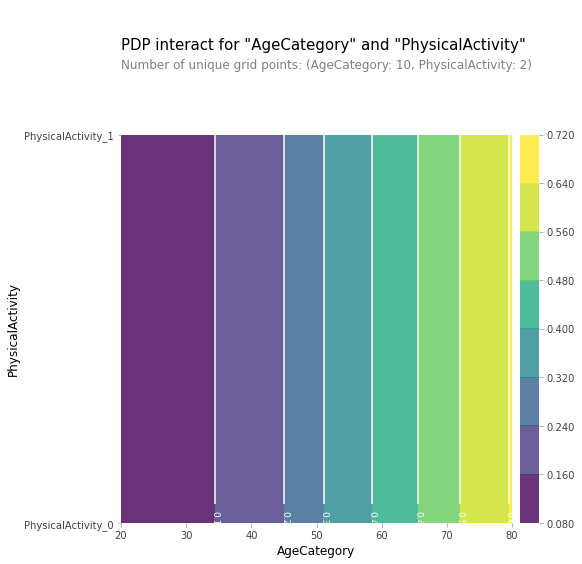

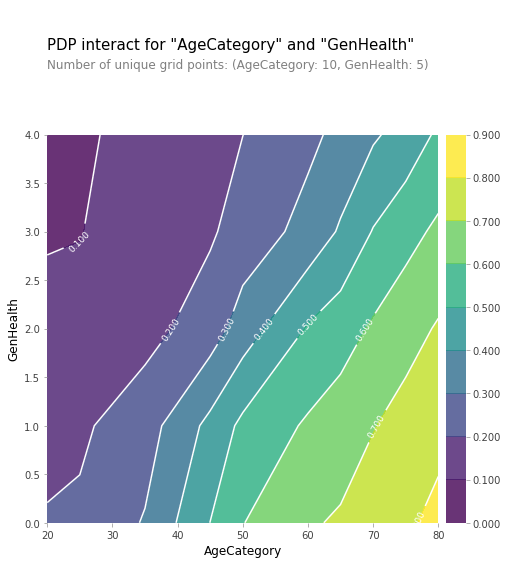

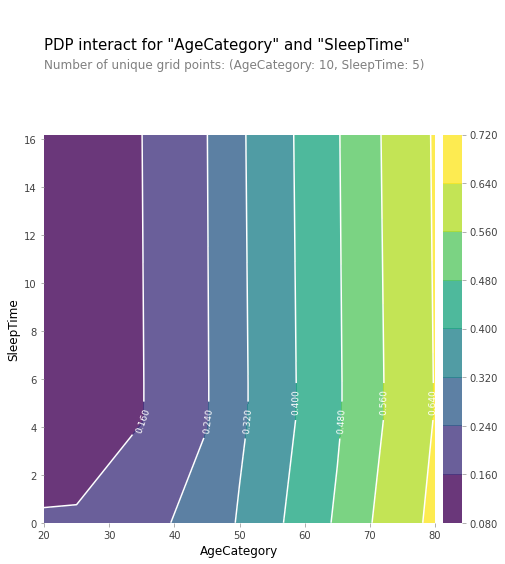

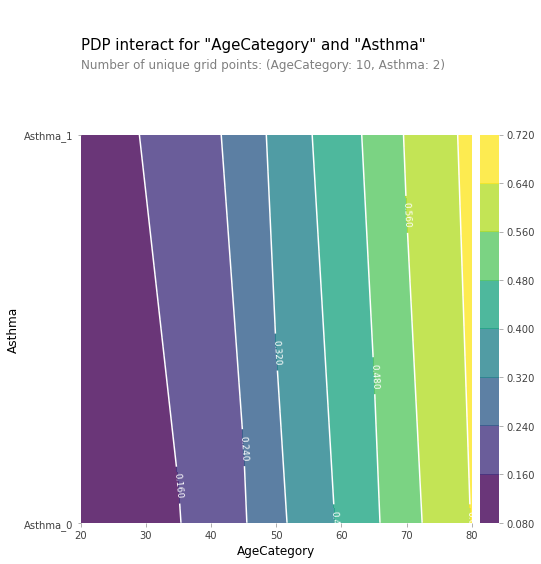

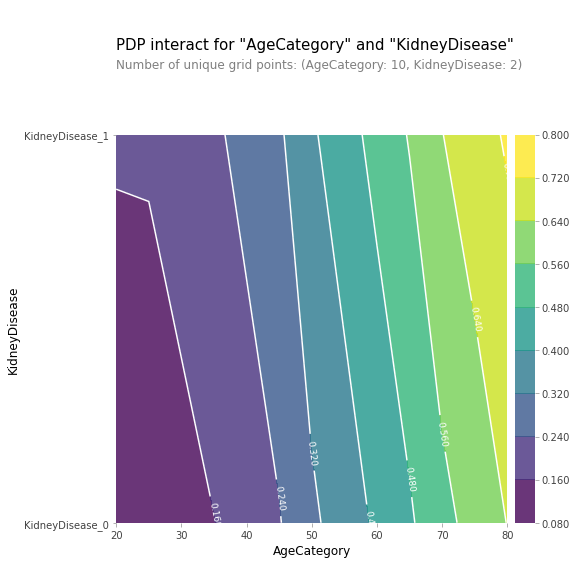

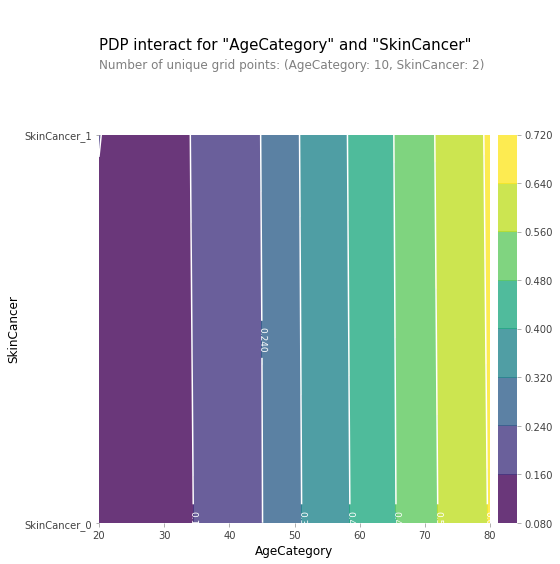

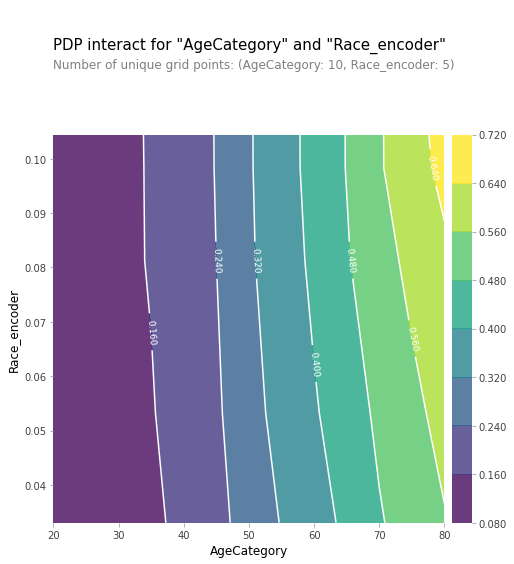

In [ ]:
for i in ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'Diabetic',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_encoder']:
  in_features = ['AgeCategory', i]

  interaction = pdp.pdp_interact(
      model=model, 
      dataset=x_test,
      model_features=features, 
      features=in_features
  )

  pdp.pdp_interact_plot(interaction, plot_type='contour', ncols=2,
                    feature_names=in_features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa6eff71a10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa6f27c5f90>})

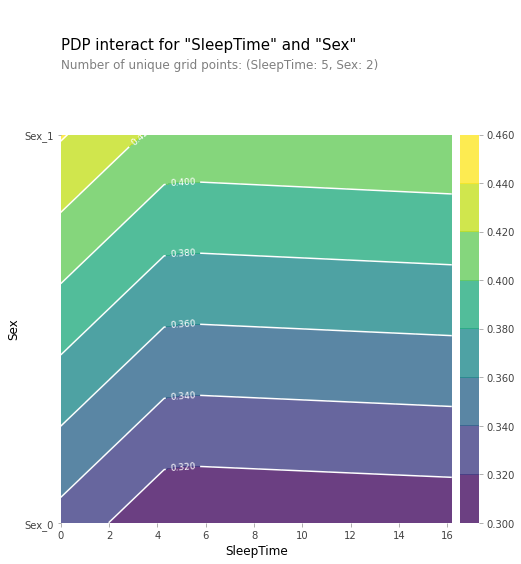

In [ ]:
in_features = ['SleepTime', 'Sex']

interaction = pdp.pdp_interact(
    model=model, 
    dataset=x_test,
    model_features=features, 
    features=in_features
)

pdp.pdp_interact_plot(interaction, plot_type='contour', ncols=2,
                  feature_names=in_features)

100%|===================| 60255/60331 [06:19<00:00]       

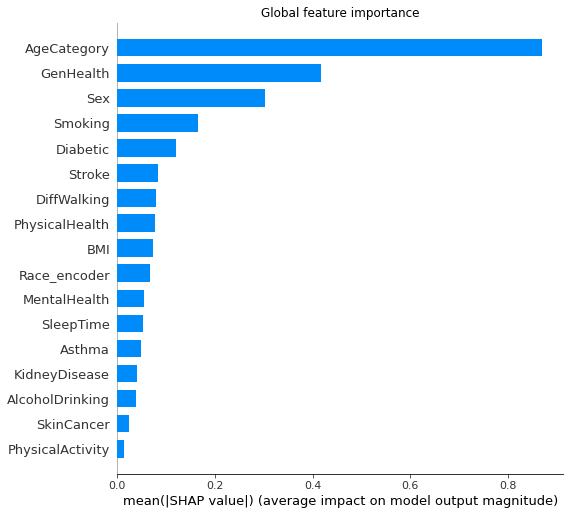

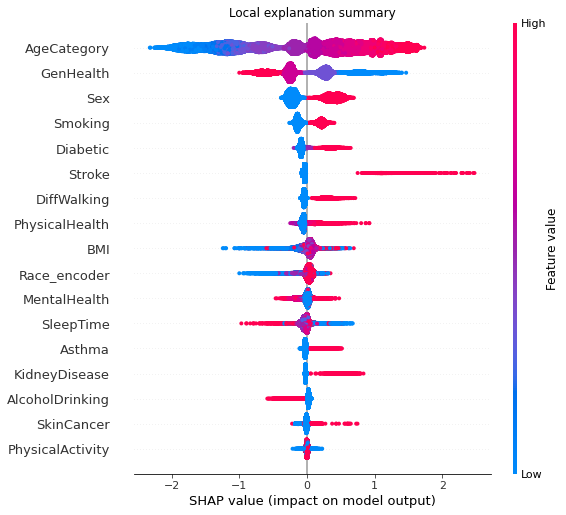

In [ ]:
# SHAP
explainer = shap.Explainer(model, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTE

In [ ]:
import xgboost as xgb

model_SMOTE = xgb.XGBClassifier()
model_SMOTE.fit(x_train_SMOTE, y_train_SMOTE)

XGBClassifier()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


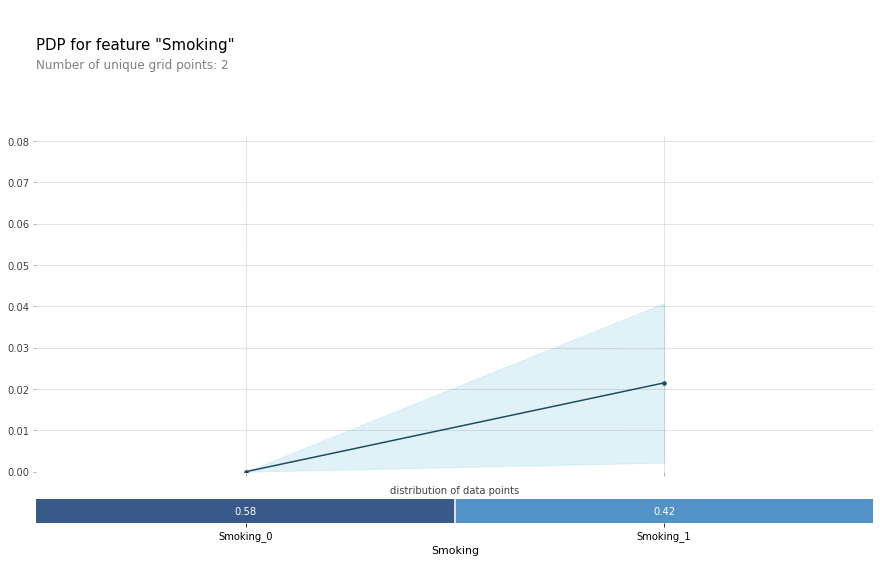

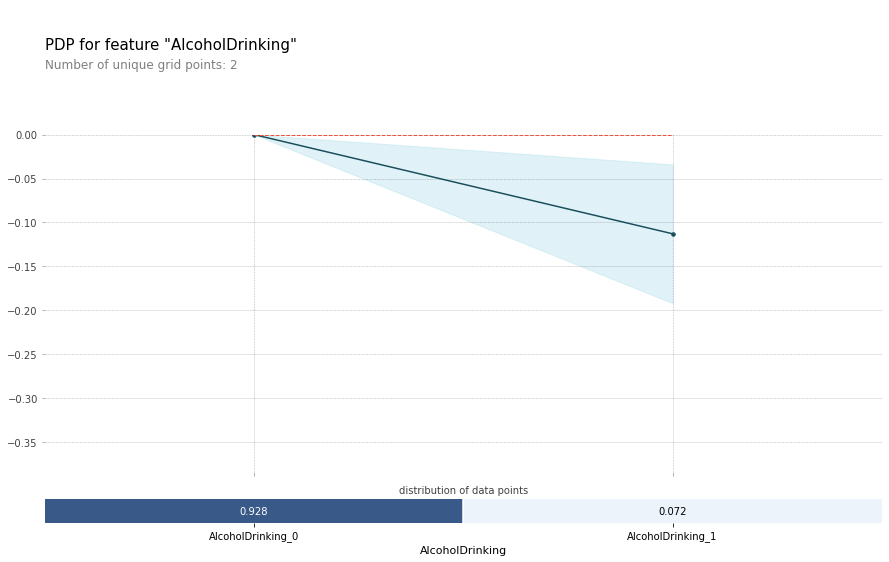

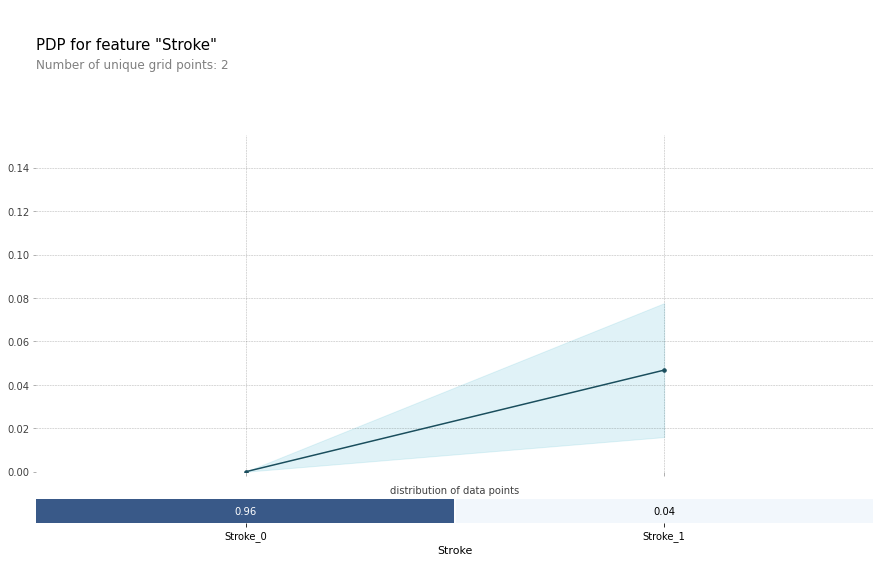

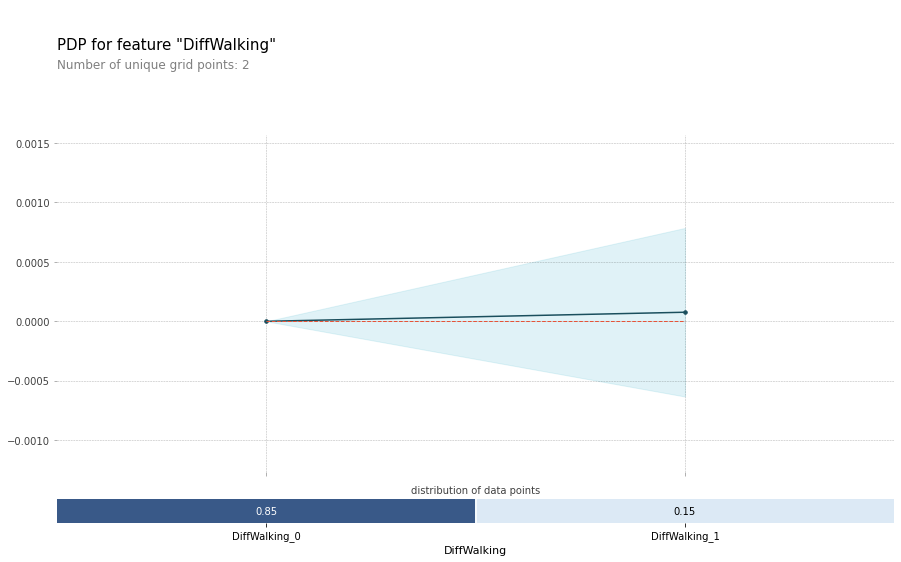

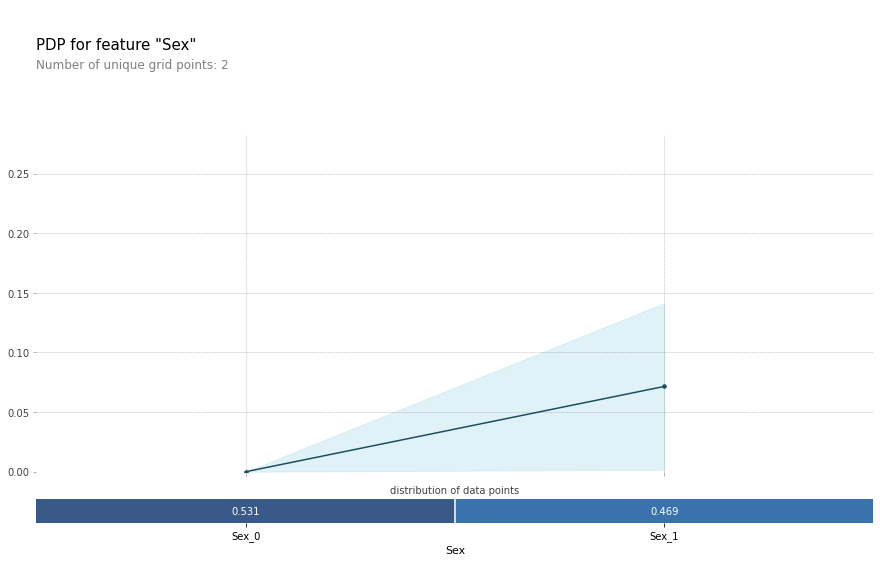

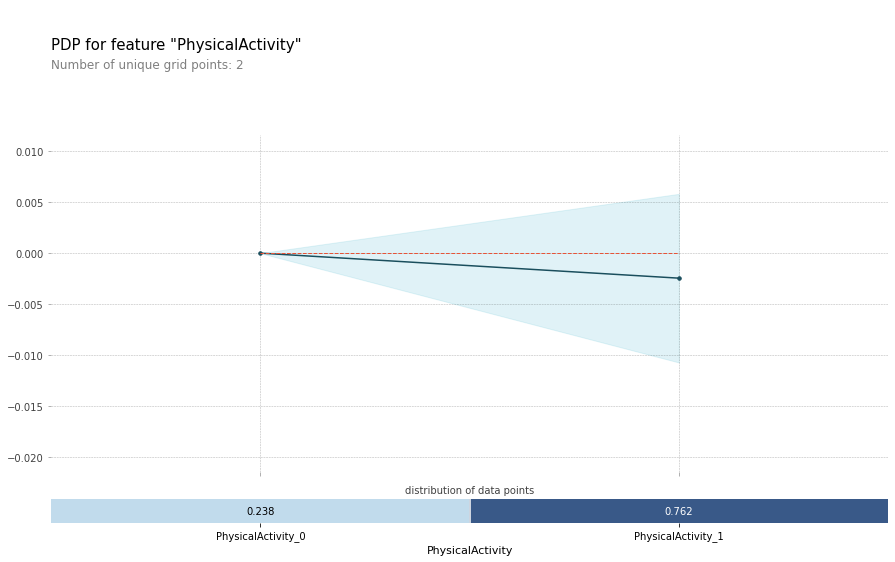

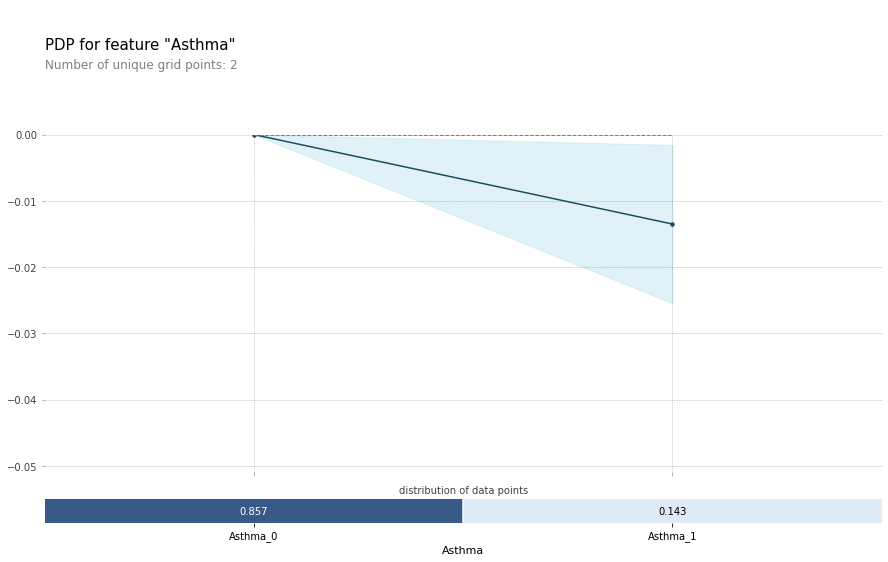

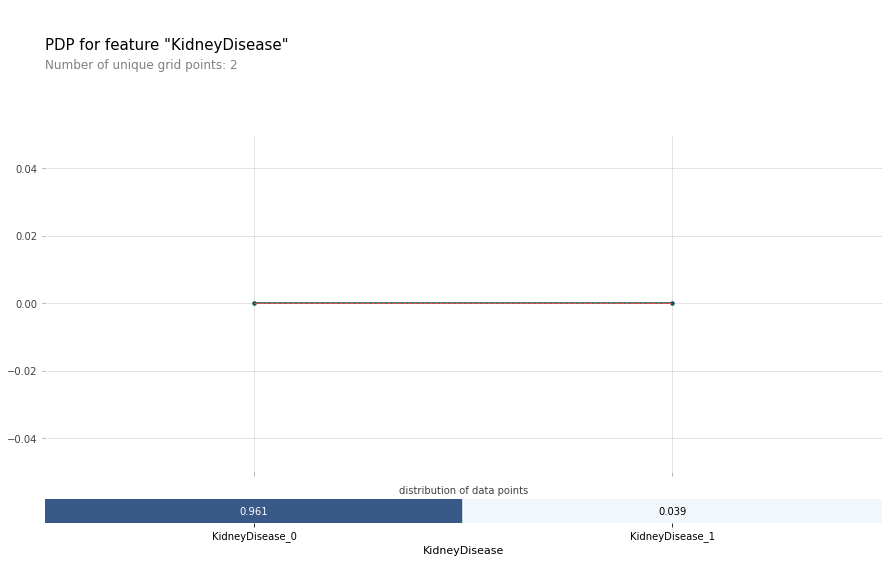

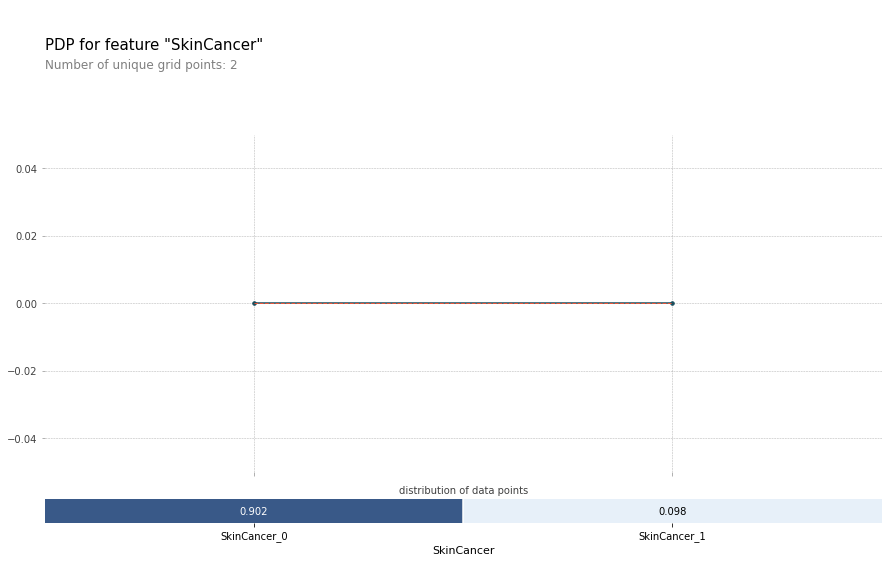

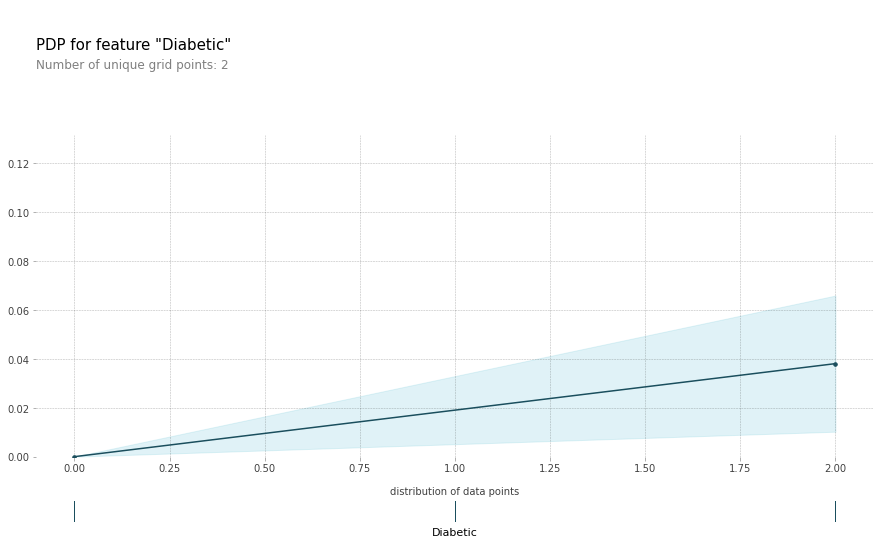

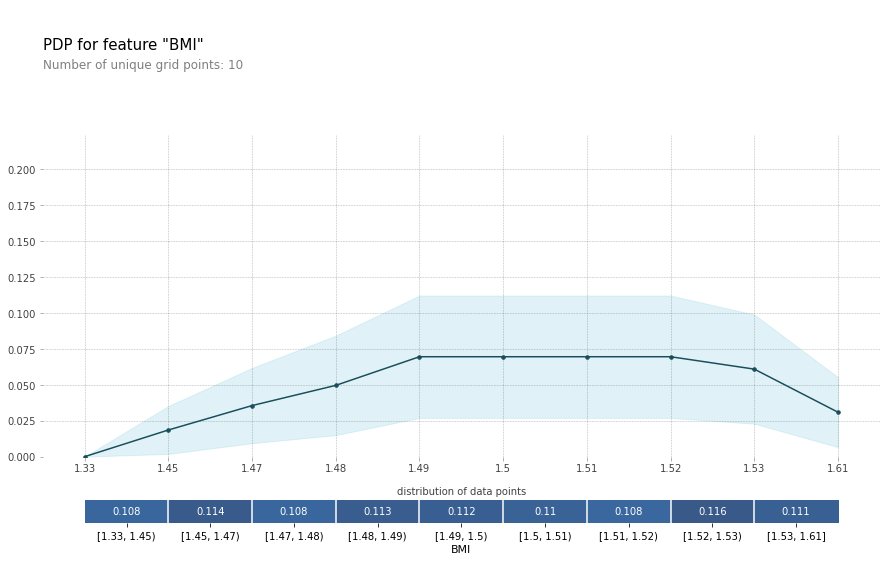

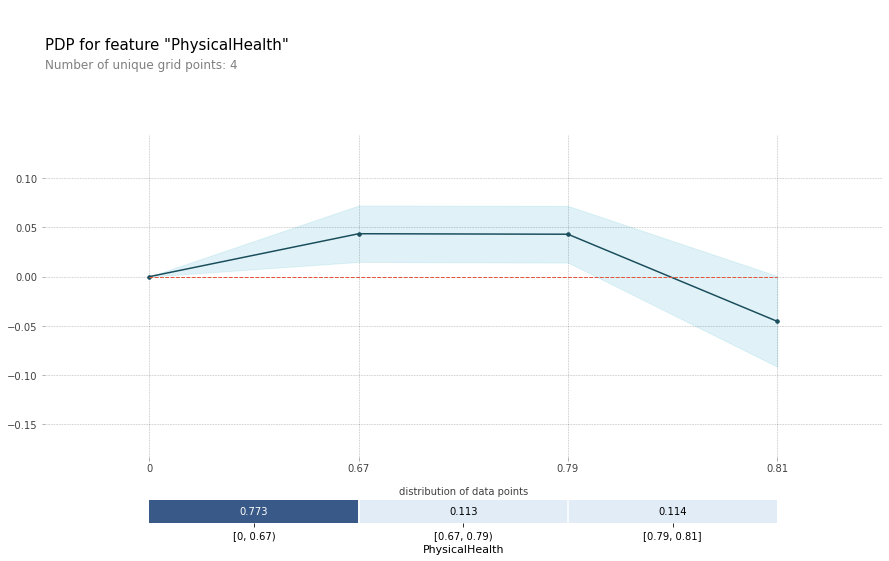

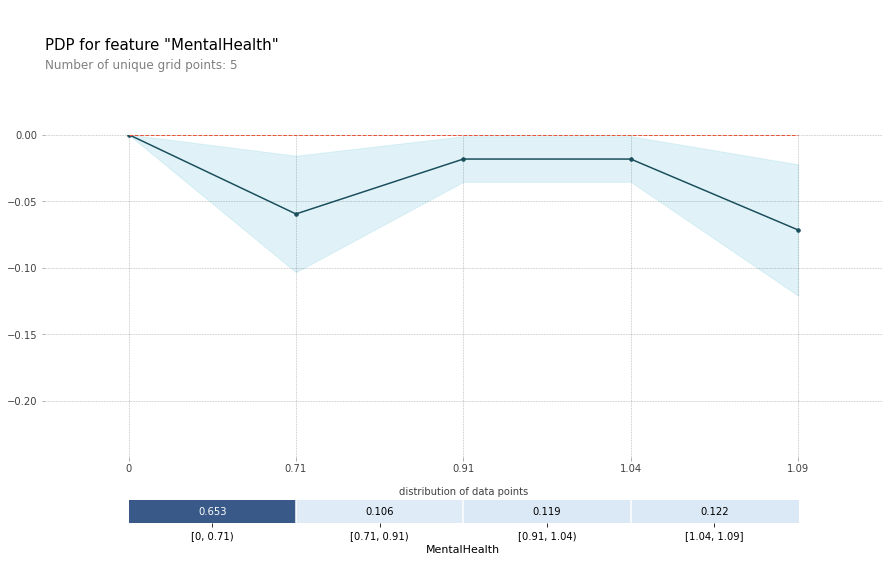

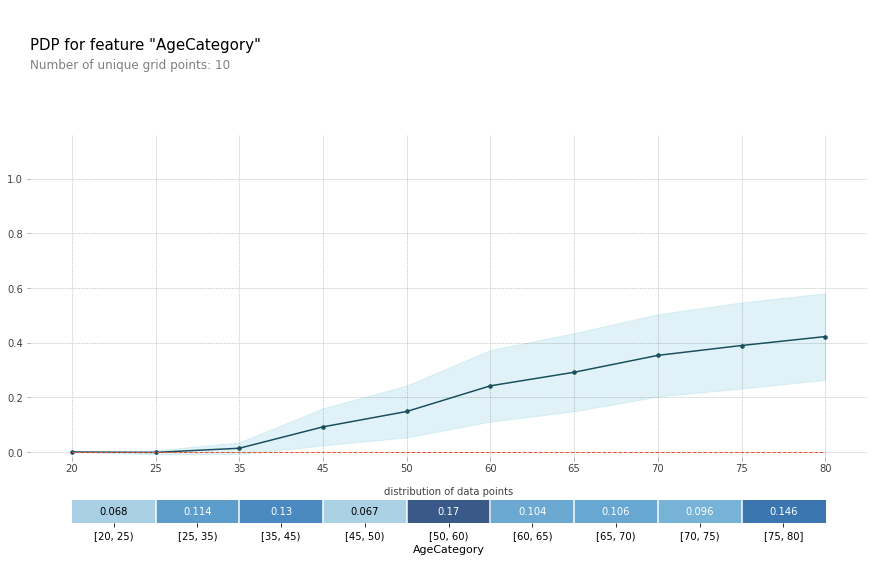

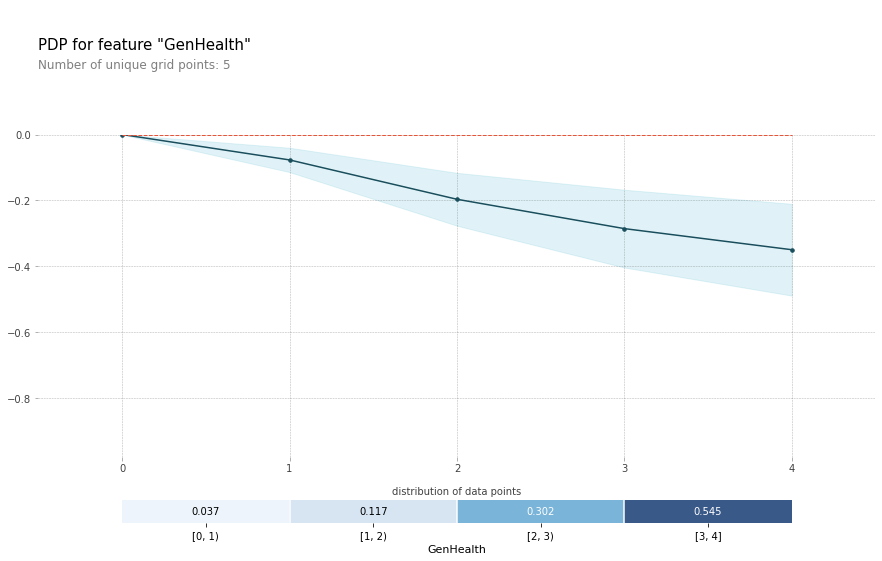

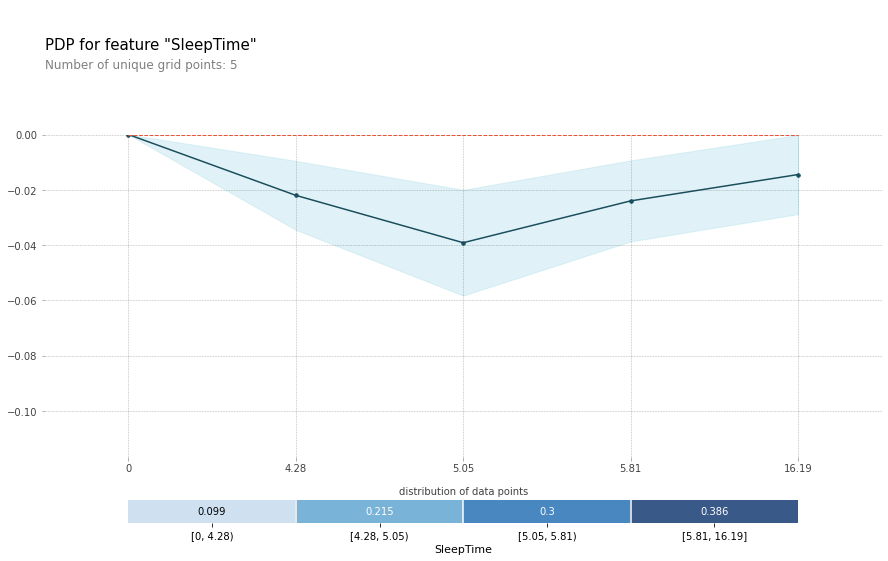

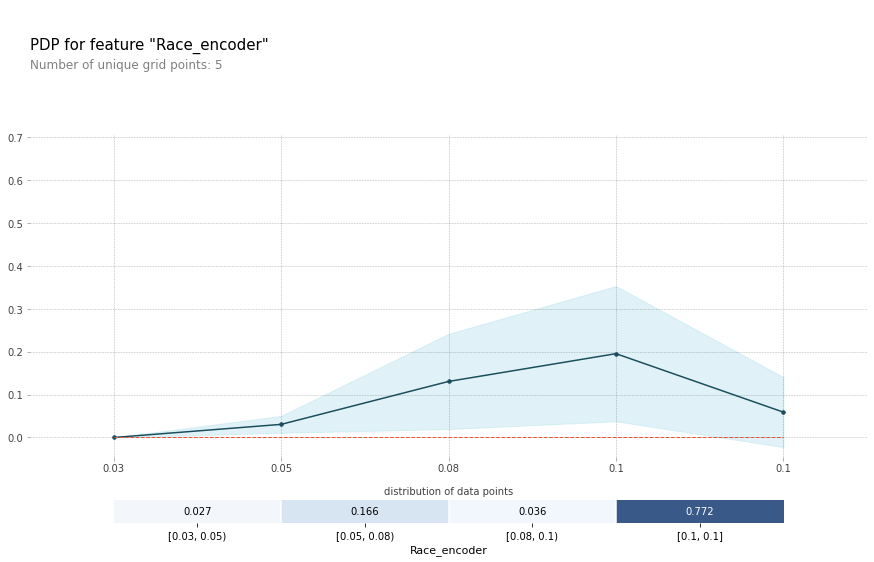

In [ ]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59568/60331 [01:00<00:00]       

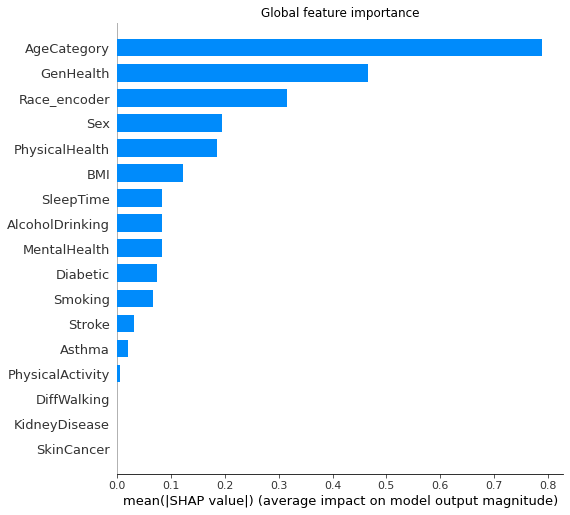

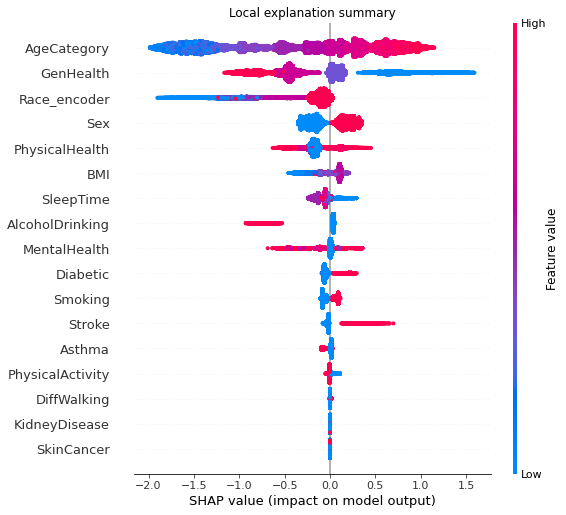

In [ ]:
# SHAP
explainer = shap.Explainer(model_SMOTE, x_train_SMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## BorderlineSMOTE

In [ ]:
model_BorderlineSM = xgb.XGBClassifier()
model_BorderlineSM.fit(x_train_BorderlineSM, y_train_BorderlineSM)

XGBClassifier()

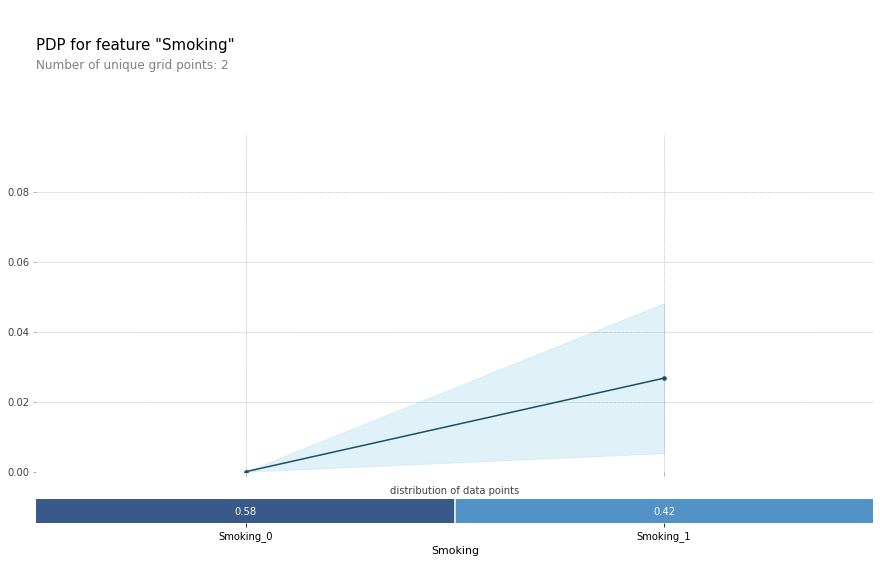

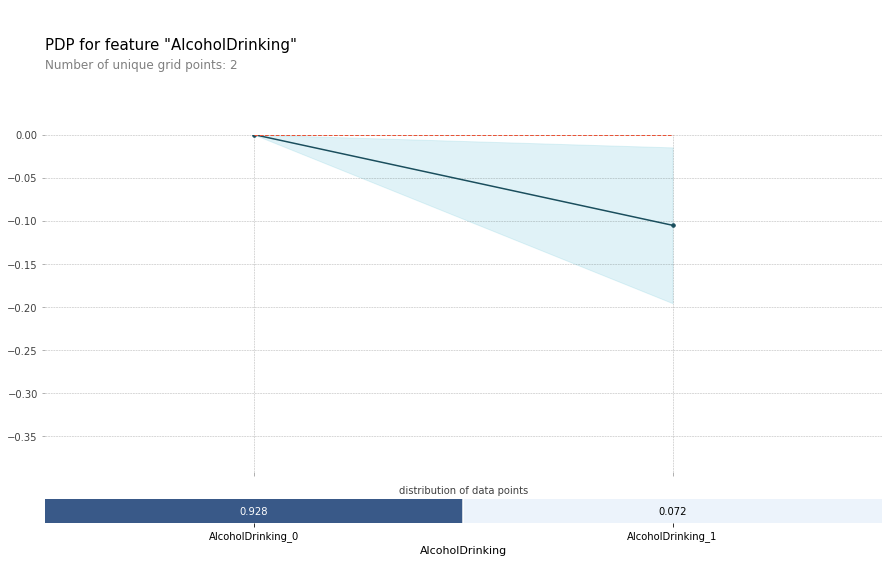

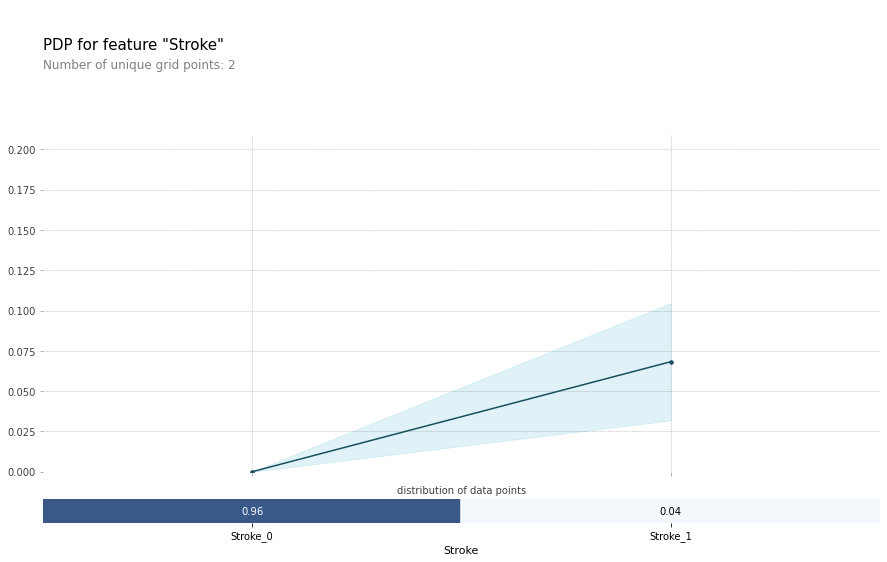

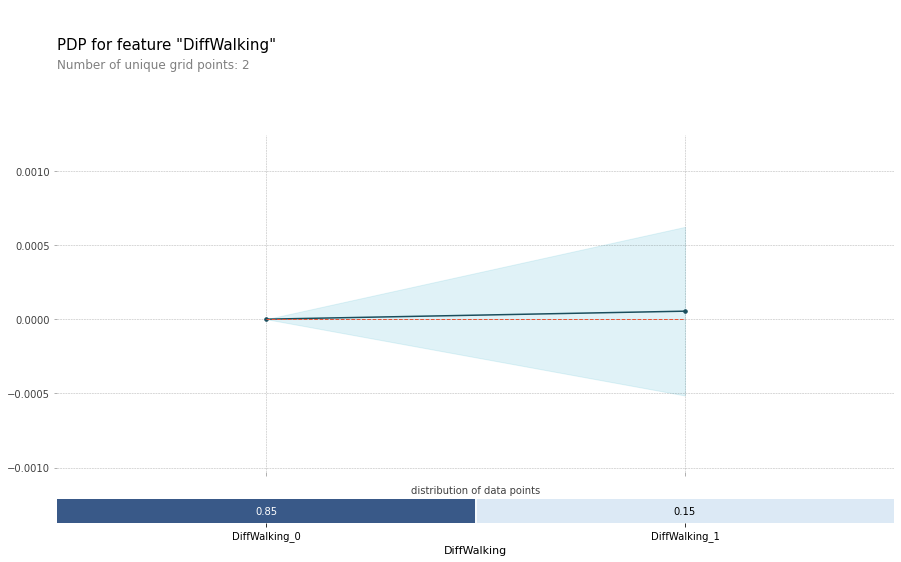

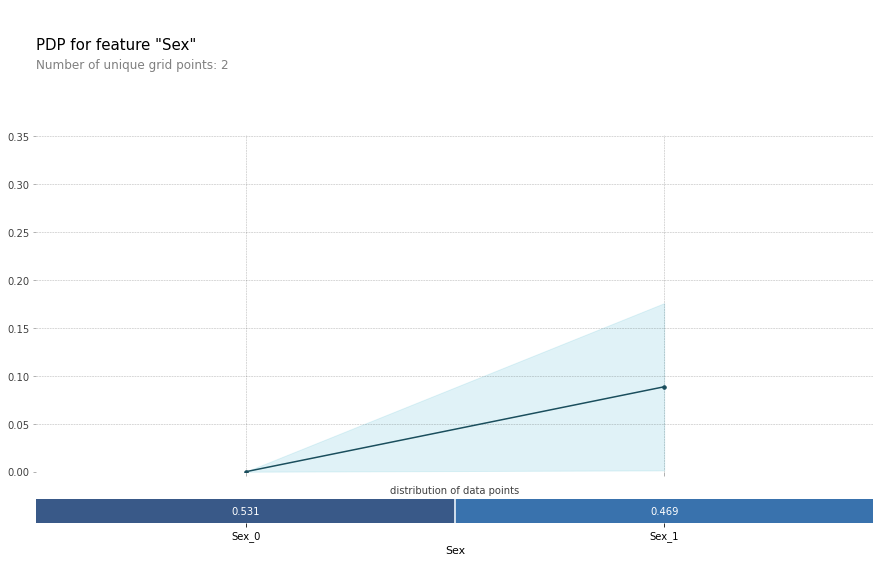

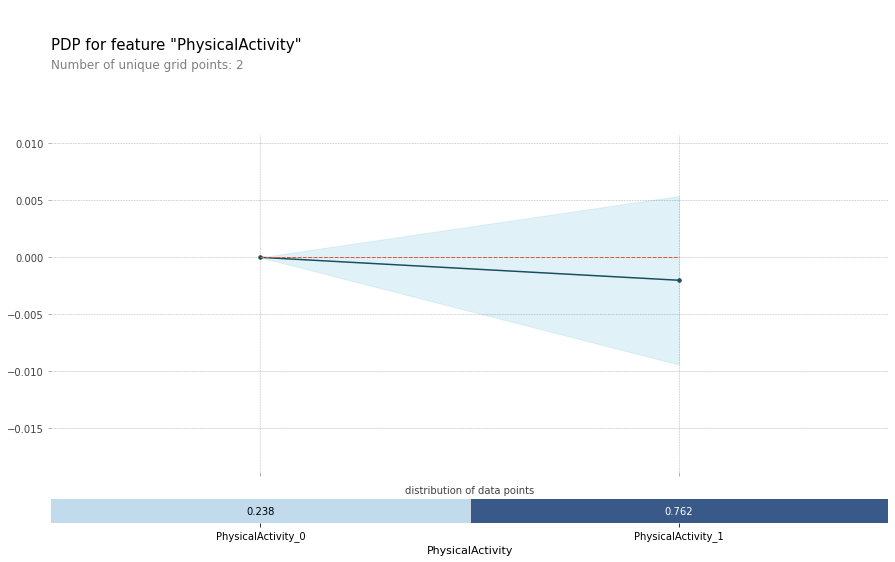

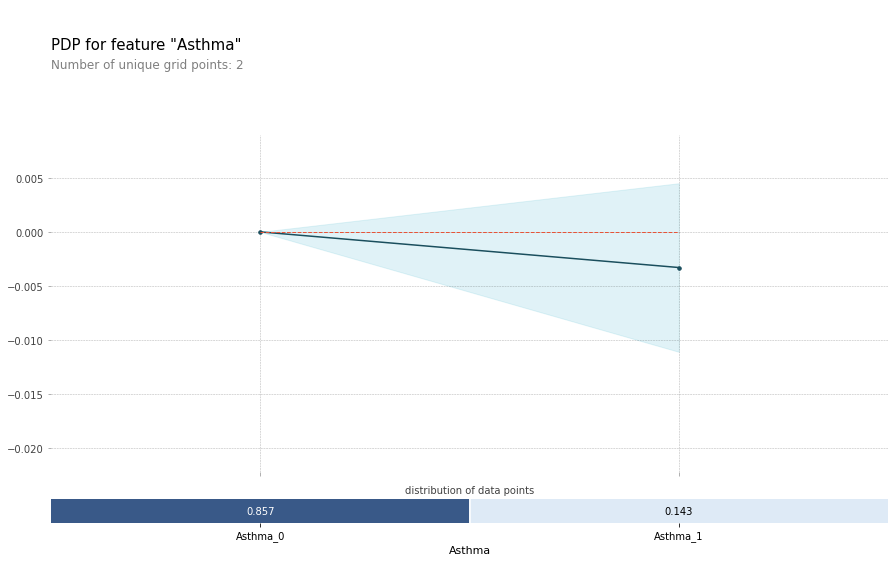

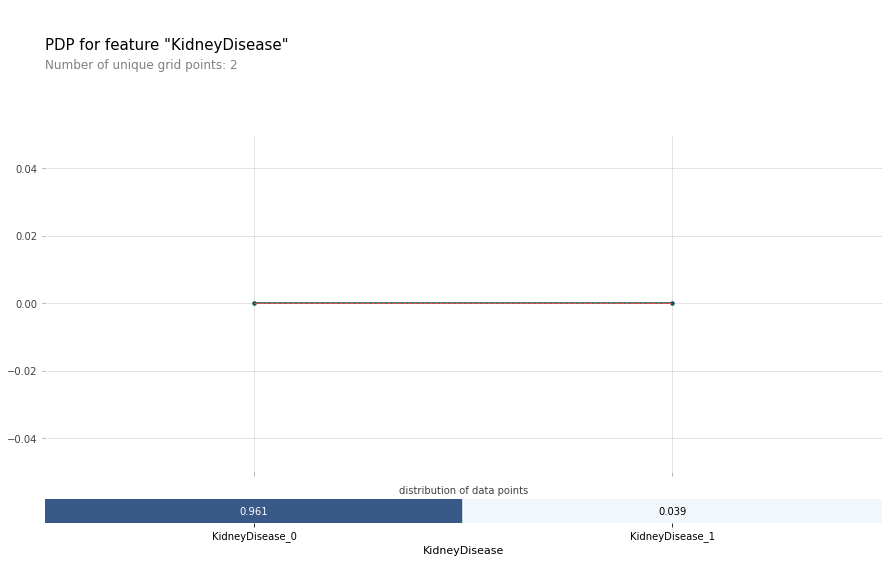

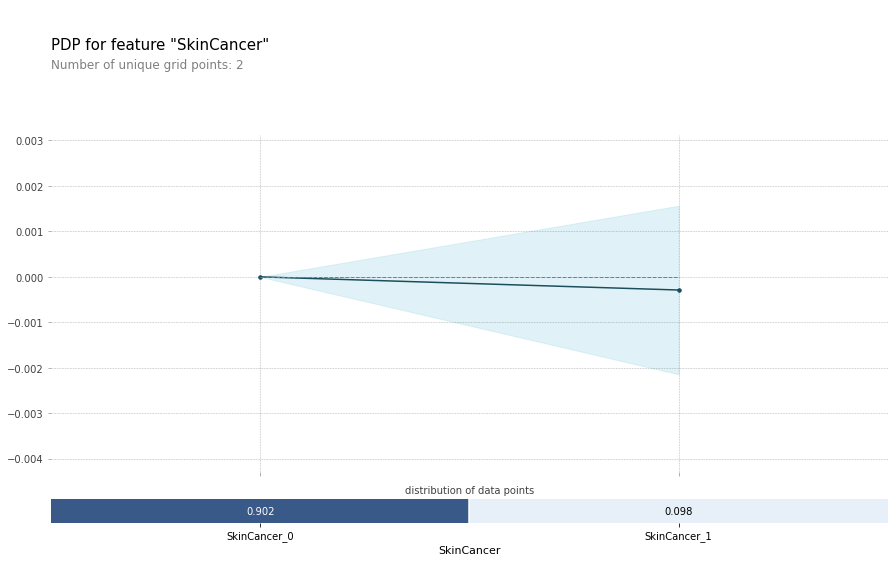

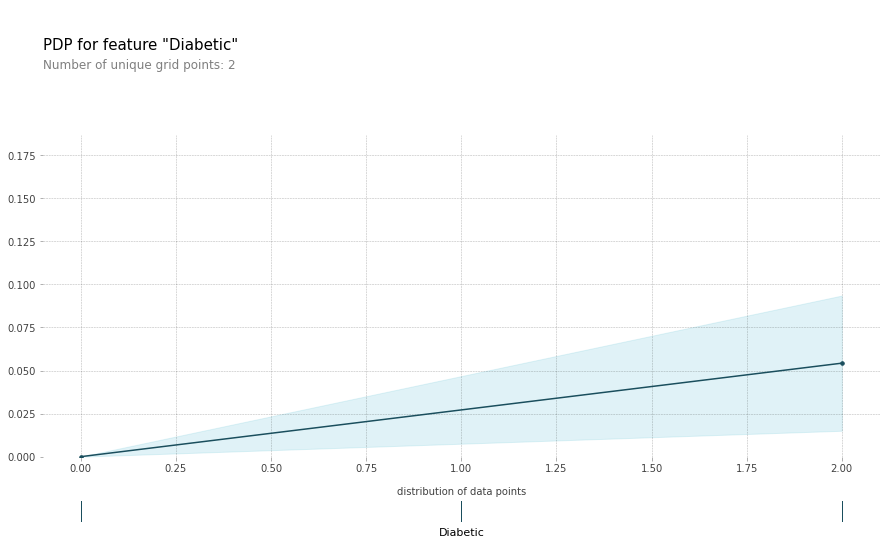

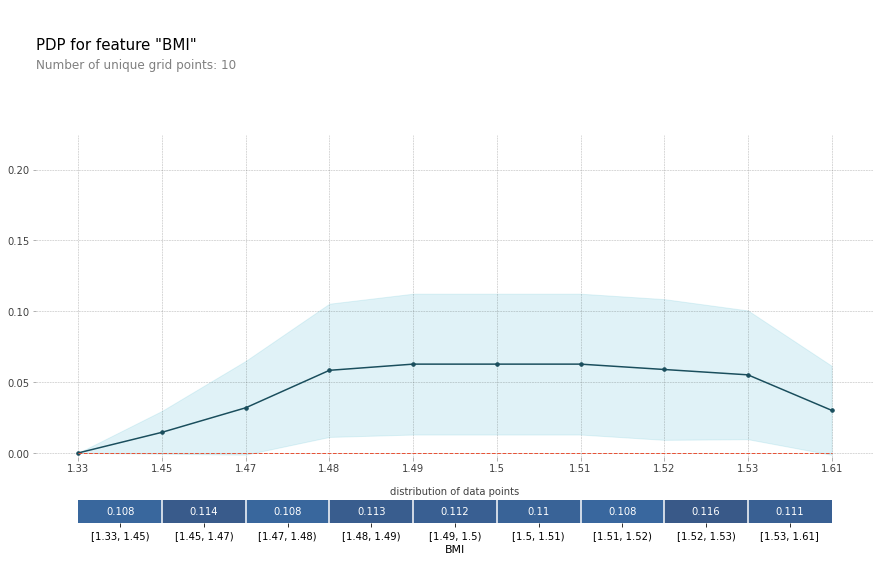

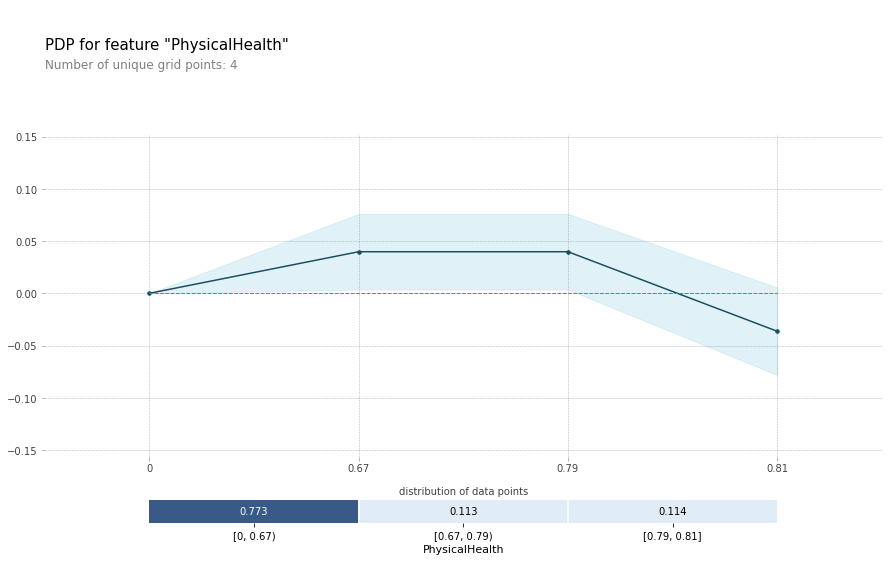

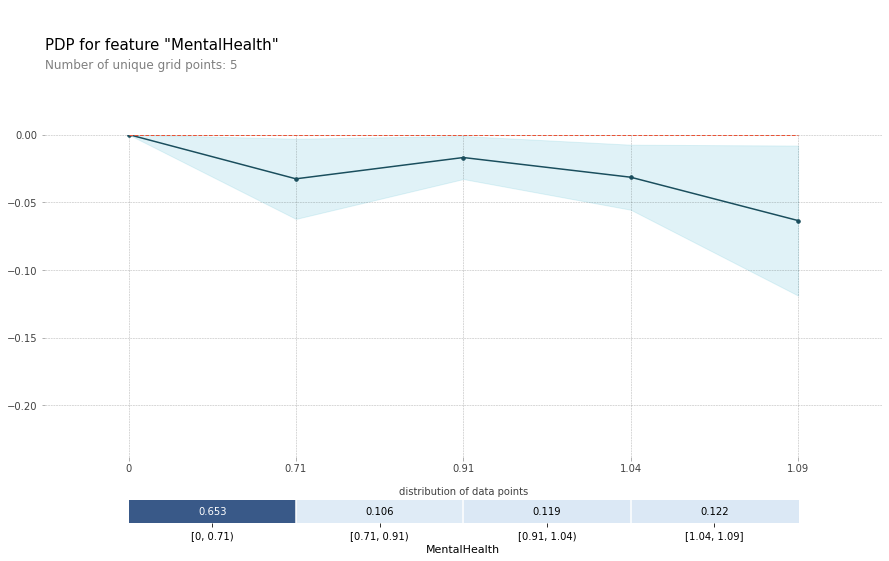

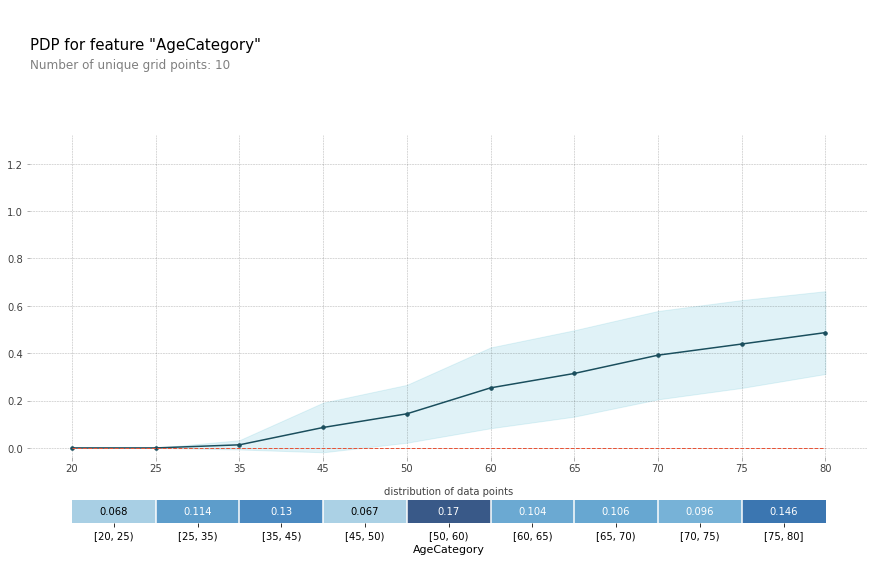

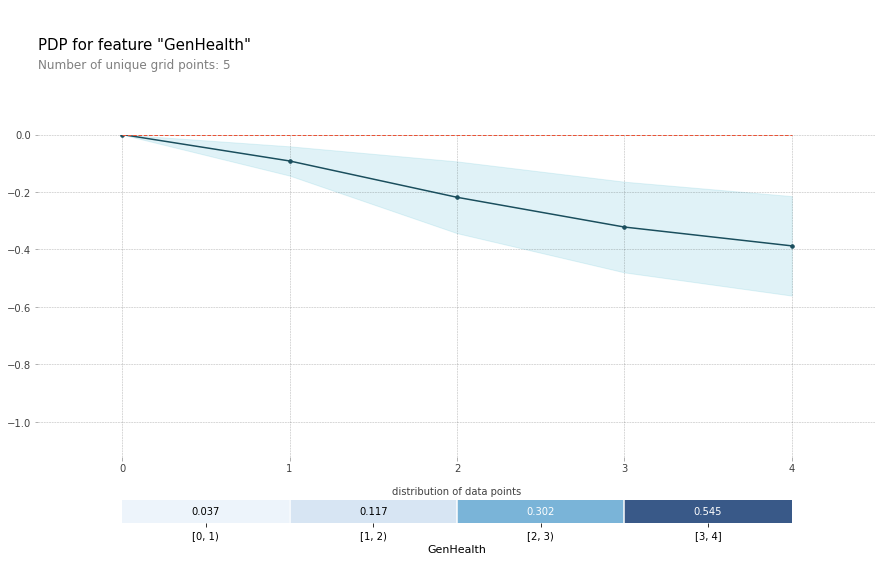

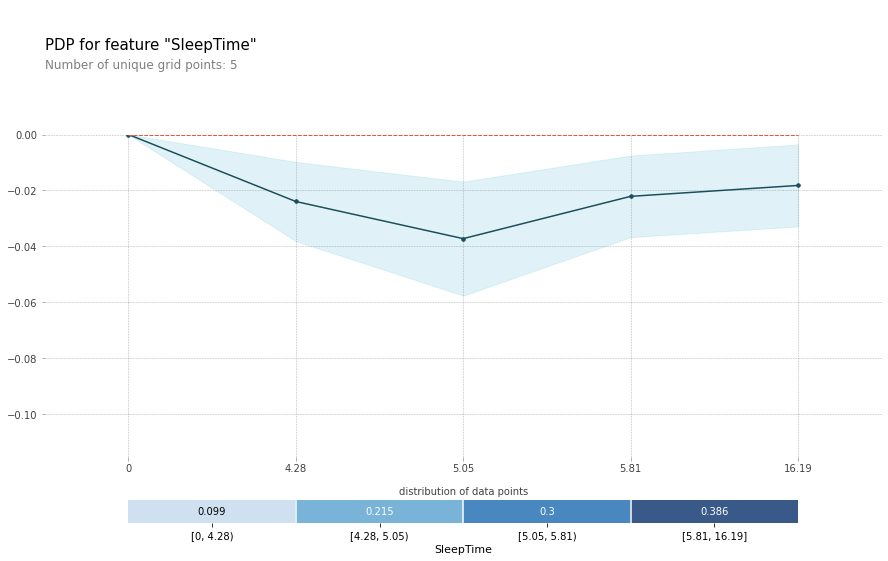

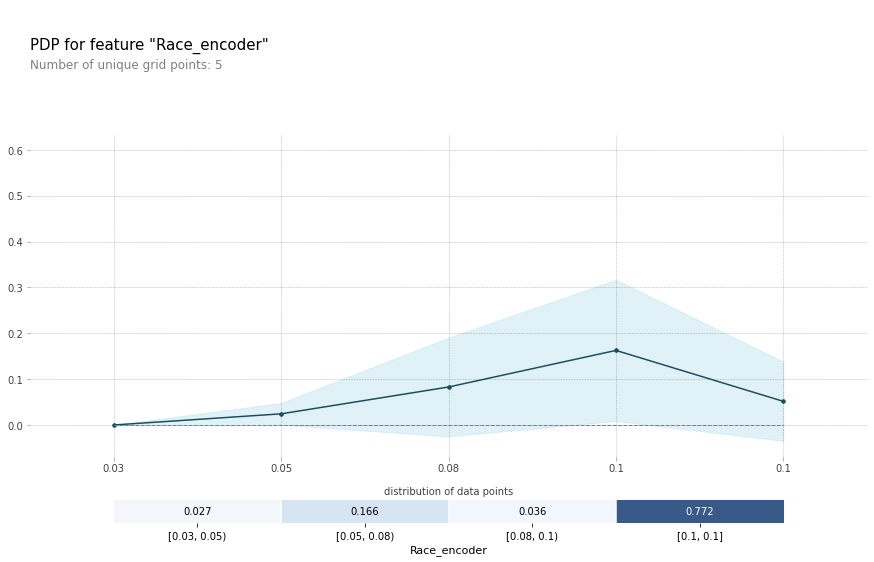

In [ ]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60113/60331 [01:02<00:00]       

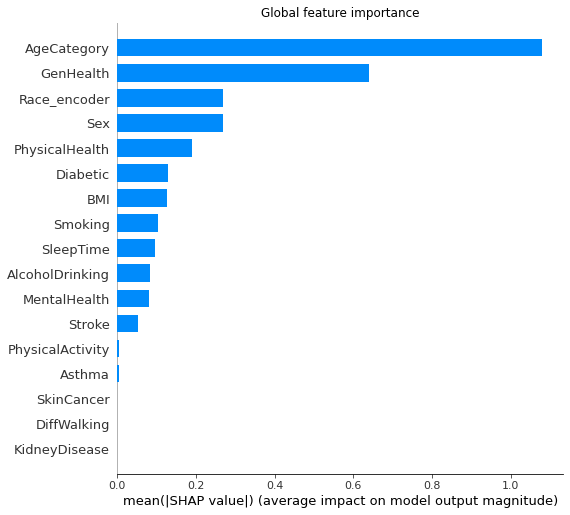

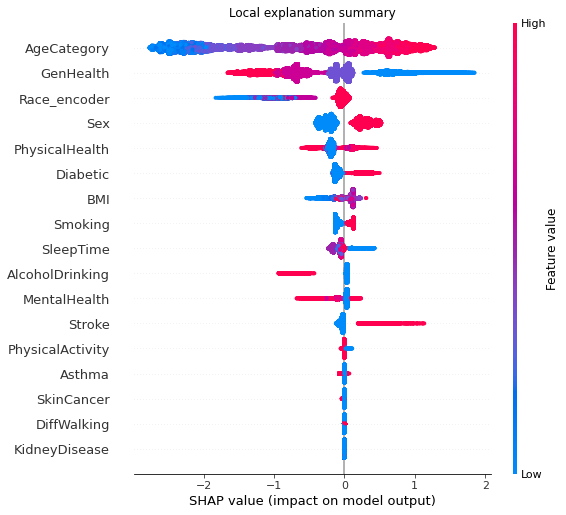

In [ ]:
# SHAP
explainer = shap.Explainer(model_BorderlineSM, x_train_BorderlineSM, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SVMSMOTE

In [ ]:
model_SVMSMOTE = xgb.XGBClassifier()
model_SVMSMOTE.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)

XGBClassifier()

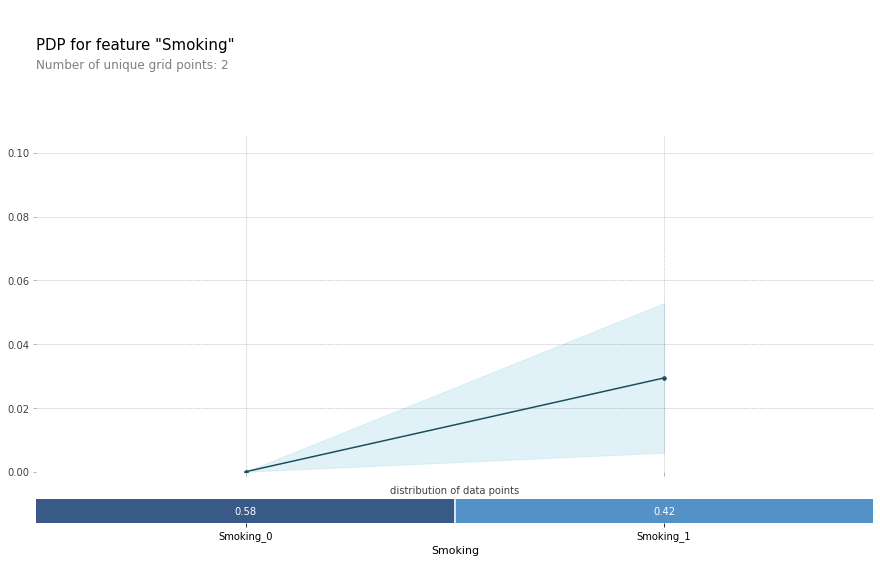

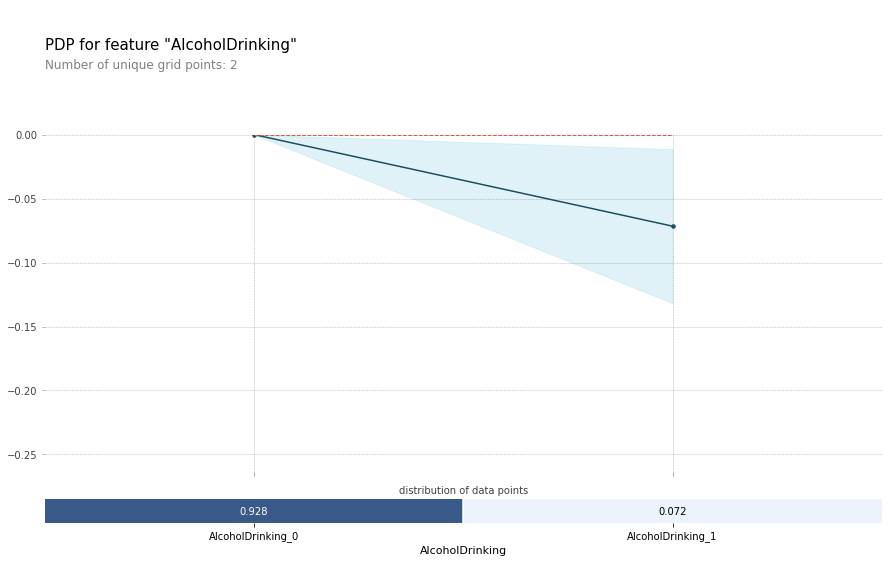

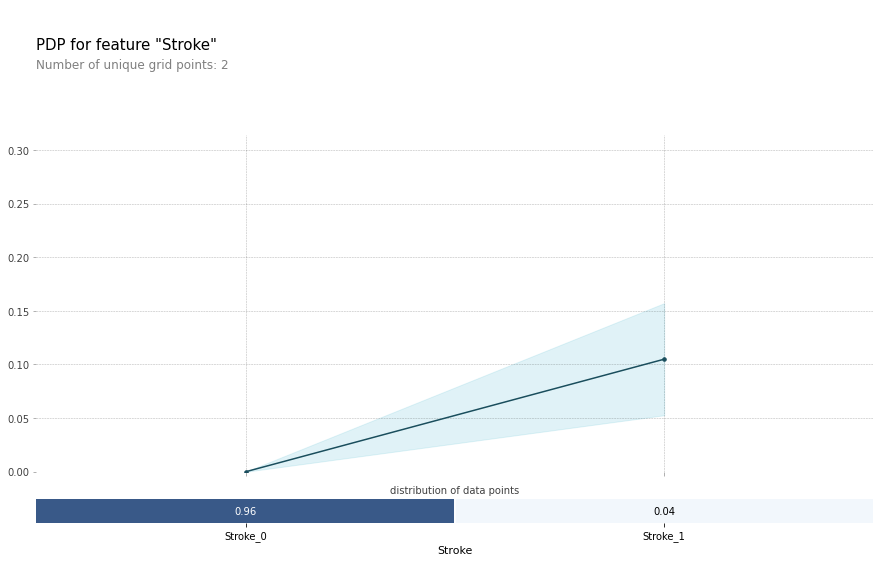

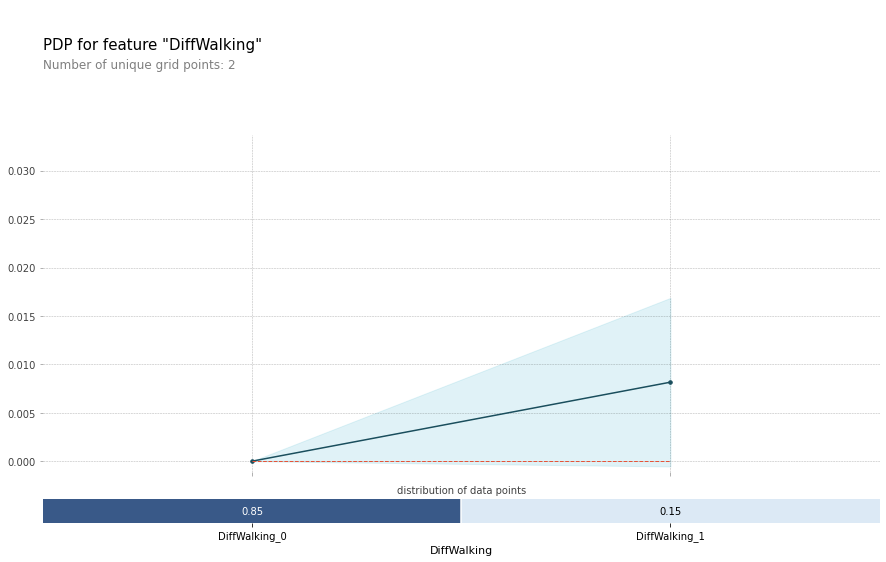

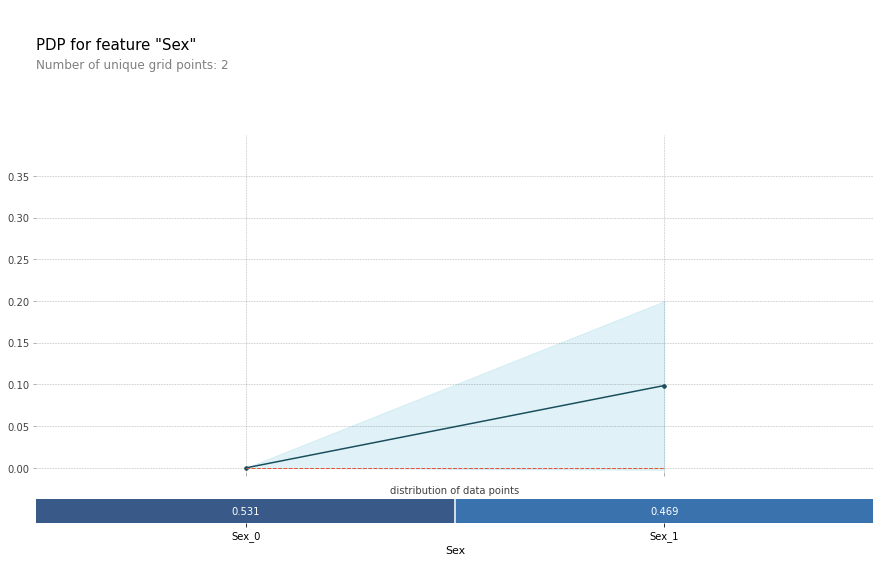

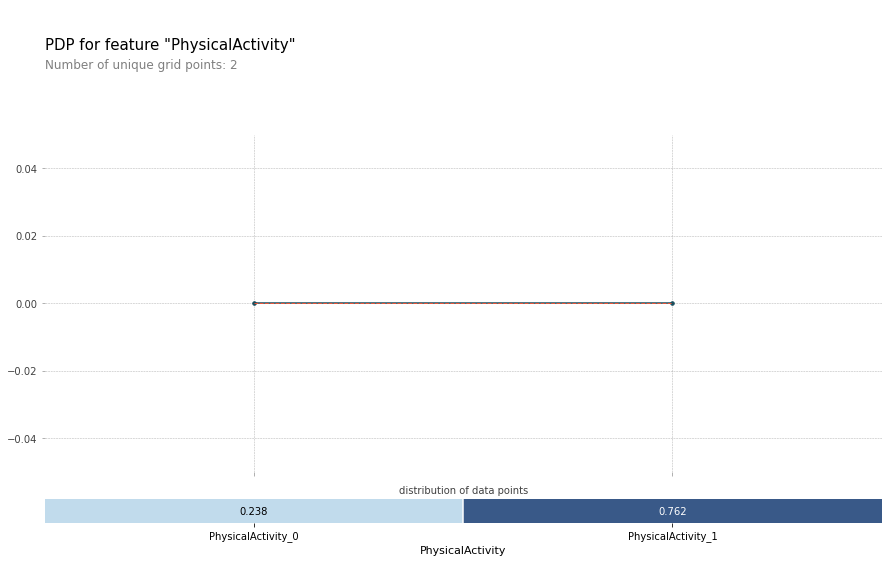

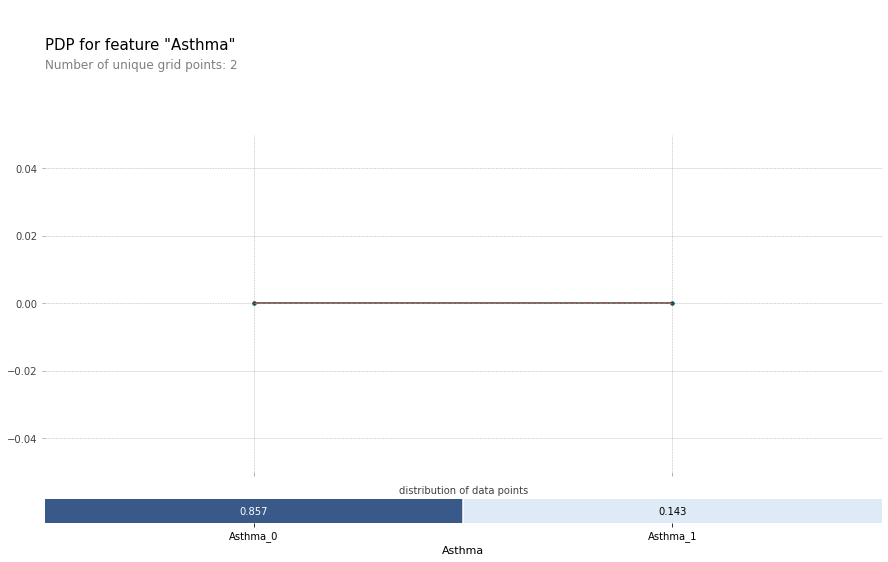

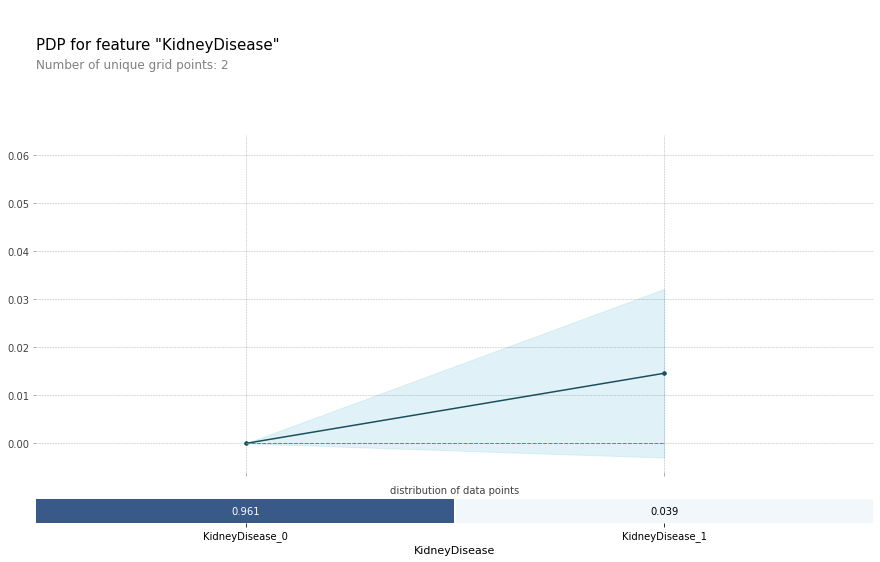

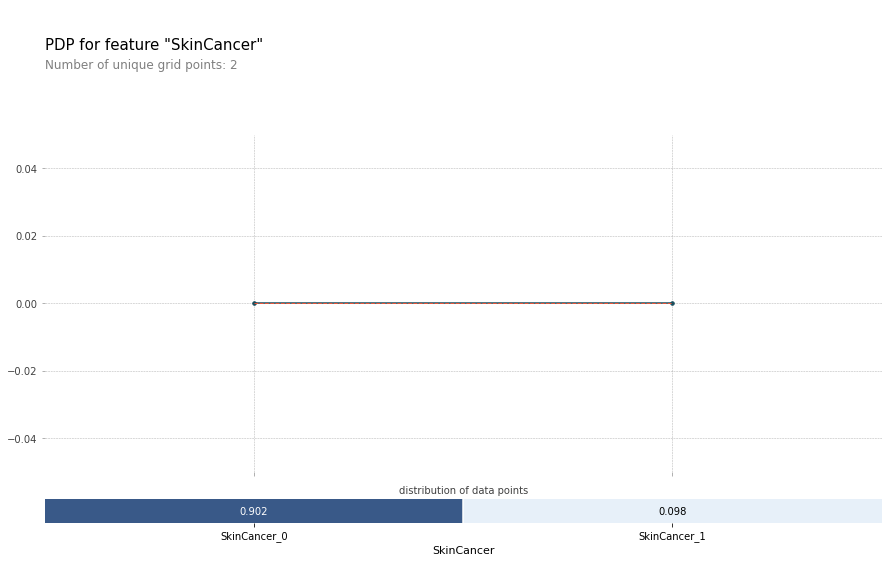

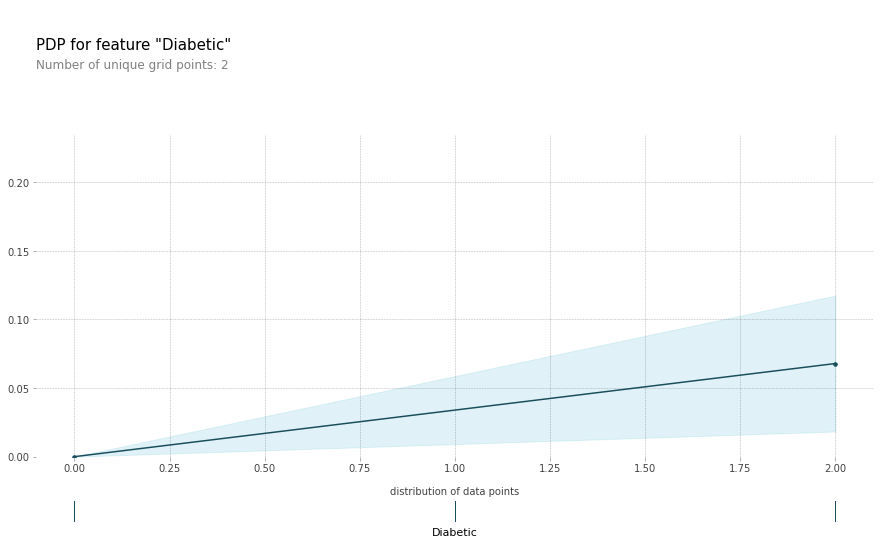

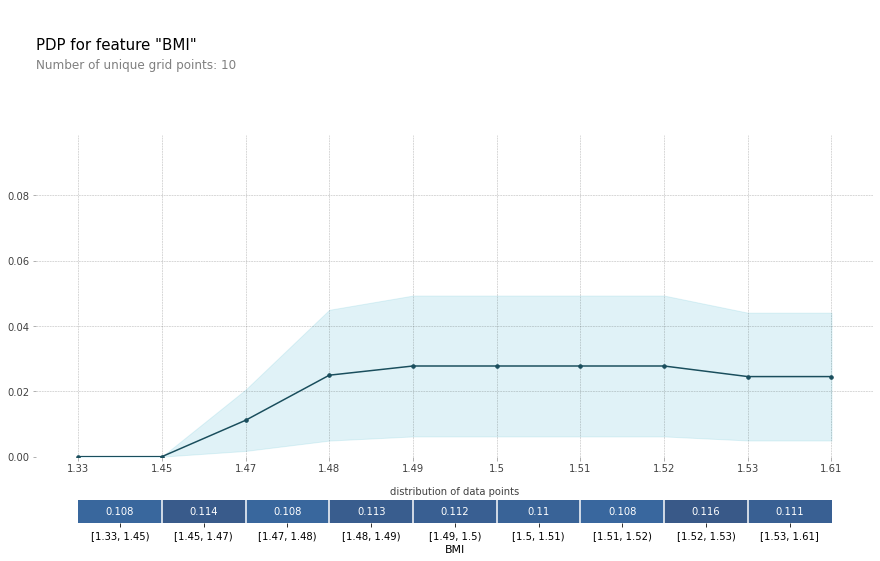

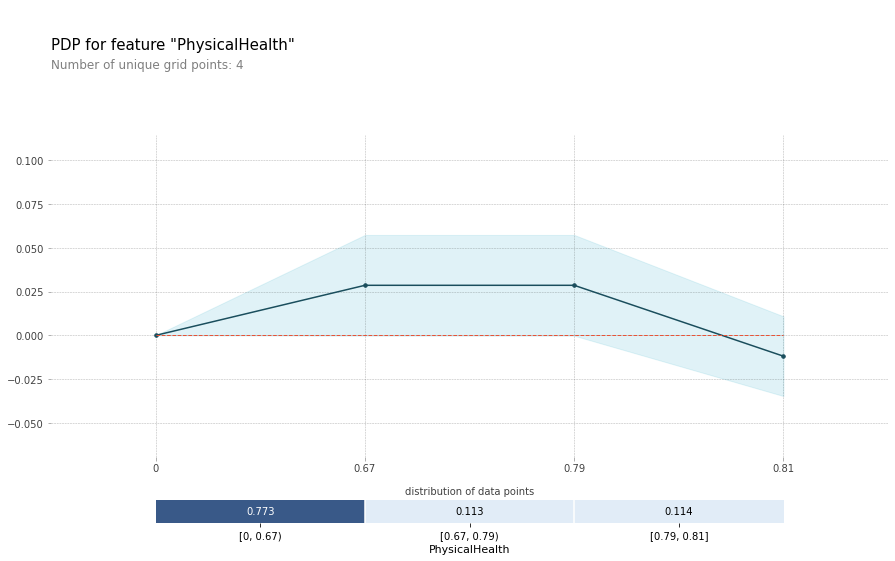

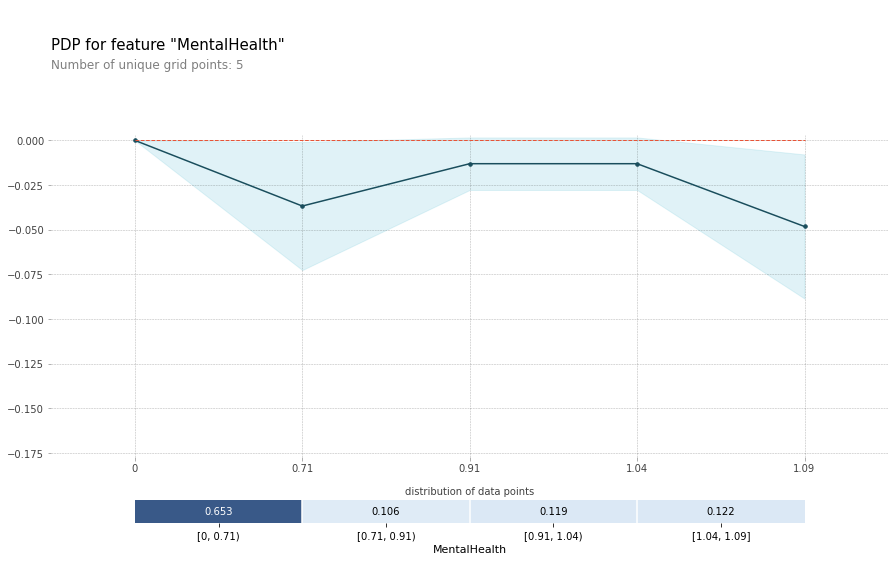

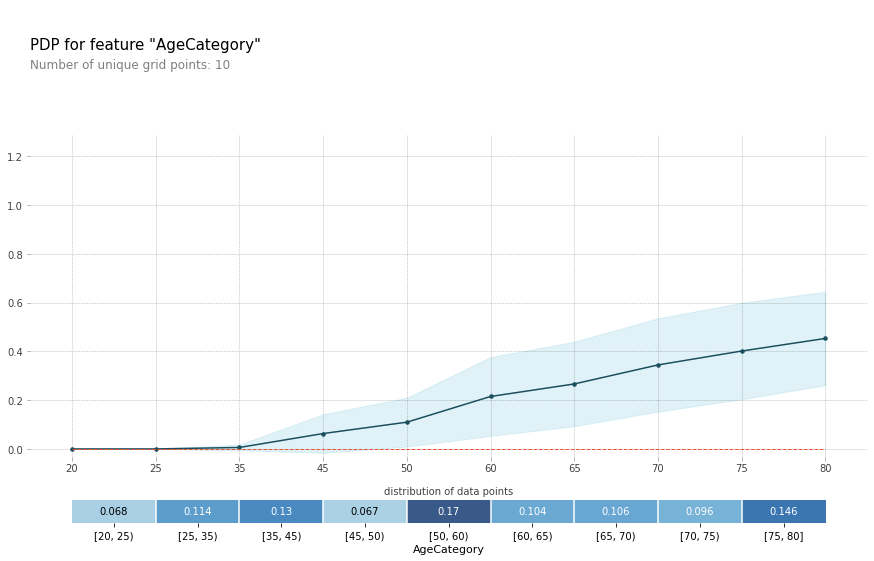

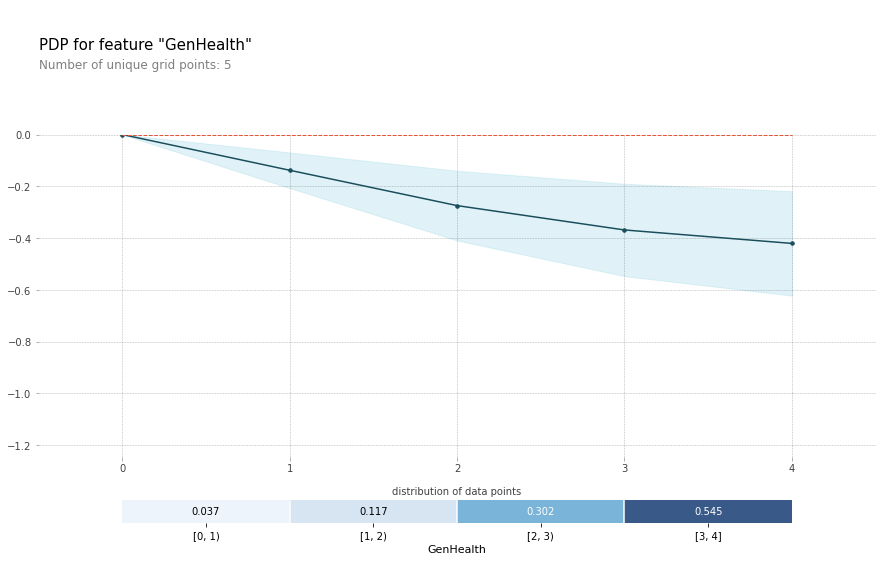

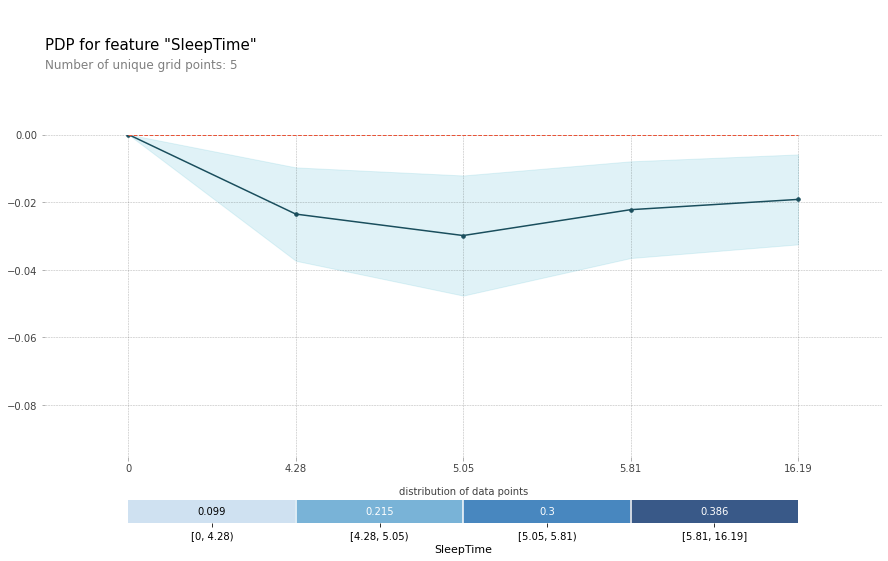

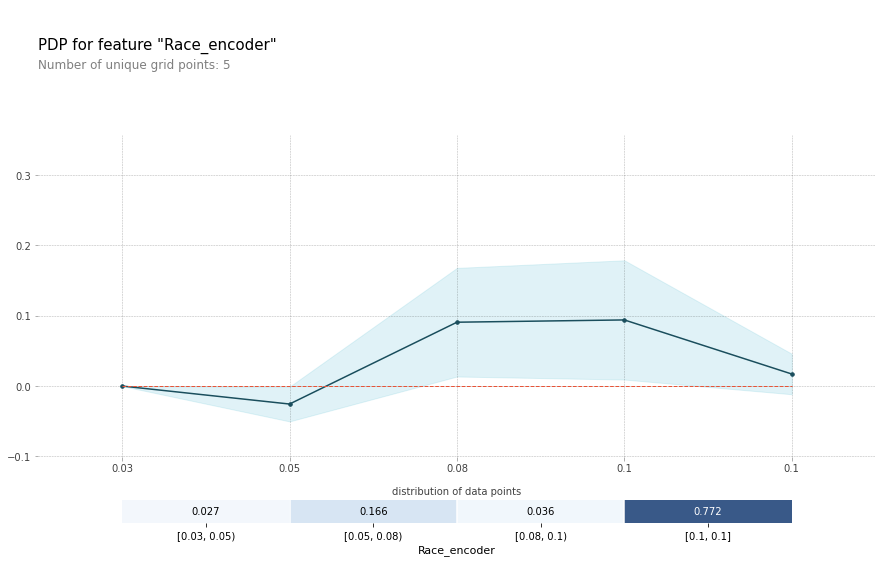

In [ ]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 60026/60331 [01:01<00:00]       

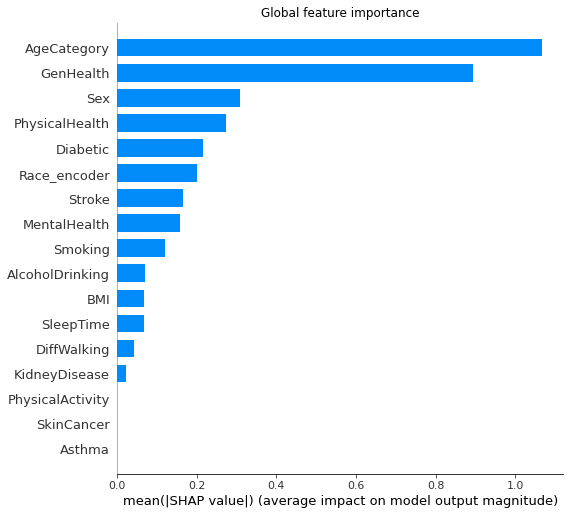

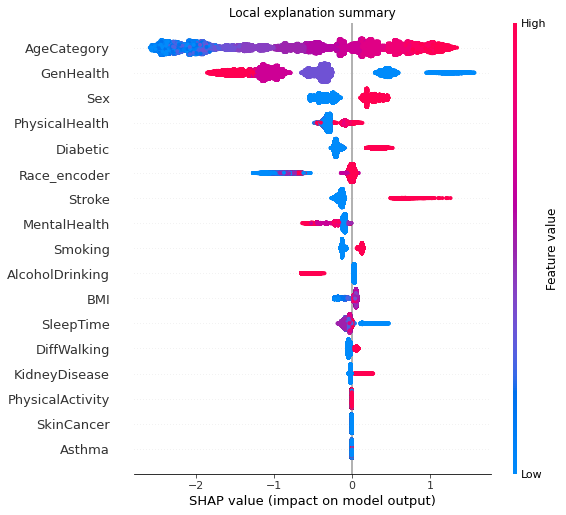

In [ ]:
# SHAP
explainer = shap.Explainer(model_SVMSMOTE, x_train_SVMSMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## ADASYN

In [ ]:
model_ADASYN = xgb.XGBClassifier()
model_ADASYN.fit(x_train_ADASYN, y_train_ADASYN)

XGBClassifier()

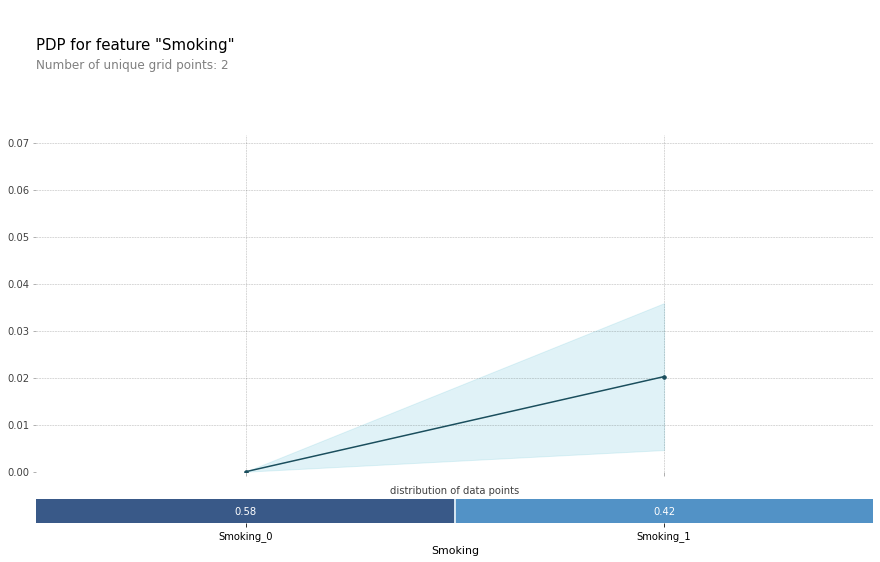

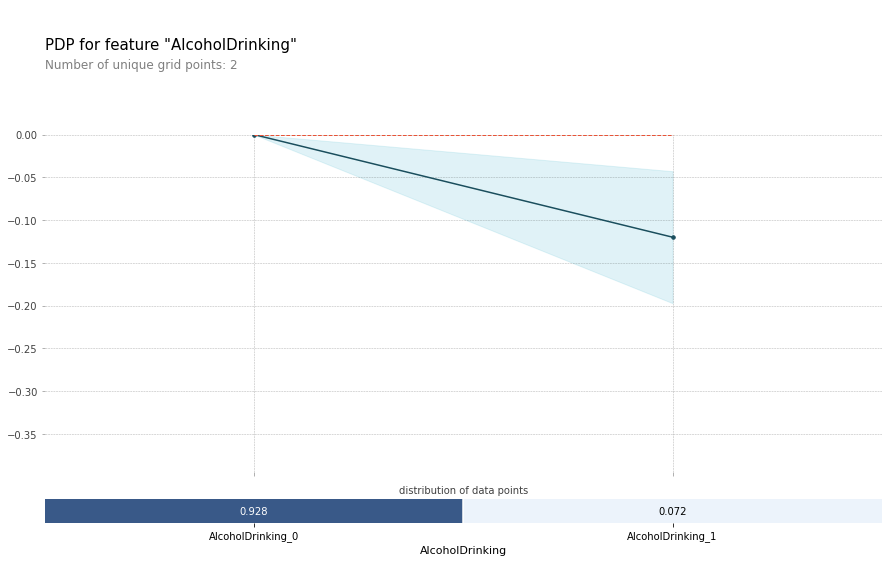

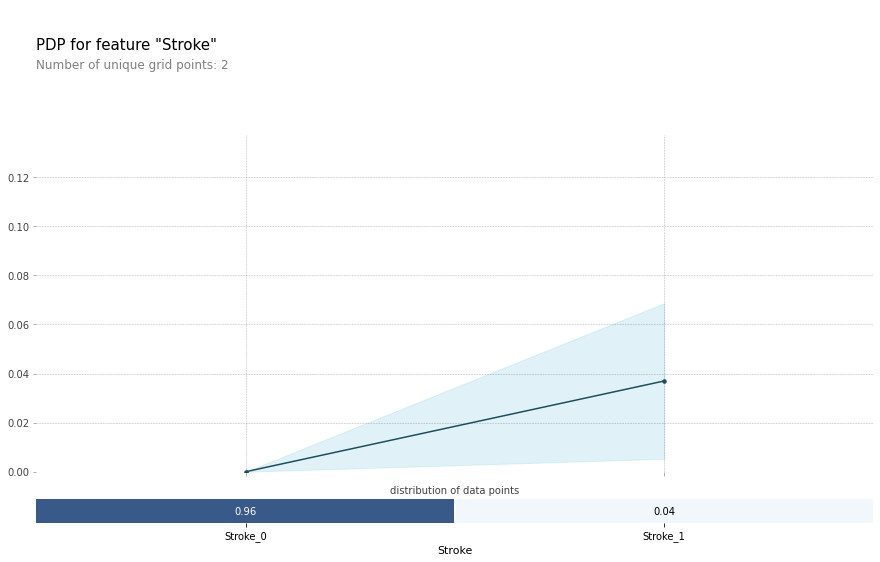

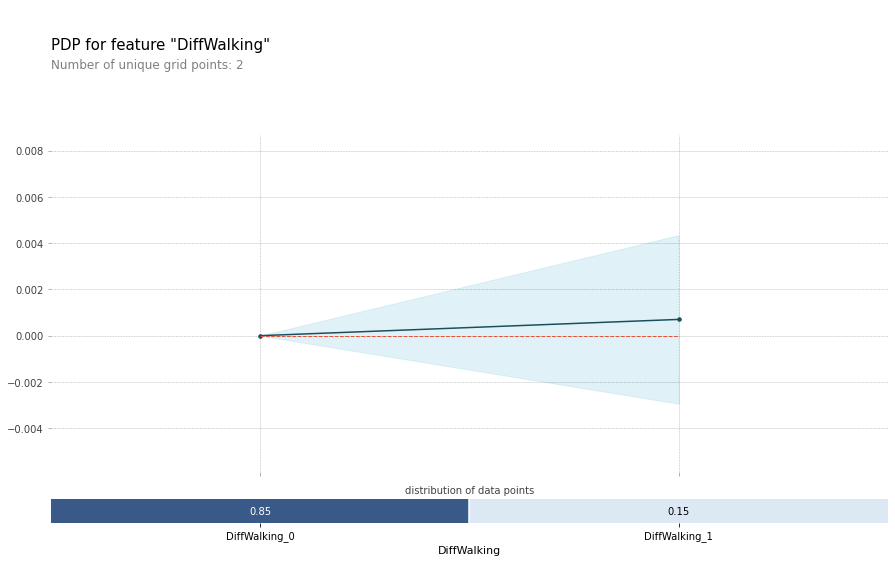

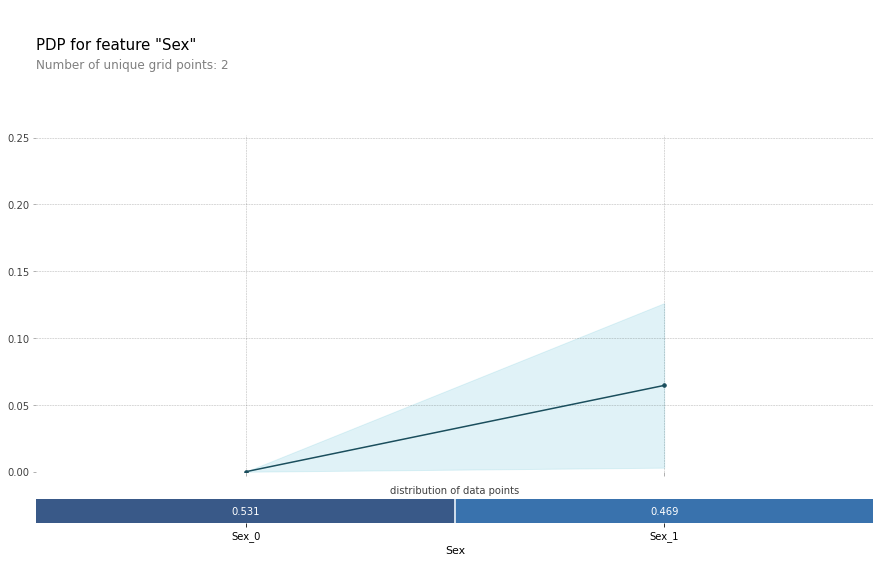

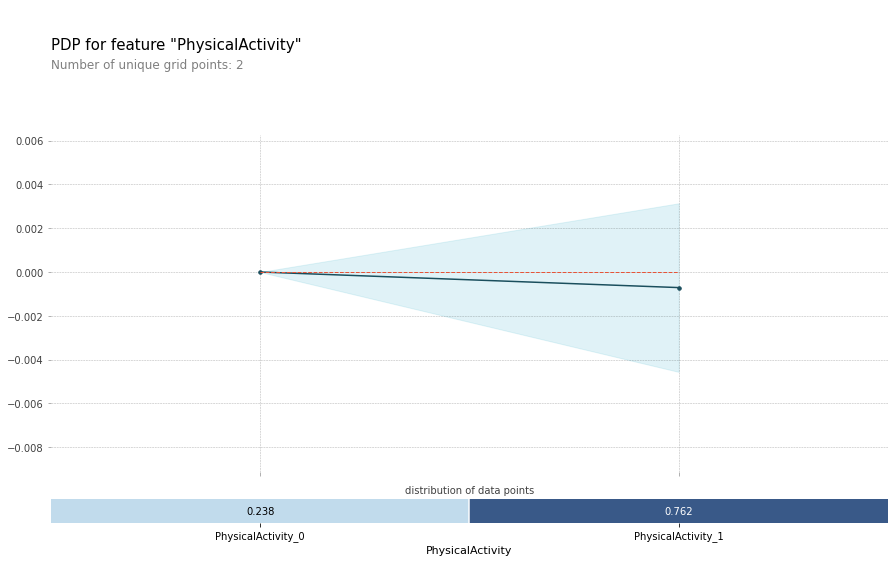

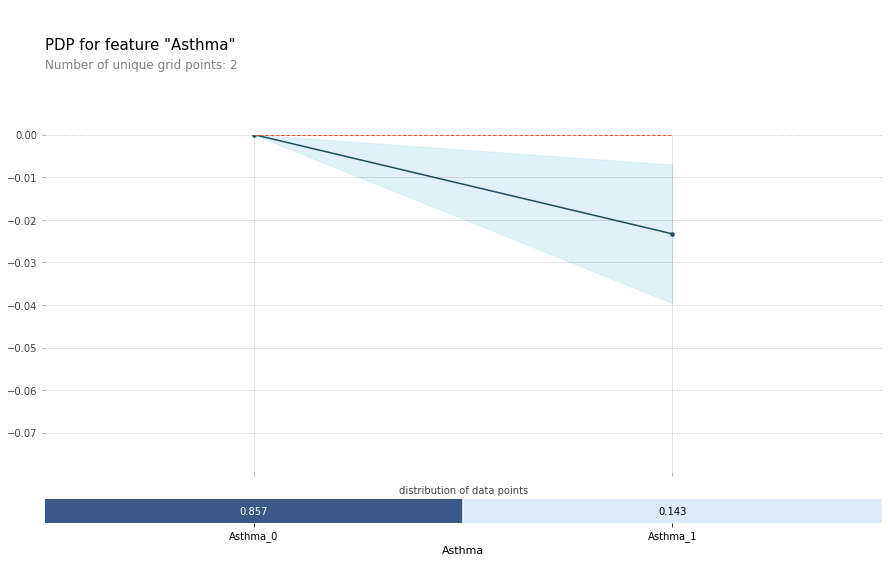

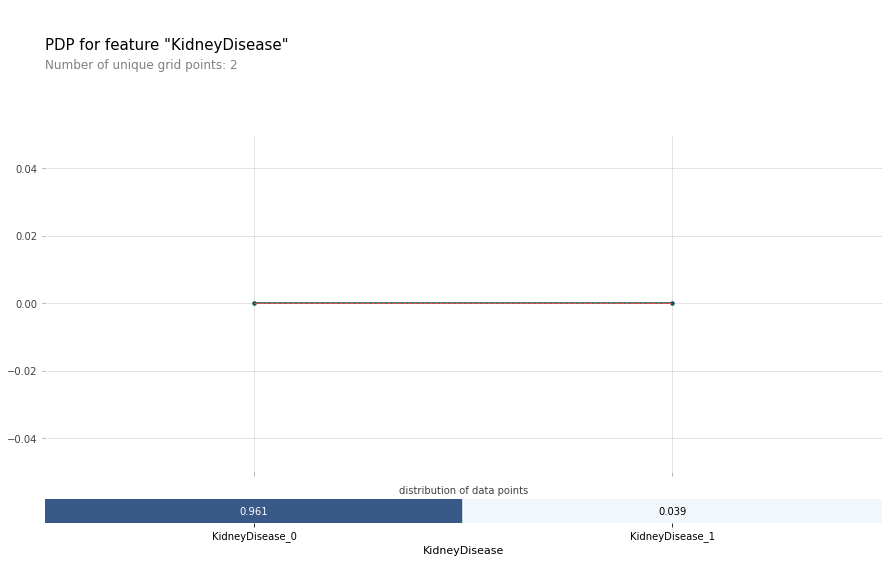

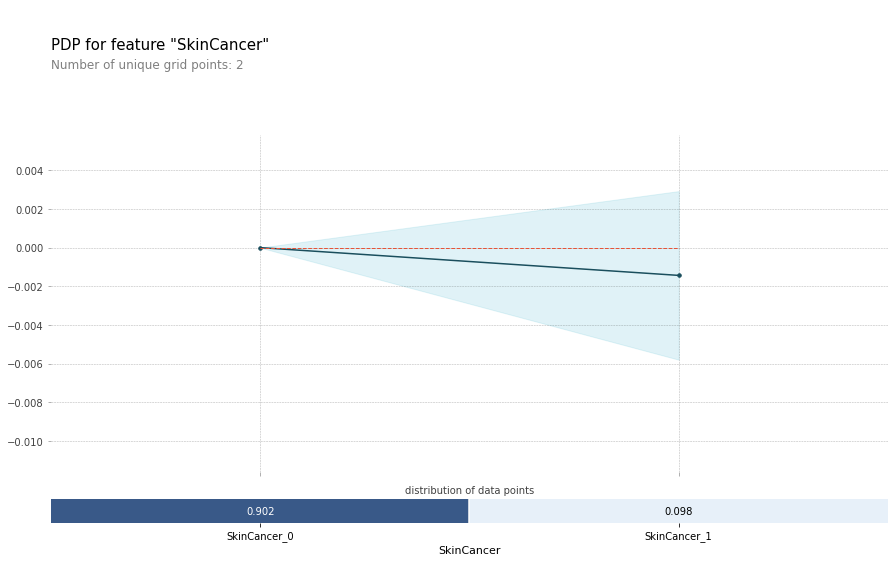

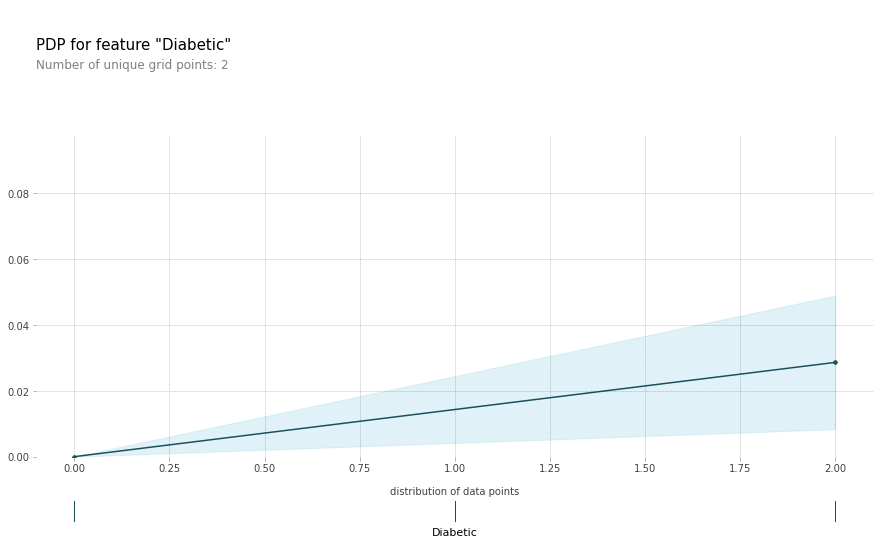

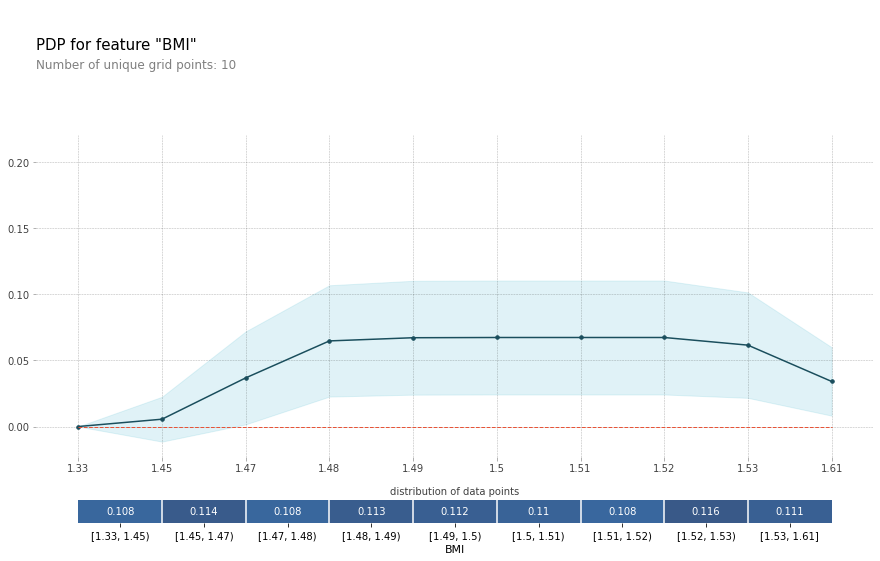

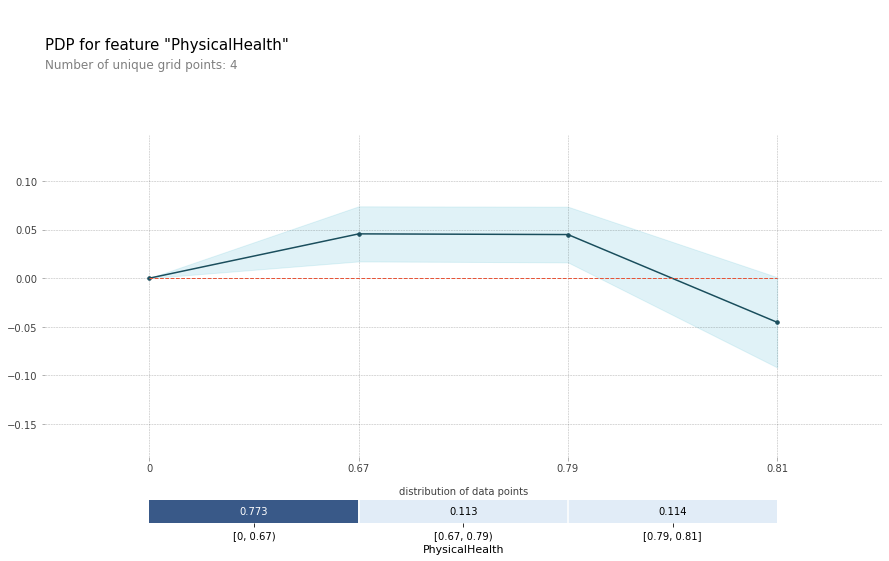

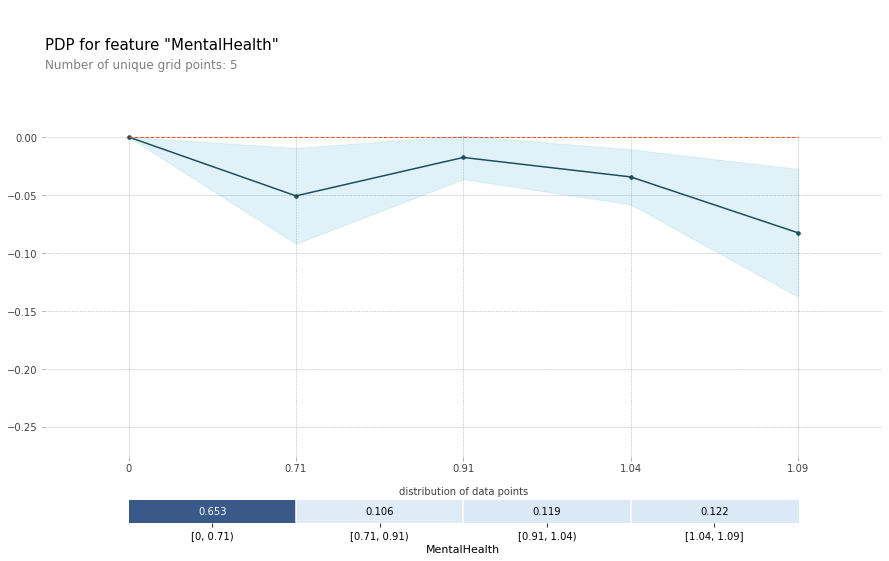

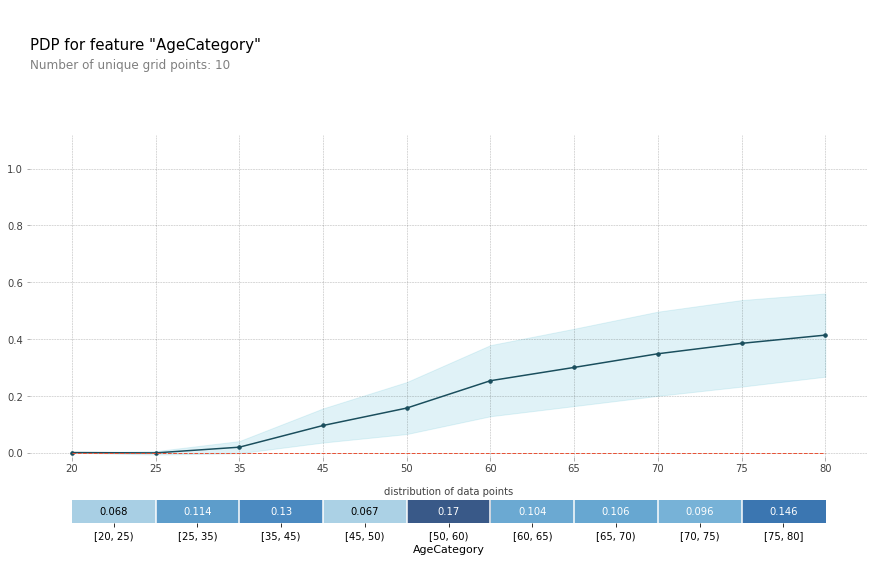

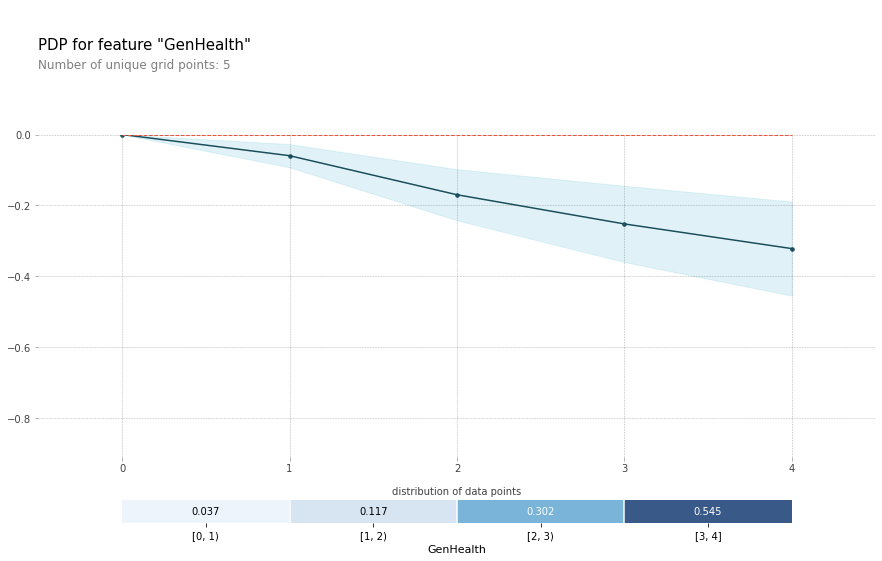

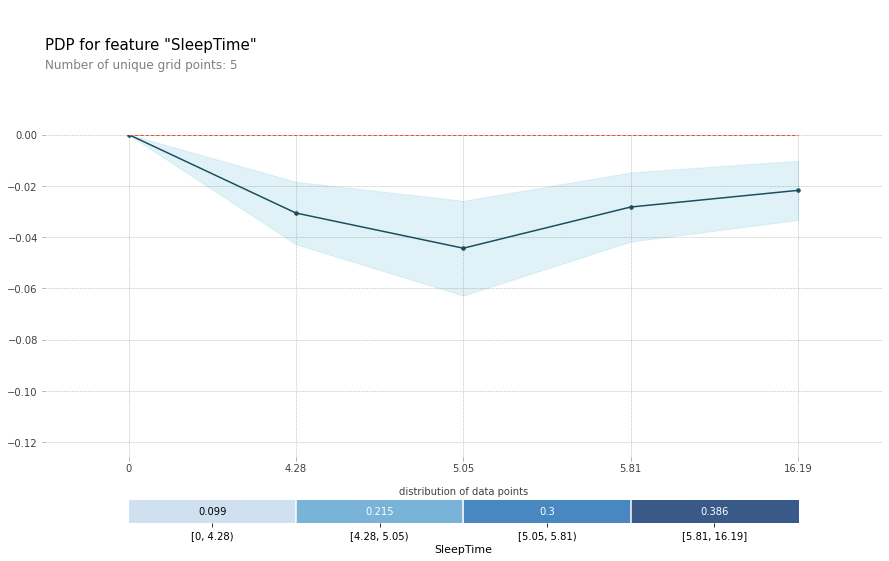

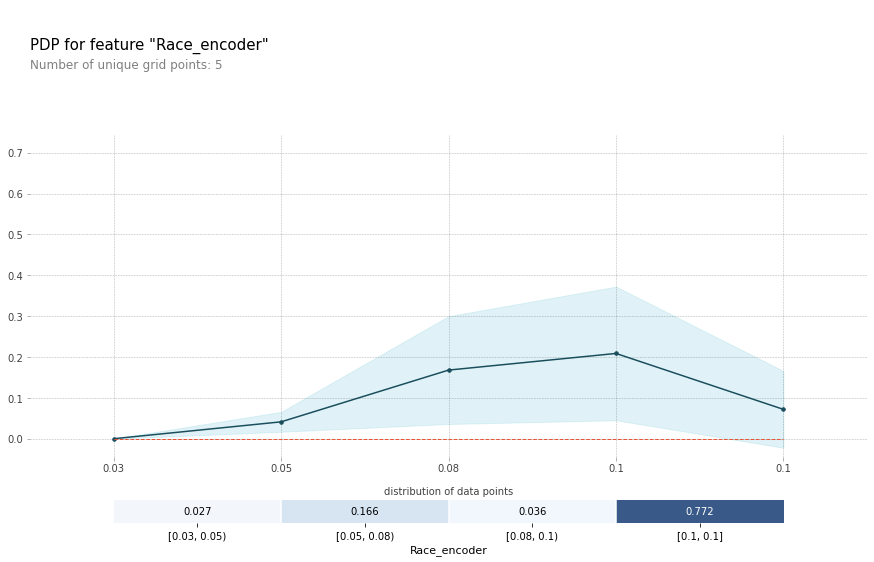

In [ ]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59692/60331 [00:58<00:00]       

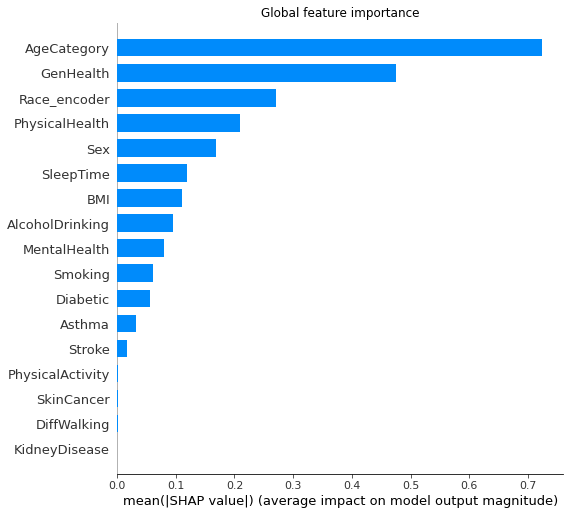

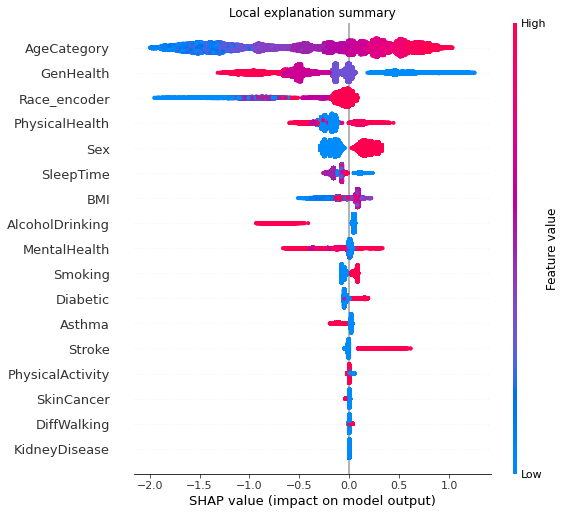

In [ ]:
# SHAP
explainer = shap.Explainer(model_ADASYN, x_train_ADASYN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTEENN

In [ ]:
model_SMOTEENN = xgb.XGBClassifier()
model_SMOTEENN.fit(x_train_SMOTEENN, y_train_SMOTEENN)

XGBClassifier()

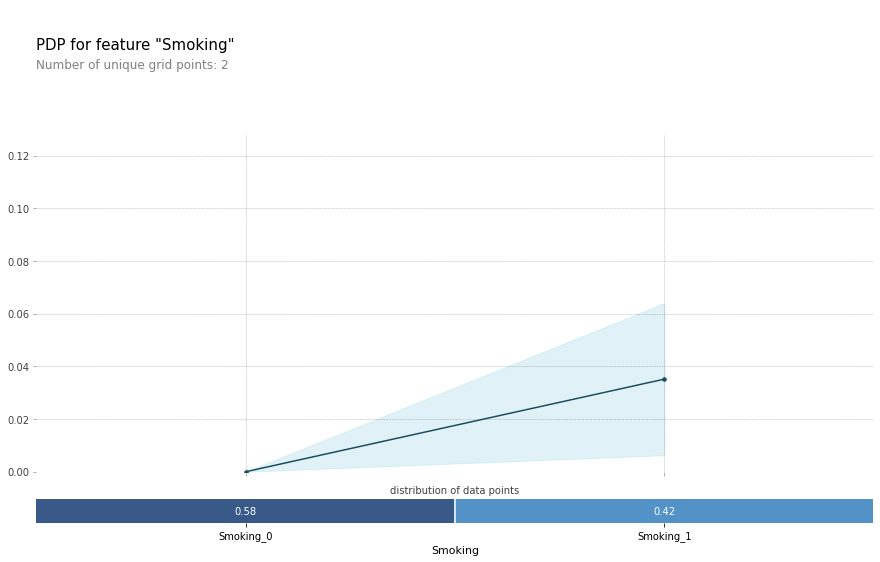

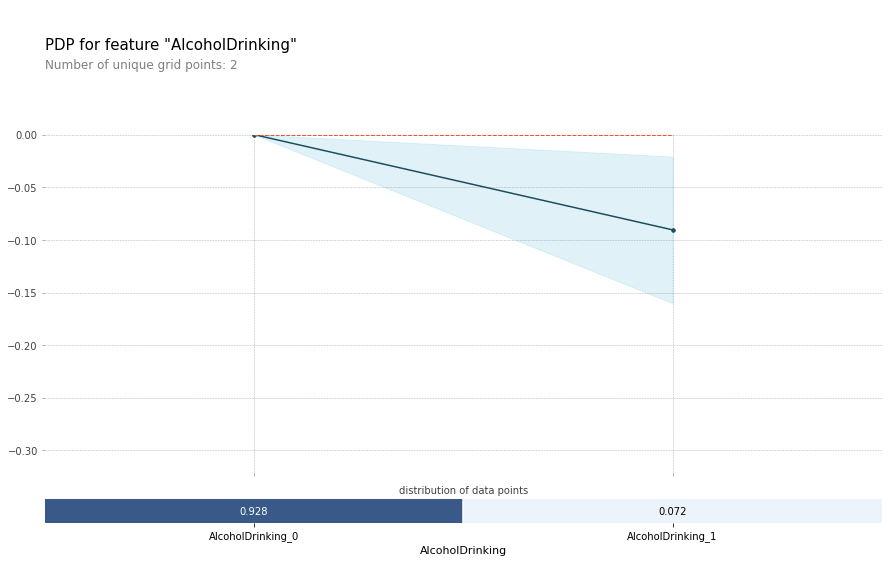

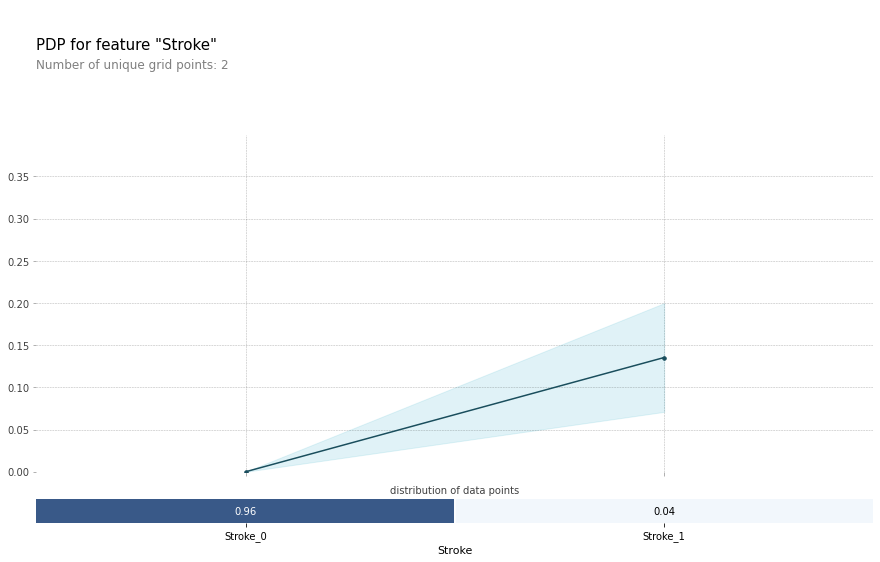

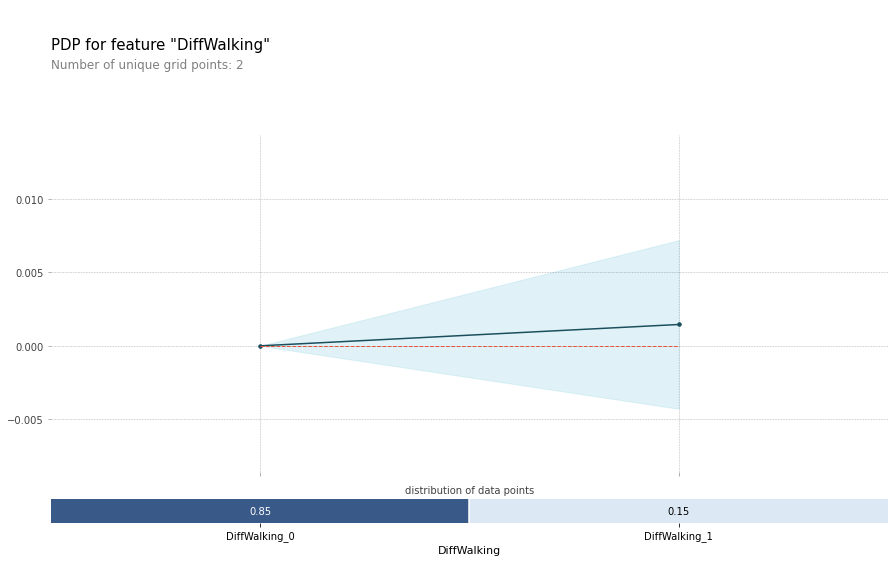

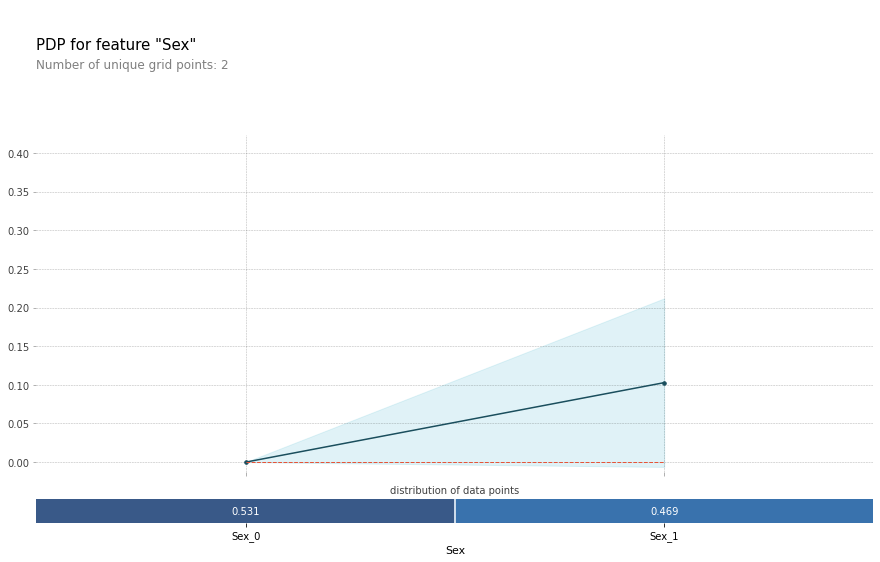

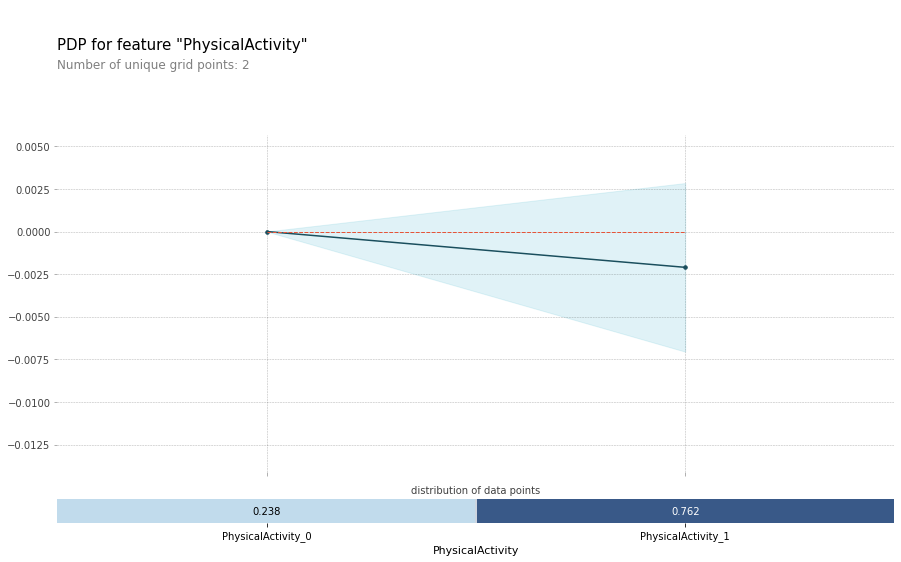

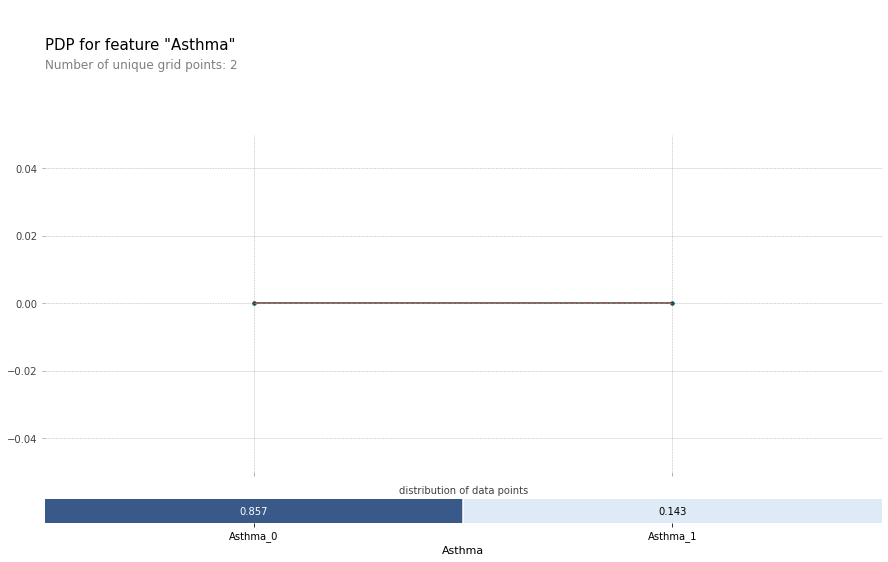

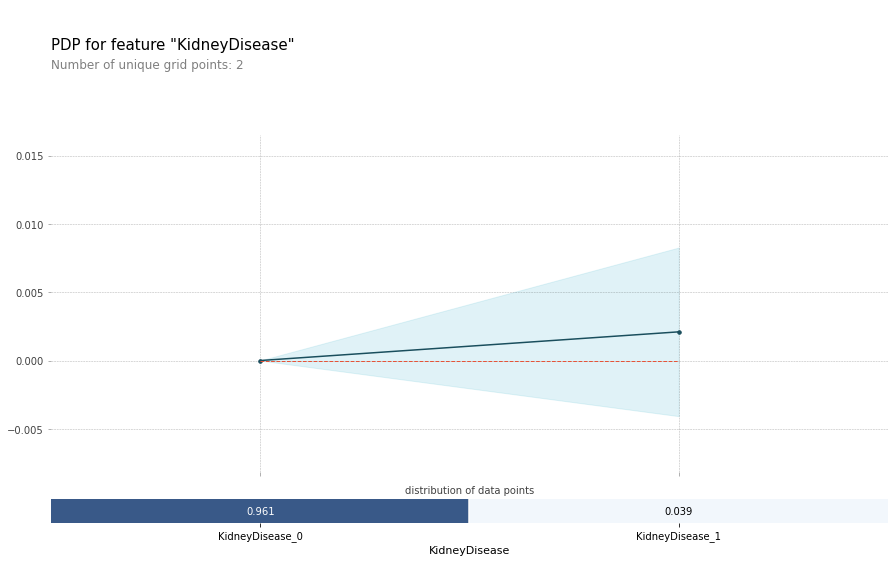

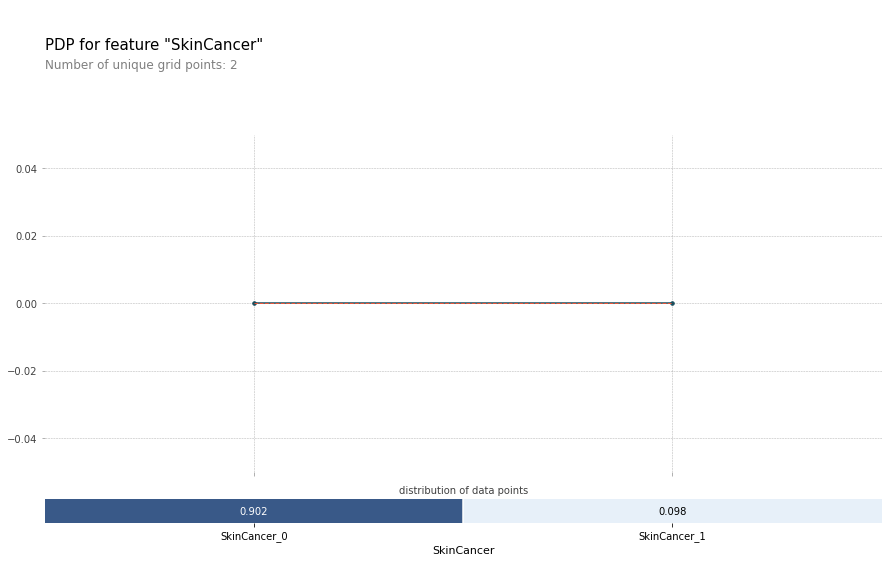

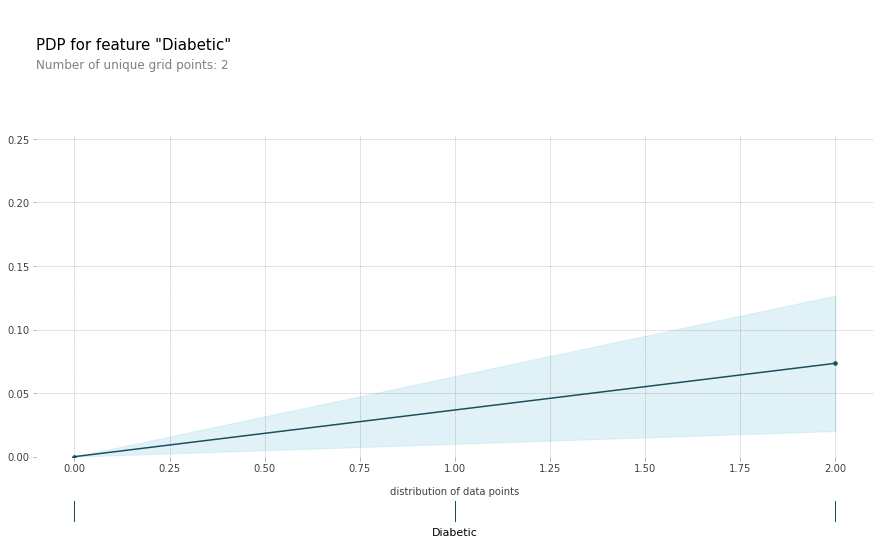

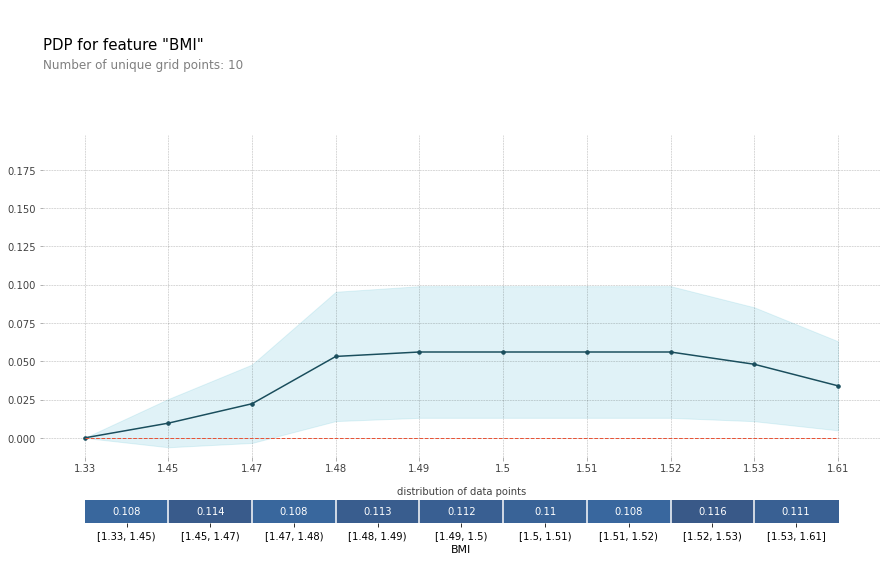

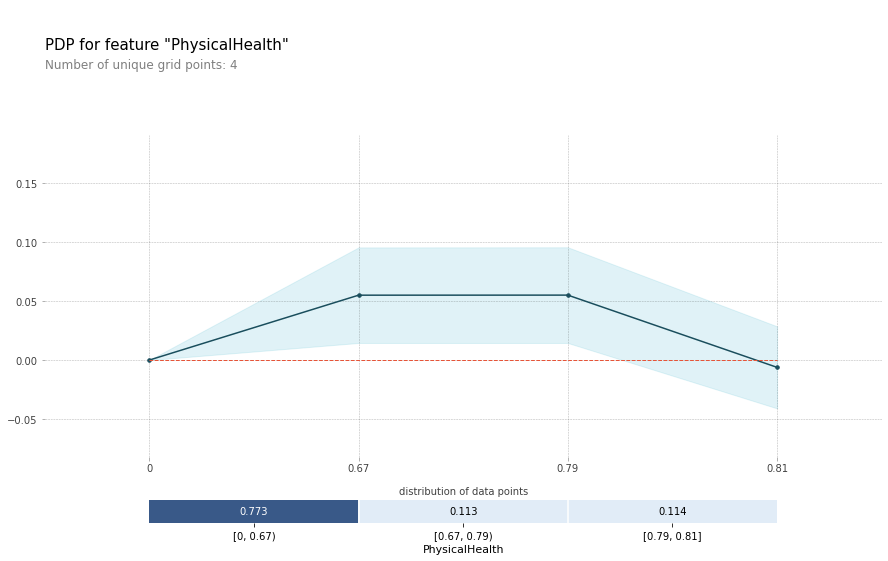

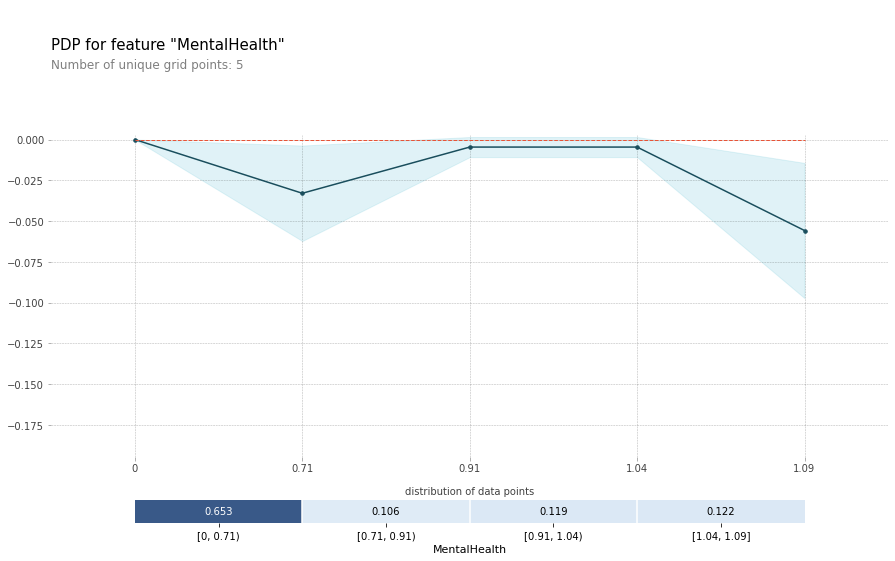

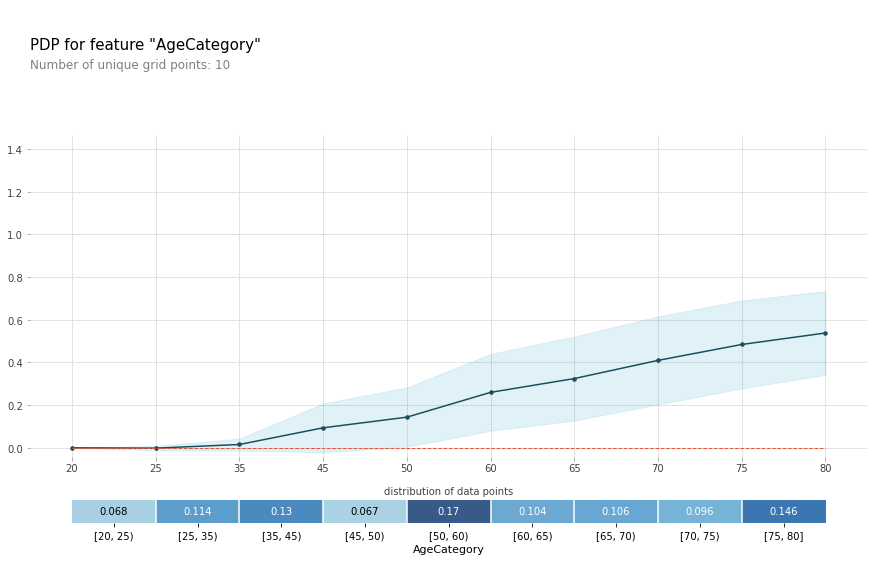

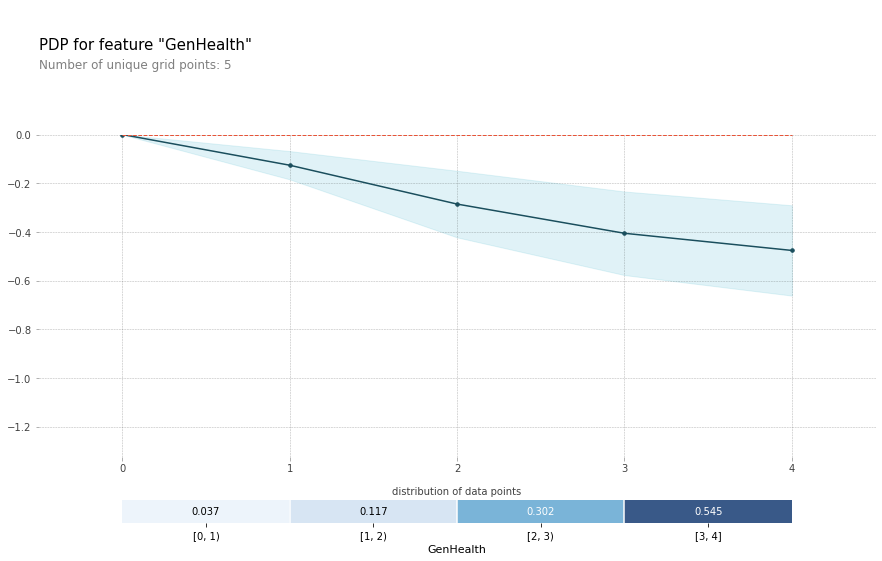

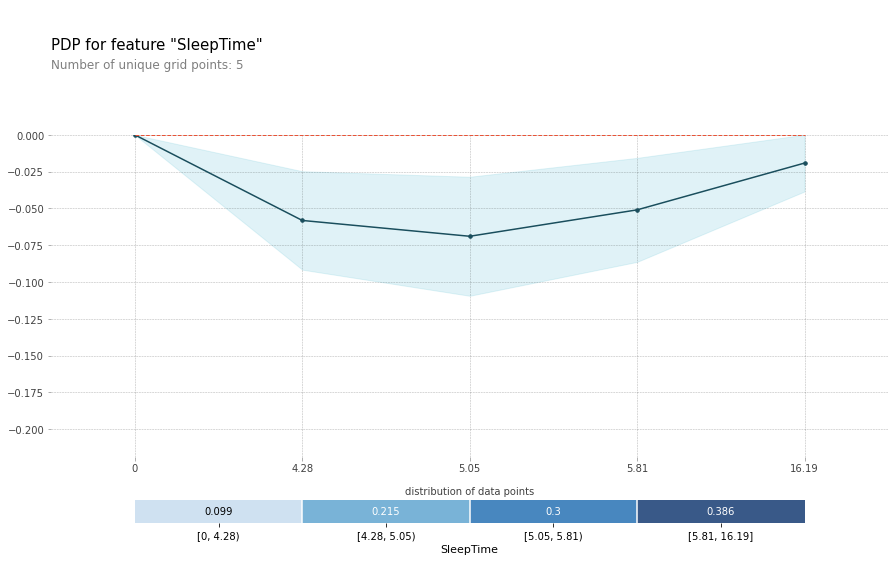

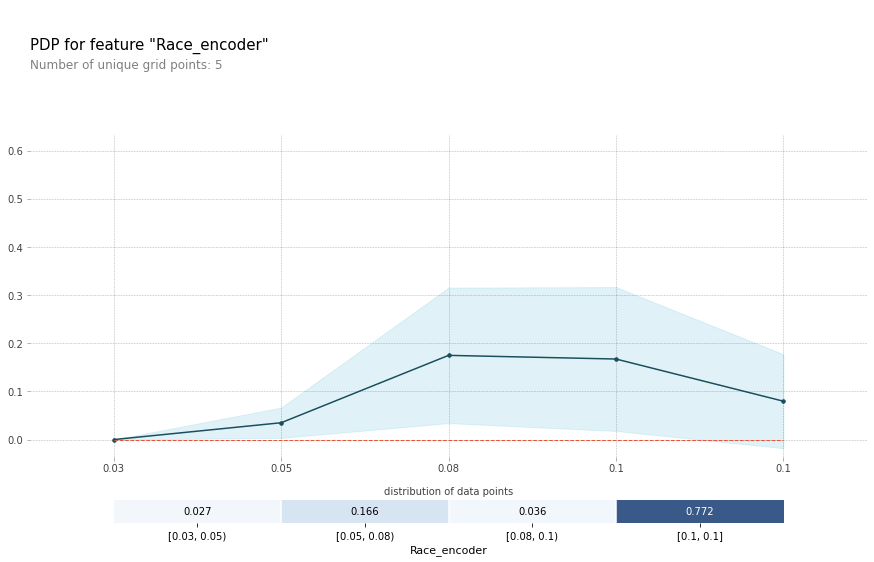

In [ ]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60270/60331 [01:02<00:00]       

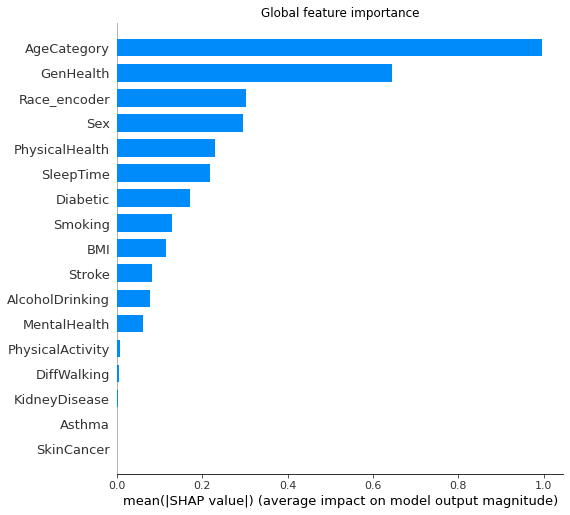

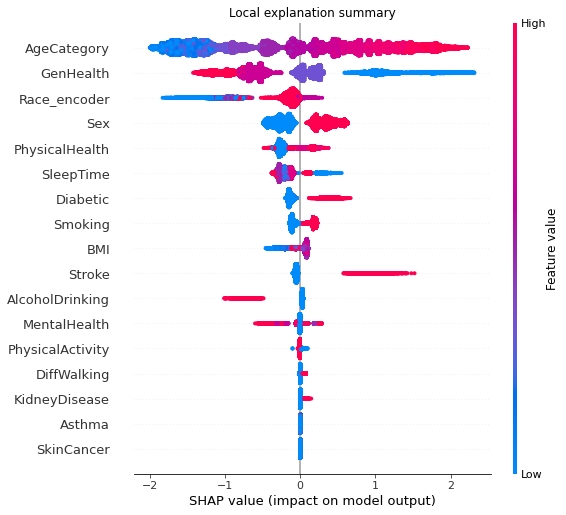

In [ ]:
# SHAP
explainer = shap.Explainer(model_SMOTEENN, x_train_SMOTEENN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)